In [1]:
from dqac import *
import math
import statsmodels.api as sm
import pandas as pd
import numpy as np
from numpy import *
import os
import random
import datetime
import csv
from gplearn2 import genetic#gplearn2自定义的遗传规划
from gplearn2 import functions
from gplearn2.functions import _Function
from scipy.stats import rankdata
from gplearn2 import fitness
import pickle as pkl
import seaborn as sns
import datetime
import pydotplus
import warnings 
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import matplotlib.pyplot as plt
import talib as ta
import numba as nb
import bottleneck as bn
import gplearn2 as gp#自己加载
from sklearn.utils.validation import check_X_y, check_array
import empyrical
# import xlsxwriter
import xlsxwriter#自己加载
from pylab import *
# matplotlib.use('Agg') 
from datetime import datetime,timedelta
import cloudpickle
from dqcta import CTABacktestor

In [1]:
#代码框架
#一、数据的收集
#二、数据的预处理一
#三、数据的预处理二
#四、算子的构建
#五、遗传规划结果转化为因子的归一化操作
#七、对每个品种遗传规划，观察效果
#八、对每个品种的遗传规划结果进行筛选，因子池操作，比较不同因子池

In [2]:
#一、数据的收集
#1.1、选择操作的品种名
kind_name=['A','AL','C','CU','FG','I','IC','IF','IH','L','M','NI','OI','P','RB','RM','SN','Y','ZN']#含有188个特征
kind_name_column_181=['FG','OI','RM']#含有181个特征

is_ni_columns=0#1代表使用NI的非正态特征，0代表其它

In [4]:
#1.2观察数据的列名
from cl_helper import CHDB
client = CHDB('yangyizhe', 'yyz@123', '192.168.1.191', '9000', 'factor_cta_v1')

kind='A'
df=client.query(f"SELECT * from cta_1min_factor_{kind} order by datetime").set_index(['date', 'datetime'])
columns=df.columns.values.tolist()
columns_factor=[i for i in columns if i[0]=='f']
columns_other=columns[1:16]

In [6]:
#1.3读取分钟数据，并转化为小时数据
is_minute=1
# filename='/home/shared_data/train_data/bar_1min.h5.old'

# x
# # #格式化因子名
def to_hour(index):
    x = client.query(f"SELECT * from cta_1min_factor_{index} order by datetime").set_index(['date', 'datetime'])
    col_names1=columns_other+['f0'+j.split('f')[1] if len(j)==3 else j for j in ['f00'+i.split('f')[1] if  len(i)==2  else i for i in columns_factor]]
    # # col_names1
    x=x[col_names1]
    x=x.reset_index()
    x=x.loc[x['date']<'2022-02-17']
    close_null=np.argwhere(x['close'].values==0)
    print(index+'_的缺失值：',close_null.flatten())
    if len(close_null)>0:
        x=x.drop(x.index[close_null.flatten()])
    format='%Y-%m-%d %H:%M:%S'
    x_time=x
    col=x_time.columns.tolist()
    col.remove('close')
    x_time['datetime']=x_time['datetime'].apply(lambda x:str(datetime.strptime(x,format)+timedelta(days=(datetime.strptime(x,format).hour+1)//24))[:11]+'{:02d}'.format((datetime.strptime(x,format).hour+1)%24)+':00:00' if datetime.strptime(x,format).minute!=0 else x[:13]+':00:00')
    x_hour_close=x_time[['date','datetime','close']].groupby(['date','datetime']).last()
    x_hour=x_time[col].groupby(['date','datetime']).mean()
    x=pd.concat([x_hour_close, x_hour], axis=1)
    return x

x_list=[]
for i in kind_name:
    x_list.append(to_hour(i))

A_的缺失值： [354615 354616 354617]
AL_的缺失值： [325260 325261 325262 325263 325264 325265 325266 325267 325268 325269
 325270 325271 325272 325273 325274 325275 325276 325277 325278 325279
 325280 325281 445035 445036 445037]
C_的缺失值： [102285 102286 102287 102288 102289 102290 102291 102292 102293 102294
 102295 102296 102297 102298 170910 170911 170912 170913 170914 170915
 170916 170917 170918 170919 170920 170921 170922 170923 170924 170925
 170926 170927 170928 170929 170930 170931 170932 170933 170934 170935
 170936 170937 170938 170939 170940 170941 170942 170943 170944 170945
 170946 170947 170948 170949 170950 170951 170952 170953 170954 170955
 170956 170957 170958 170959 170960 170961 170962 170963 170964 170965
 170966 170967 170968 170969 170970 170971 170972 170973 170974 170975
 170976 170977 170978 170979 170980 170981 170982 170983 170984 170985
 170986 170987 170988 170989 170990 170991 170992 170993 170994 170995
 170996 170997 170998 170999 237900 237901 237902 237903 237904

In [35]:
#1.4将小训练集、验证集、测试集的小时数据存储，便于以后直接读取
for index,kind in enumerate(kind_name):
#     index_start_list.append(init_null(x_list[index],kind))
    x_list[index].to_parquet('hour_data_mean/'+kind+'.parquet')

NameError: name 'x_list' is not defined

In [3]:
#1.5 观察输入特征、标签的缺失情况一
def init_null(x,kind):
    data_total=x
    total = data_total.isnull().sum()
    index_num=[]
    for i in range(data_total.shape[-1]):
        for j in range(len(data_total)):
            if pd.isnull(data_total.iloc[j][i])==False:
                index_num.append(j)
                break
    index_num=pd.Series(index_num,index=total.index)


    # .sort_values(ascending=False)
    percent = (data_total.isnull().sum()/data_total.isnull().count())
    # .sort_values(ascending=False)
    missing_data = pd.concat([total, index_num,percent], axis=1, keys=['Total','last_null_index', 'Percent'])
    missing_data['diff']=(missing_data['Total']-missing_data['last_null_index'])/len(data_total)
    missing_data=missing_data.sort_values(by='diff',ascending=False)
    # missing_data=missing_data.sort_values(by='Total',ascending=False)
#     print(kind+'_的开始最多缺失值数：',max(missing_data['last_null_index']))
    #定义初始位置

    index_start=max(missing_data['last_null_index'])+1
    
    return index_start
index_start_list=[]
for index,kind in enumerate(kind_name):
    index_start_list.append(init_null(x_list[index],kind))
    
pd.DataFrame(np.transpose([kind_name,index_start_list]),columns=['品种','特征初始缺失值数量-1'])    
# missing_data[missing_data['Total']!=0].head(100)

NameError: name 'x_list' is not defined

In [4]:
#二、数据的预处理一
#2.1读取小时数据的文件
index_start_list=[6]*len(kind_name)
x_list=[]
for index,kind in enumerate(kind_name):
    if kind in kind_name_column_181:
        x_iter=pd.read_parquet('hour_data_mean/'+kind+'.parquet')
        x_iter=pd.concat([x_list[0],x_iter],axis=0)
        x_iter=x_iter.iloc[len(x_list[0]):,:]
        if is_ni_columns==1:
            x_iter[['f016', 'f017', 'f018', 'f019', 'f020', 'f021', 'turnover']]=0.0
        x_list.append(x_iter)
        
    else:
        x_list.append(pd.read_parquet('hour_data_mean/'+kind+'.parquet'))
#     print(kind,len(x_list[-1]))


#2.2读取各品种主力合约更换的时间、涨跌停日期、放假日期、星期天日期
from dqt2 import get_future_daily 
from dqt2 import get_dbu
from dqt2 import get_trading_day
dbu=get_dbu()
date_main_list=[]#主力合约
date_limit_list=[]#涨跌停
date_holiday_list=[]#节假日
date_sunday_list=[]#周末
for index,kind in enumerate(kind_name):
    main=get_future_daily(variety=kind,start_date='2016-01-03',end_date='2022-02-16')
    main_date=main[main['is_main']==1].iloc[:,:10].sort_values(by='date',ascending=True)
    main_date['symbol_prev']=main_date['symbol'].shift(1)
    date_main_list.append(main_date[main_date['symbol']!=main_date['symbol_prev']]['date'].values[1:])
    # main_date['is_trade']=main_date.apply(lambda x:x['symbol'][1:]==x['trade_symbol'][1:],axis=1)
    
    
    limit=dbu.get_main_daily(variety=kind,start_date='2016-01-03',end_date='2022-02-16')
    date_limit_list.append(limit[(limit['high']==limit['up_limit']) | (limit['low']==limit['down_limit'])].sort_values(by='date',ascending=True)['date'].values)
    
    trading_day=get_trading_day().query("date>='2016-01-03' & date<='2022-02-16'")
    day_diff=trading_day.diff(1)
    day_diff['diff']=day_diff['date']/np.timedelta64(86400000000000,'ns')
    date_holiday_list.append(day_diff[day_diff['diff']>3].index.values)
    date_sunday_list.append(day_diff[day_diff['diff']==3].index.values)
    
    
    
#2.3输入特征的缺失情况+无穷值情况
# data_total=x[col_remain_names]
def factor_null(x_list):
    x_list_concat=pd.concat(x_list,axis=0)
    data_total=x_list_concat
    total = data_total.isnull().sum()+(data_total==inf).sum()+(data_total==-inf).sum()
    index_num=[]
    for i in range(data_total.shape[-1]):
        for j in range(len(data_total)):
            if pd.isnull(data_total.iloc[j][i])==False:
                index_num.append(j)
                break
    index_num=pd.Series(index_num,index=total.index)

    percent = (data_total.isnull().sum()+(data_total==inf).sum()+(data_total==inf).sum())/data_total.isnull().count()
    missing_data = pd.concat([total, index_num,percent], axis=1, keys=['Total','last_null_index', 'Percent'])
    missing_data['diff']=(missing_data['Total']-missing_data['last_null_index'])/len(data_total)

    missing_data=missing_data.sort_values(by='Total',ascending=False)
    missing_data_null=missing_data[missing_data['diff']>0]

    null_nums={}
    null_nums['>5000']=(missing_data_null['Total']>=5000).sum()
    null_nums['>1000']=(missing_data_null['Total']>=1000).sum()-(missing_data_null['Total']>=5000).sum()
    null_nums['100-1000']=(missing_data_null['Total']>=100).sum()-(missing_data_null['Total']>=1000).sum()
    null_nums['50-100']=(missing_data_null['Total']>=50).sum()-(missing_data_null['Total']>=100).sum()
    null_nums['10-50']=(missing_data_null['Total']>=10).sum()-(missing_data_null['Total']>=50).sum()
    null_nums['>0']=(missing_data_null['Total']>=1).sum()-(missing_data_null['Total']>=10).sum()
    return null_nums,missing_data_null
null_nums,missing_data_null=factor_null(x_list)
pd.DataFrame(null_nums,index=['num'])

,>5000,>1000,100-1000,50-100,10-50,>0
num,0,0,43,9,29,79


In [1]:

# missing_data_null.head(10)

A


/tmp/ipykernel_2097017/2741054896.py:82: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_total_train[i]=data_total_train[i].fillna(data_total_train[i].replace([np.inf,-np.inf],0).mean())#防止无穷值的出现，含无穷值的均值依然为无穷值
/opt/anaconda/envs/py39/lib/python3.9/site-packages/pandas/core/generic.py:6619: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return self._update_inplace(result)
/tmp/ipykernel_2097017/2741054896.py:84: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See

AL


/tmp/ipykernel_2097017/2741054896.py:82: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_total_train[i]=data_total_train[i].fillna(data_total_train[i].replace([np.inf,-np.inf],0).mean())#防止无穷值的出现，含无穷值的均值依然为无穷值
/opt/anaconda/envs/py39/lib/python3.9/site-packages/pandas/core/generic.py:6619: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return self._update_inplace(result)
/tmp/ipykernel_2097017/2741054896.py:84: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See

C
CU
FG
I
IC
IF
IH
L
M
NI
OI
P
RB
RM
SN
Y
ZN
>0.95的特征数: 63
>0.9的特征数: 149
一个特征同时和多个特征相关的特征数: 12


/opt/anaconda/envs/py39/lib/python3.9/site-packages/matplotlib/backends/backend_agg.py:240: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/opt/anaconda/envs/py39/lib/python3.9/site-packages/matplotlib/backends/backend_agg.py:203: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0, flags=flags)


删除的特征数： 42
剩余的特征数： 266


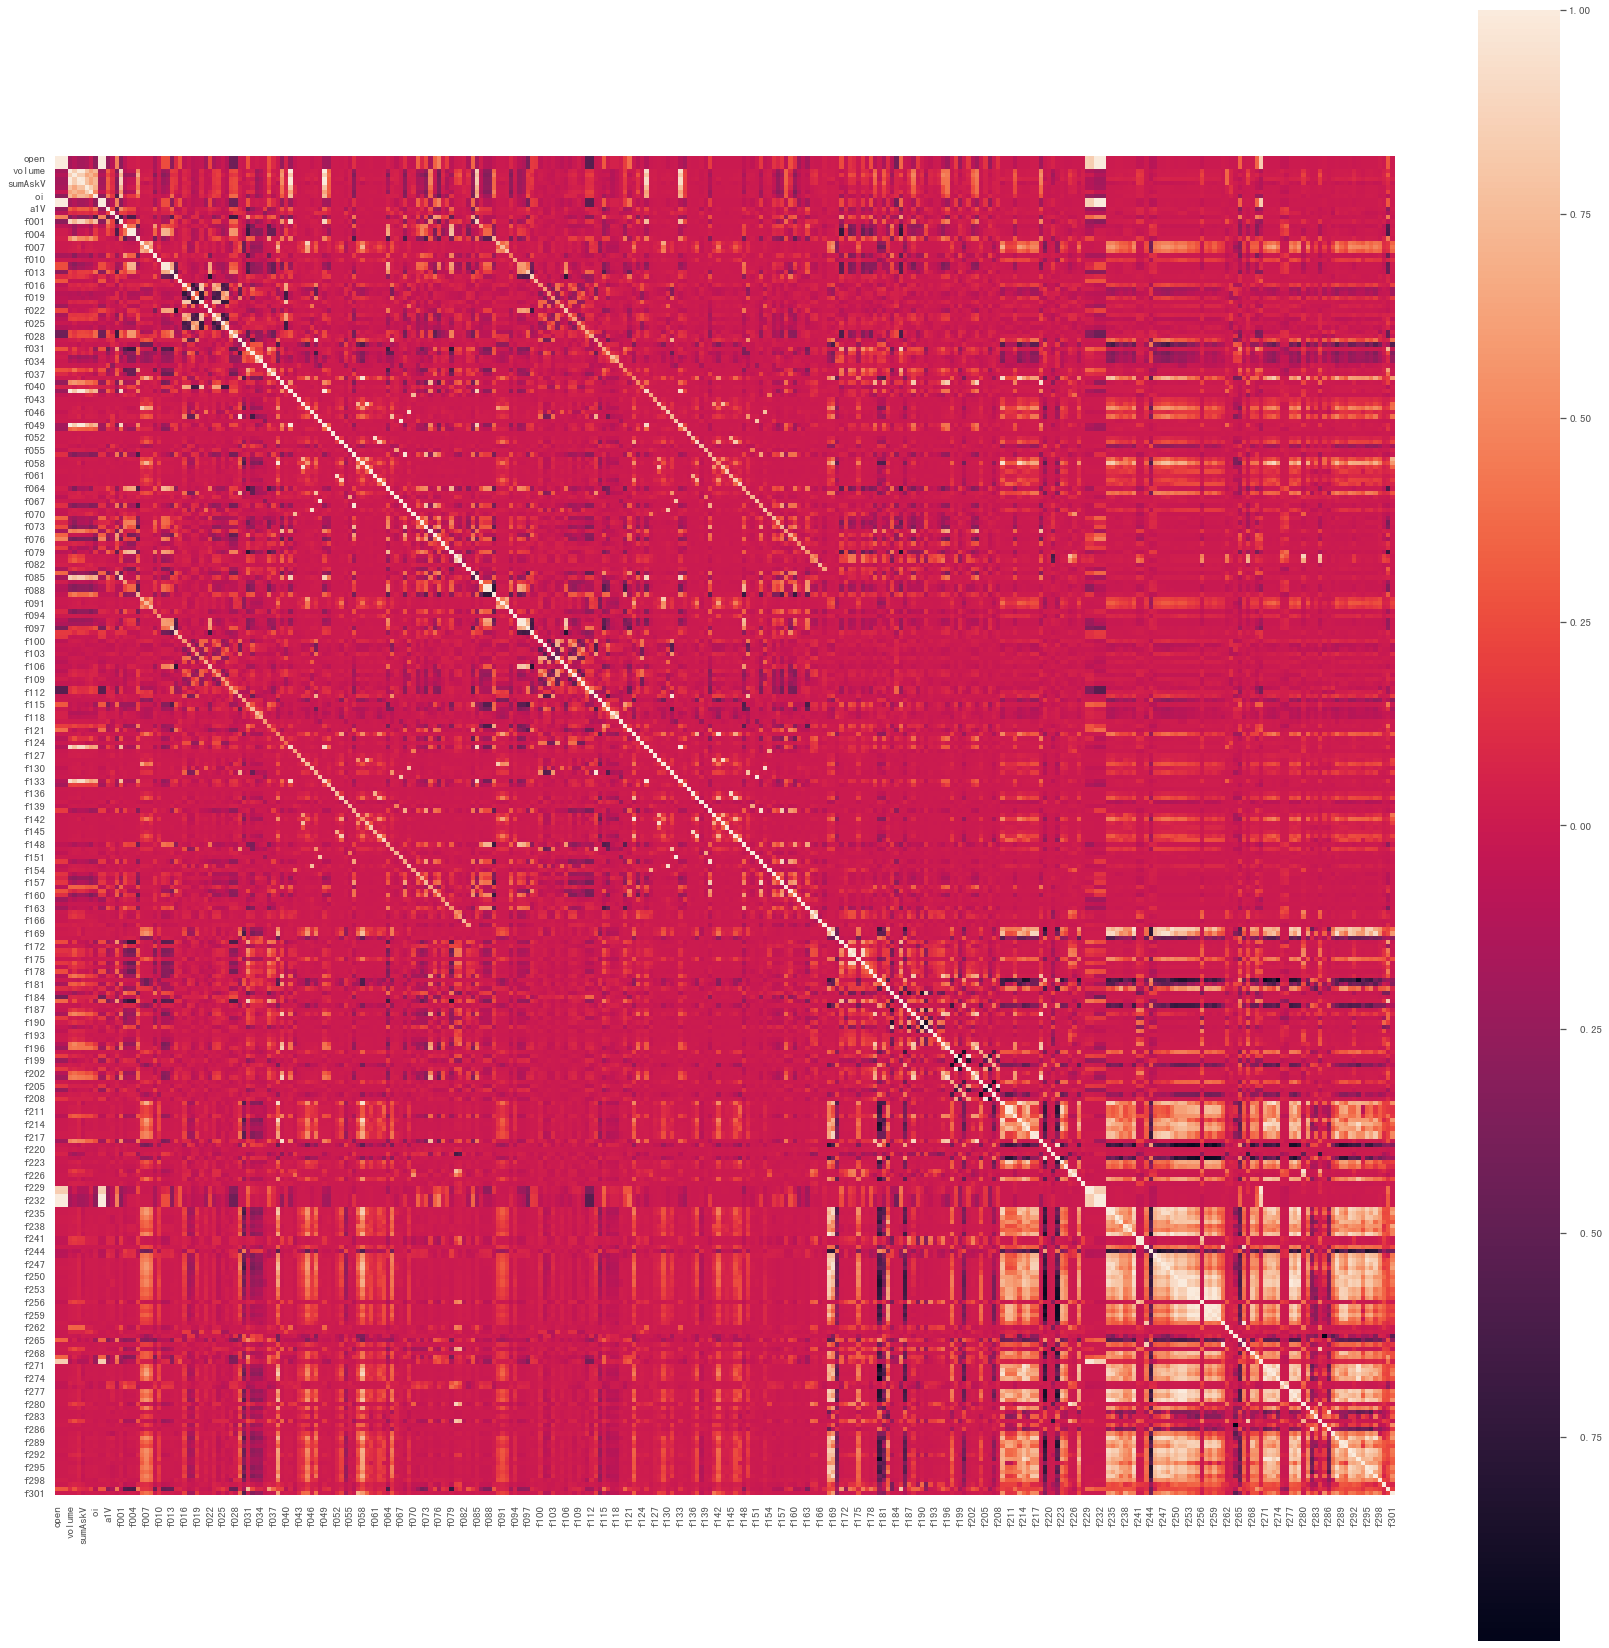

In [5]:
#三、数据的预处理二
#特征去极值函数
window_init=100
is_minute=1
@nb.jit()
def normal_window(data):
    ans=[0.0]*len(data)
    mean_iter=np.mean(data[:window_init])
    std_iter=np.std(data[:window_init])
    for i in range(window_init,len(data)):
        mean_iter_new=(mean_iter*i+data[i])/(i+1)
        std_iter=(std_iter**2*i+2.0*mean_iter*i*(mean_iter-mean_iter_new)+i*(mean_iter_new**2-mean_iter**2)+(data[i]-mean_iter_new)**2)/(i+1)
        std_iter=std_iter**(1/2)
        mean_iter=mean_iter_new
    #         if i%10000==0:

    #             print(i)
    #             print('mean:',mean_iter_new,np.mean(data[:i+1]))
    #             print('str:',std_iter,np.std(data[:i+1]))
        if data[i]>=mean_iter+3.0*std_iter:
            ans[i]=mean_iter+3.0*std_iter
        elif data[i]<=mean_iter-3.0*std_iter:
            ans[i]=mean_iter-3.0*std_iter
        else:
            ans[i]=data[i]
    return ans




f_factor_init=10
column_start=f_factor_init

#3.1、特征删除处理
list_not_delete=[]
if is_ni_columns==1:
    missing_filter=20000
else:
    missing_filter=10000
list_delete=missing_data_null[missing_data_null['Total']>=missing_filter].index.values #不规则数据超过1000就删除
for i in list(x_list[0].columns):
    if i not in list_delete:
        list_not_delete.append(i)
        




format='%Y-%m-%d %H:%M:%S'
# datetime.strptime(x,format)

#3.2 数据预处理：切分训练集、缺失值补充、除去极值
def process_data(x,index_start):
    #3.2.1划分训练集、验证集【2020年】、测试集【2021年】
    #得到2020年、2021年索引
    # index_start=2#大多数缺失值特征在前1行都是空值
    data_total=x[list_not_delete]
    index_2016,index_2020,index_2021=0,0,0
    for i in range(len(data_total)):
        if datetime.strptime(data_total.iloc[i].name[1],format).strftime("%Y-%m")=='2016-03':
#         if datetime.strptime(data_total.iloc[i].name[1],format).strftime("%Y-%m-%d %H:%M:%S")=='2016-01-19 14:00:00':
            index_2016=i+1
            break
        
    for i in range(len(data_total)):
        if datetime.strptime(data_total.iloc[i].name[1],format).strftime("%Y-%m")=='2020-01':
            index_2020=i+1
            break
    for i in range(index_2020,len(data_total)):
        if datetime.strptime(data_total.iloc[i].name[1],format).strftime("%Y-%m")=='2021-01':
            index_2021=i+1
            break
    #根据索引划分
    data_total_train=data_total.iloc[index_start-1:index_2020-1,:]#训练集
    data_total_val=data_total.iloc[index_2020-1:index_2021-1,:]#验证集
    data_total_test=data_total.iloc[index_2021-1:,:]#测试集



    #3.2.2、缺失值特征的均值补充，用训练集补充测试集和验证集，防止信息泄露
    list_null_feature=missing_data_null[missing_data_null['Total']<missing_filter].index.values
    for i in list_null_feature:
        data_total_train[i]=data_total_train[i].fillna(data_total_train[i].replace([np.inf,-np.inf],0).mean())#防止无穷值的出现，含无穷值的均值依然为无穷值
        data_total_train[i].replace([np.inf,-np.inf],data_total_train[i].replace([np.inf,-np.inf],0).mean(),inplace = True)
        data_total_val[i]=data_total_val[i].fillna(data_total_train[i].replace([np.inf,-np.inf],0).mean())
        data_total_val[i].replace([np.inf,-np.inf],data_total_train[i].replace([np.inf,-np.inf],0).mean(),inplace = True)
        data_total_test[i]=data_total_test[i].fillna(data_total_train[i].replace([np.inf,-np.inf],0).mean())
        data_total_test[i].replace([np.inf,-np.inf],data_total_train[i].replace([np.inf,-np.inf],0).mean(),inplace = True)


    #3.2.3 划分输入和输出
    x_train=data_total_train.iloc[:,1:]
    x_val=data_total_val.iloc[:,1:]
    x_test=data_total_test.iloc[:,1:]
    y_train=data_total_train.iloc[:,0]
    y_val=data_total_val.iloc[:,0]
    y_test=data_total_test.iloc[:,0]



    #归一化
    # scaler_x = MinMaxScaler(feature_range=(0, 1))#输入数据的标准化
    # scaler_x = scaler_x.fit(x_train)
    # x_train = scaler_x.transform(x_train)
    # x_val = scaler_x.transform(x_val)
    # x_test = scaler_x.transform(x_test)


    #未归一化

    # x_train = x_train.values
    # x_val = x_val.values
    # x_test = x_test.values

    #3.2.4合并
    x_all=pd.concat([x_train,x_val,x_test],axis=0)
    y_all=pd.concat([y_train,y_val,y_test],axis=0)



    #3.2.5 3sigma除去极值影响


    for i1 in range(len(x_all.iloc[0])):
        if len(set(x_all.iloc[:,i1].values.tolist()))>5:
            x_all.iloc[:,i1]=normal_window(x_all.iloc[:,i1].values)
    
    x_test=x_all.iloc[len(x_train)+len(x_val):len(x_train)+len(x_val)+len(x_test),:]
    x_val=x_all.iloc[len(x_train):len(x_train)+len(x_val),:]
    x_train=x_all.iloc[index_2016-index_start:len(x_train),:]


    x_all=x_all.iloc[index_2016-index_start:,:]
    y_all=y_all.iloc[index_2016-index_start:]


    y_train=y_train.iloc[index_2016-index_start:]
    return x_train,x_val,x_test,y_train,y_val,y_test,x_all,y_all

x_train_list=[]
x_val_list=[]
x_test_list=[]
x_all_list=[]
y_train_list=[]
y_val_list=[]
y_test_list=[]
y_all_list=[]
for index,kind in enumerate(kind_name):
    print(kind)
    x_train,x_val,x_test,y_train,y_val,y_test,x_all,y_all=process_data(x_list[index],index_start_list[index])
    x_train_list.append(x_train)
    x_val_list.append(x_val)
    x_test_list.append(x_test)
    x_all_list.append(x_all)
    y_train_list.append(y_train)
    y_val_list.append(y_val)
    y_test_list.append(y_test)
    y_all_list.append(y_all)
    
x_train,x_val,x_test,x_all,y_train,y_val,y_test,y_all=[0.0]*8#不占用内存


#3.3根据相关系数，筛除相关特征
#通过相关性剔除相关特征
def select_col(x_list,value):
    x_all=pd.concat(x_list,axis=0)
    corrmat = x_all.corr()#标注化后前100个为0


    cor_up=corrmat.iloc[column_start-2:,column_start-2:]#不考虑close的影响
    for i in range(len(cor_up)):
        for j in range(i+1):
            cor_up.iloc[i,j]=0
    #只保留上三角
    print('>0.95的特征数:',sum(sum(abs(cor_up)>0.95)))
    print('>0.9的特征数:',sum(sum(abs(cor_up)>0.9)))
    print('一个特征同时和多个特征相关的特征数:',sum(sum(abs(cor_up)>0.95)>1))


    f, ax = plt.subplots(figsize=(30, 30))
    sns.heatmap(x_all.corr().iloc[:,:], vmax=1.0, square=True)
    
    
    #剔除相关性大的特征，优先保留前面的特征
    col_deleted_index=[]
    cor_index_list=np.argwhere(abs(cor_up.values)>0.95)
    for i in range(len(cor_index_list)):
        #如果两个特征都未在删除列表里，就删除第二个特征
        if cor_index_list[i,0] not in col_deleted_index and cor_index_list[i,1] not in col_deleted_index:
            col_deleted_index.append(cor_index_list[i,1])
    print('删除的特征数：',len(col_deleted_index))
    col_remain_names=[ i  for idx,i in enumerate(cor_up.columns) if idx not in col_deleted_index]
    # col_remain_names=[ i  for i in cor_up.columns if int(i.split('f')[1]) not in col_deleted_index]
    
    print('剩余的特征数：',len(col_remain_names))
    if is_minute==1:
        col_remain_names=x_all.columns.values.tolist()[:f_factor_init-2]+col_remain_names
    else:
        col_remain_names=col_remain_names
#         col_remain_names=['close']+col_remain_names
    
    
    return col_remain_names

if is_ni_columns==1:
    col_remain_names=x_train_list[0].columns.values.tolist()
else:
    col_remain_names=select_col(x_list=x_train_list,value=0.95)

for index,kind in enumerate(kind_name):
    x_train_list[index]=x_train_list[index][col_remain_names]
    x_val_list[index]=x_val_list[index][col_remain_names]
    x_test_list[index]=x_test_list[index][col_remain_names]
    x_all_list[index]=x_all_list[index][col_remain_names]
    
#3.4 改变输出，寻找主力合约更换的位置
index_main_list=[]
index_holiday_list=[]
index_sunday_list=[]
for index,kind in enumerate(kind_name):
    y_train_list[index]=y_train_list[index].pct_change().shift(-1)
    y_train_list[index].iloc[-1]=0.0
    
    
    test_data_index=pd.DataFrame(y_train_list[index])
    test_data_index['index_v']=range(len(test_data_index))
    index_main_list.append(test_data_index.loc[date_main_list[index]].reset_index().groupby('date').first()['index_v'].values-1)
    index_holiday_list.append(test_data_index.loc[date_holiday_list[index]].reset_index().groupby('date').head(3)['index_v'].values)
    
    sunday_data=test_data_index.loc[date_sunday_list[index]].reset_index()
    sunday_data['date_equal']=sunday_data.apply(lambda x:1 if str(x['date'])[:10]==x['datetime'][:10] else 0,axis=1)
    index_sunday_list.append(sunday_data[sunday_data['date_equal']==1].groupby('date').first()['index_v'].values)
    
    


#3.5 生成特征名
fields=x_train_list[0].columns.values.tolist()

In [6]:
#四、构建算子
#4.1 直接使用gplearn自带的neg函数

#zscore和rank占时间,1ms
# function_list=['neg','log']
function_list=[functions.make_function(function=np.negative, name='neg', arity=1)]


#4.2 直接使用dqac的sign函数
sign = functions.make_function(function=SIGN, name='sign', arity=1)
function_list+=[sign]

#用talib
function_arity1_talib=[ta.EMA,ta.KAMA,ta.DEMA,ta.WMA,ta.SUM,ta.MAX,ta.MIN,ta.ROCR,ta.LINEARREG_ANGLE,ta.LINEARREG_INTERCEPT,ta.LINEARREG_SLOPE]

#用dqac
function_arity2_dqac=[TSBETA,ZSCORE]

# function_arity1_dqac_name=['ema','kama','dema','wma','sum','max','min','pct_change','linearreg_angle','linearreg_intercept','linearreg_slope']
# function_arity2_dqac_name=['beta']

#便于观察，后期尝试用partial减少代码量

def window_process(x):
    for index in range(len(x)):
        if x[index]!=0.01234:#前index个数为初始值0.012345
            break
    return index
    



def _ts_ema(x,w):
    if len(x)<w:
        return x
    index=window_process(x)
    x=x[index:]
    value=ta.EMA(x,w)
    return np.append(np.array([0.01234]*(w+index-1)), value[w-1:])#注意第w个值可算出
def _ts_ema_20(x):
    return _ts_ema(x,20)
def _ts_ema_40(x):
    return _ts_ema(x,40)
def _ts_ema_60(x):
    return _ts_ema(x,60)
def _ts_ema_80(x):
    return _ts_ema(x,80)
def _ts_ema_100(x):
    return _ts_ema(x,100)
def _ts_ema_120(x):
    return _ts_ema(x,120)
def _ts_ema_140(x):
    return _ts_ema(x,140)
def _ts_ema_160(x):
    return _ts_ema(x,160)
def _ts_ema_180(x):
    return _ts_ema(x,180)
def _ts_ema_200(x):
    return _ts_ema(x,200)

def _ts_kama(x,w):#w个nan
    if len(x)<w:
        return x
    index=window_process(x)
    x=x[index:]
    value=ta.KAMA(x,w)
    return np.append(np.array([0.01234]*(w+index)), value[w:])

def _ts_kama_20(x):
    return _ts_kama(x,20)
def _ts_kama_40(x):
    return _ts_kama(x,40)
def _ts_kama_60(x):
    return _ts_kama(x,60)
def _ts_kama_80(x):
    return _ts_kama(x,80)
def _ts_kama_100(x):
    return _ts_kama(x,100)
def _ts_kama_120(x):
    return _ts_kama(x,120)
def _ts_kama_140(x):
    return _ts_kama(x,140)
def _ts_kama_160(x):
    return _ts_kama(x,160)
def _ts_kama_180(x):
    return _ts_kama(x,180)
def _ts_kama_200(x):
    return _ts_kama(x,200)

def _ts_dema(x,w):
    if len(x)<w:
        return x
    index=window_process(x)
    x=x[index:]
    value=ta.DEMA(x,w)
    return np.append(np.array([0.01234]*(2*w+index-1)), value[2*w-1:])
def _ts_dema_20(x):
    return _ts_dema(x,20)
def _ts_dema_40(x):
    return _ts_dema(x,40)
def _ts_dema_60(x):
    return _ts_dema(x,60)
def _ts_dema_80(x):
    return _ts_dema(x,80)
def _ts_dema_100(x):
    return _ts_dema(x,100)
def _ts_dema_120(x):
    return _ts_dema(x,120)
def _ts_dema_140(x):
    return _ts_dema(x,140)
def _ts_dema_160(x):
    return _ts_dema(x,160)
def _ts_dema_180(x):
    return _ts_dema(x,180)
def _ts_dema_200(x):
    return _ts_dema(x,200)

def _ts_wma(x,w):
    if len(x)<w:
        return x
    index=window_process(x)
    x=x[index:]
    value=ta.WMA(x,w)
    return np.append(np.array([0.01234]*(w+index-1)), value[w-1:])
def _ts_wma_20(x):
    return _ts_wma(x,20)
def _ts_wma_40(x):
    return _ts_wma(x,40)
def _ts_wma_60(x):
    return _ts_wma(x,60)
def _ts_wma_80(x):
    return _ts_wma(x,80)
def _ts_wma_100(x):
    return _ts_wma(x,100)
def _ts_wma_120(x):
    return _ts_wma(x,120)
def _ts_wma_140(x):
    return _ts_wma(x,140)
def _ts_wma_160(x):
    return _ts_wma(x,160)
def _ts_wma_180(x):
    return _ts_wma(x,180)
def _ts_wma_200(x):
    return _ts_wma(x,200)

def _ts_sum(x,w):
    if len(x)<w:
        return x
    index=window_process(x)
    x=x[index:]
    value=ta.SUM(x,w)
    return np.append(np.array([0.01234]*(w+index-1)), value[w-1:])
    
def _ts_sum_20(x):
    return _ts_sum(x,20)
def _ts_sum_40(x):
    return _ts_sum(x,40)
def _ts_sum_60(x):
    return _ts_sum(x,60)
def _ts_sum_80(x):
    return _ts_sum(x,80)
def _ts_sum_100(x):
    return _ts_sum(x,100)
def _ts_sum_120(x):
    return _ts_sum(x,120)
def _ts_sum_140(x):
    return _ts_sum(x,140)
def _ts_sum_160(x):
    return _ts_sum(x,160)
def _ts_sum_180(x):
    return _ts_sum(x,180)
def _ts_sum_200(x):
    return _ts_sum(x,200)

def _ts_max(x,w):
    if len(x)<w:
        return x
    index=window_process(x)
    x=x[index:]
    value=ta.MAX(x,w)
    return np.append(np.array([0.01234]*(w+index-1)), value[w-1:])
def _ts_max_20(x):
    return _ts_max(x,20)
def _ts_max_40(x):
    return _ts_max(x,40)
def _ts_max_60(x):
    return _ts_max(x,60)
def _ts_max_80(x):
    return _ts_max(x,80)
def _ts_max_100(x):
    return _ts_max(x,100)
def _ts_max_120(x):
    return _ts_max(x,120)
def _ts_max_140(x):
    return _ts_max(x,140)
def _ts_max_160(x):
    return _ts_max(x,160)
def _ts_max_180(x):
    return _ts_max(x,180)
def _ts_max_200(x):
    return _ts_max(x,200)

def _ts_min(x,w):
    if len(x)<w:
        return x
    index=window_process(x)
    x=x[index:]
    value=ta.MIN(x,w)
    return np.append(np.array([0.01234]*(w+index-1)), value[w-1:])
def _ts_min_20(x):
    return _ts_min(x,20)
def _ts_min_40(x):
    return _ts_min(x,40)
def _ts_min_60(x):
    return _ts_min(x,60)
def _ts_min_80(x):
    return _ts_min(x,80)
def _ts_min_100(x):
    return _ts_min(x,100)
def _ts_min_120(x):
    return _ts_min(x,120)
def _ts_min_140(x):
    return _ts_min(x,140)
def _ts_min_160(x):
    return _ts_min(x,160)
def _ts_min_180(x):
    return _ts_min(x,180)
def _ts_min_200(x):
    return _ts_min(x,200)


def _ts_pct_change(x,w):#w个nan
    if len(x)<w:
        return x
    index=window_process(x)
    x=x[index:]
    value=ta.ROCR(x,w)
    return np.append(np.array([0.01234]*(w+index)), value[w:])
def _ts_pct_change_20(x):
    return _ts_pct_change(x,20)
def _ts_pct_change_40(x):
    return _ts_pct_change(x,40)
def _ts_pct_change_60(x):
    return _ts_pct_change(x,60)
def _ts_pct_change_80(x):
    return _ts_pct_change(x,80)
def _ts_pct_change_100(x):
    return _ts_pct_change(x,100)
def _ts_pct_change_120(x):
    return _ts_pct_change(x,120)
def _ts_pct_change_140(x):
    return _ts_pct_change(x,140)
def _ts_pct_change_160(x):
    return _ts_pct_change(x,160)
def _ts_pct_change_180(x):
    return _ts_pct_change(x,180)
def _ts_pct_change_200(x):
    return _ts_pct_change(x,200)

def _ts_linearreg_angle(x,w):
    if len(x)<w:
        return x
    index=window_process(x)
    x=x[index:]
    value=ta.LINEARREG_ANGLE(x,w)
    return np.append(np.array([0.01234]*(w+index-1)), value[w-1:])
def _ts_linearreg_angle_20(x):
    return _ts_linearreg_angle(x,20)
def _ts_linearreg_angle_40(x):
    return _ts_linearreg_angle(x,40)
def _ts_linearreg_angle_60(x):
    return _ts_linearreg_angle(x,60)
def _ts_linearreg_angle_80(x):
    return _ts_linearreg_angle(x,80)
def _ts_linearreg_angle_100(x):
    return _ts_linearreg_angle(x,100)
def _ts_linearreg_angle_120(x):
    return _ts_linearreg_angle(x,120)
def _ts_linearreg_angle_140(x):
    return _ts_linearreg_angle(x,140)
def _ts_linearreg_angle_160(x):
    return _ts_linearreg_angle(x,160)
def _ts_linearreg_angle_180(x):
    return _ts_linearreg_angle(x,180)
def _ts_linearreg_angle_200(x):
    return _ts_linearreg_angle(x,200)

def _ts_linearreg_intercept(x,w):
    if len(x)<w:
        return x
    index=window_process(x)
    x=x[index:]
    value=ta.LINEARREG_INTERCEPT(x,w)
    return np.append(np.array([0.01234]*(w+index-1)), value[w-1:])
def _ts_linearreg_intercept_20(x):
    return _ts_linearreg_intercept(x,20)
def _ts_linearreg_intercept_40(x):
    return _ts_linearreg_intercept(x,40)
def _ts_linearreg_intercept_60(x):
    return _ts_linearreg_intercept(x,60)
def _ts_linearreg_intercept_80(x):
    return _ts_linearreg_intercept(x,80)
def _ts_linearreg_intercept_100(x):
    return _ts_linearreg_intercept(x,100)
def _ts_linearreg_intercept_120(x):
    return _ts_linearreg_intercept(x,120)
def _ts_linearreg_intercept_140(x):
    return _ts_linearreg_intercept(x,140)
def _ts_linearreg_intercept_160(x):
    return _ts_linearreg_intercept(x,160)
def _ts_linearreg_intercept_180(x):
    return _ts_linearreg_intercept(x,180)
def _ts_linearreg_intercept_200(x):
    return _ts_linearreg_intercept(x,200)

def _ts_linearreg_slope(x,w):
    if len(x)<w:
        return x
    index=window_process(x)
    x=x[index:]
    value=ta.LINEARREG_SLOPE(x,w)
    return np.append(np.array([0.01234]*(w+index-1)), value[w-1:])
def _ts_linearreg_slope_20(x):
    return _ts_linearreg_slope(x,20)
def _ts_linearreg_slope_40(x):
    return _ts_linearreg_slope(x,40)
def _ts_linearreg_slope_60(x):
    return _ts_linearreg_slope(x,60)
def _ts_linearreg_slope_80(x):
    return _ts_linearreg_slope(x,80)
def _ts_linearreg_slope_100(x):
    return _ts_linearreg_slope(x,100)
def _ts_linearreg_slope_120(x):
    return _ts_linearreg_slope(x,120)
def _ts_linearreg_slope_140(x):
    return _ts_linearreg_slope(x,140)
def _ts_linearreg_slope_160(x):
    return _ts_linearreg_slope(x,160)
def _ts_linearreg_slope_180(x):
    return _ts_linearreg_slope(x,180)
def _ts_linearreg_slope_200(x):
    return _ts_linearreg_slope(x,200)







        #批量生成函数和变量名
#         setattr(m, 'ts_'+function_arity1_dqac_name[num]+'_'+str(w)+'_base_func', _base_func)
#         globals()['ts_'+function_arity1_dqac_name[num]+'_'+str(w)] = functions.make_function(function=globals()['ts_'+function_arity1_dqac_name[num]+'_'+str(w)+'_base_func'], name='ts_'+function_arity1_dqac_name[num]+'_'+str(w), arity=1)
        
#         function_list.append(globals()['ts_'+function_arity1_dqac_name[num]+'_'+str(w)])
#         print(function_list[3](data))
        
#     #2.3.2 添加dqac库可用的二阶变量算子    
#     for num, _func2 in enumerate(function_arity2_dqac):
#         def _base_func(x,y):
#             value=_func2(x,y,w)
#             value[:w]=0.0
# #             value = np.nan_to_num(value)
#             return value
#         #批量生成函数和变量名
#         globals()['ts_'+function_arity2_dqac_name[num]+'_'+str(w)] = functions.make_function(function=_base_func, name='ts_'+function_arity2_dqac_name[num]+'_'+str(w), arity=2)
#         function_list.append(globals()['ts_'+function_arity2_dqac_name[num]+'_'+str(w)])

    
#自定义
# @nb.jit()
def _ts_delay(data,w):
    if len(data) < w:
        return data
    else:
        index=window_process(data)
        data=data[index:]
        return np.append(np.array([0.01234]*(w+index)), data[:-w])

def _ts_delay_20(x):
    return _ts_delay(x,20)
def _ts_delay_40(x):
    return _ts_delay(x,40)
def _ts_delay_60(x):
    return _ts_delay(x,60)
def _ts_delay_80(x):
    return _ts_delay(x,80)
def _ts_delay_100(x):
    return _ts_delay(x,100)
def _ts_delay_120(x):
    return _ts_delay(x,120)
def _ts_delay_140(x):
    return _ts_delay(x,140)
def _ts_delay_160(x):
    return _ts_delay(x,160)
def _ts_delay_180(x):
    return _ts_delay(x,180)
def _ts_delay_200(x):
    return _ts_delay(x,200)


#@nb.jit()
def _ts_delta(data,w):
    if len(data) < w:
        return data
    else:
        index=window_process(data)
        data=data[index:]
        return np.append(np.array([0.01234]*(w+index)), np.diff(data,w))
def _ts_delta_20(x):
    return _ts_delta(x,20)
def _ts_delta_40(x):
    return _ts_delta(x,40)
def _ts_delta_60(x):
    return _ts_delta(x,60)
def _ts_delta_80(x):
    return _ts_delta(x,80)
def _ts_delta_100(x):
    return _ts_delta(x,100)
def _ts_delta_120(x):
    return _ts_delta(x,120)
def _ts_delta_140(x):
    return _ts_delta(x,140)
def _ts_delta_160(x):
    return _ts_delta(x,160)
def _ts_delta_180(x):
    return _ts_delta(x,180)
def _ts_delta_200(x):
    return _ts_delta(x,200)

def _ts_mean(data,w):
    if len(data) < w:
        return data
    else:
        index=window_process(data)
        data=data[index:]
        value=bn.move_mean(data,window=w, min_count=1)
    return np.append(np.array([0.01234]*(w+index-1)), value[w-1:])
def _ts_mean_20(x):
    return _ts_mean(x,20)
def _ts_mean_40(x):
    return _ts_mean(x,40)
def _ts_mean_60(x):
    return _ts_mean(x,60)
def _ts_mean_80(x):
    return _ts_mean(x,80)
def _ts_mean_100(x):
    return _ts_mean(x,100)
def _ts_mean_120(x):
    return _ts_mean(x,120)
def _ts_mean_140(x):
    return _ts_mean(x,140)
def _ts_mean_160(x):
    return _ts_mean(x,160)
def _ts_mean_180(x):
    return _ts_mean(x,180)
def _ts_mean_200(x):
    return _ts_mean(x,200)

def _ts_median(data,w):
    if len(data) < w:
        return data
    else:
        index=window_process(data)
        data=data[index:]
        value=bn.move_median(data,window=w, min_count=1)
    return np.append(np.array([0.01234]*(w+index-1)), value[w-1:])
def _ts_median_20(x):
    return _ts_median(x,20)
def _ts_median_40(x):
    return _ts_median(x,40)
def _ts_median_60(x):
    return _ts_median(x,60)
def _ts_median_80(x):
    return _ts_median(x,80)
def _ts_median_100(x):
    return _ts_median(x,100)
def _ts_median_120(x):
    return _ts_median(x,120)
def _ts_median_140(x):
    return _ts_median(x,140)
def _ts_median_160(x):
    return _ts_median(x,160)
def _ts_median_180(x):
    return _ts_median(x,180)
def _ts_median_200(x):
    return _ts_median(x,200)

def _ts_rank(data,w):
    if len(data) < w:
        return data
    else:
        index=window_process(data)
        data=data[index:]
        value=bn.move_rank(data,window=w, min_count=1)
    return np.append(np.array([0.01234]*(w+index-1)), value[w-1:])
def _ts_rank_20(x):
    return _ts_rank(x,20)
def _ts_rank_40(x):
    return _ts_rank(x,40)
def _ts_rank_60(x):
    return _ts_rank(x,60)
def _ts_rank_80(x):
    return _ts_rank(x,80)
def _ts_rank_100(x):
    return _ts_rank(x,100)
def _ts_rank_120(x):
    return _ts_rank(x,120)
def _ts_rank_140(x):
    return _ts_rank(x,140)
def _ts_rank_160(x):
    return _ts_rank(x,160)
def _ts_rank_180(x):
    return _ts_rank(x,180)
def _ts_rank_200(x):
    return _ts_rank(x,200)

def _ts_mean_return(data,w):
    if len(data) < w:
        return data
    else:
        index=window_process(data)
        data=data[index:]
        return_v=np.append(np.full([1,], 0.0),ta.ROCR(data,1)[1:]-1)
        value=bn.move_mean(return_v,window=w, min_count=1)
    return np.append(np.array([0.01234]*(w+index-1)), value[w-1:])
def _ts_mean_return_20(x):
    return _ts_mean_return(x,20)
def _ts_mean_return_40(x):
    return _ts_mean_return(x,40)
def _ts_mean_return_60(x):
    return _ts_mean_return(x,60)
def _ts_mean_return_80(x):
    return _ts_mean_return(x,80)
def _ts_mean_return_100(x):
    return _ts_mean_return(x,100)
def _ts_mean_return_120(x):
    return _ts_mean_return(x,120)
def _ts_mean_return_140(x):
    return _ts_mean_return(x,140)
def _ts_mean_return_160(x):
    return _ts_mean_return(x,160)
def _ts_mean_return_180(x):
    return _ts_mean_return(x,180)
def _ts_mean_return_200(x):
    return _ts_mean_return(x,200)

def _ts_corr(x,y,w):
    if len(x) < w:
        return x
    index_x=window_process(x)
    index_y=window_process(y)
    index=max(index_x,index_y)
    x=x[index:]
    y=y[index:]
    z=x*y
    z=bn.move_mean(z, window=w, min_count=1)-bn.move_mean(x, window=w, min_count=1)*bn.move_mean(y, window=w, min_count=1)
    z2=bn.move_std(x, window=w, min_count=1)*bn.move_std(y, window=w, min_count=1)
    with np.errstate(divide='ignore', invalid='ignore'):
        z=np.where(z2 > 1e-8, z/z2, 1)
    return np.append(np.array([0.01234]*(w+index-1)), z[w-1:])
def _ts_corr_20(x,y):
    return _ts_corr(x,y,20)
def _ts_corr_40(x,y):
    return _ts_corr(x,y,40)
def _ts_corr_60(x,y):
    return _ts_corr(x,y,60)
def _ts_corr_80(x,y):
    return _ts_corr(x,y,80)
def _ts_corr_100(x,y):
    return _ts_corr(x,y,100)
def _ts_corr_120(x,y):
    return _ts_corr(x,y,120)
def _ts_corr_140(x,y):
    return _ts_corr(x,y,140)
def _ts_corr_160(x,y):
    return _ts_corr(x,y,160)
def _ts_corr_180(x,y):
    return _ts_corr(x,y,180)
def _ts_corr_200(x,y):
    return _ts_corr(x,y,200)

def _ts_midpoint(data,w):
    if len(data) < w:
        return data
    index=window_process(data)
    data=data[index:]
    max_v=ta.MAX(data,w)
    min_v=ta.MIN(data,w)
    return np.append(np.array([0.01234]*(w+index-1)),(max_v[w-1:]+min_v[w-1:])/2)
def _ts_midpoint_20(x):
    return _ts_midpoint(x,20)
def _ts_midpoint_40(x):
    return _ts_midpoint(x,40)
def _ts_midpoint_60(x):
    return _ts_midpoint(x,60)
def _ts_midpoint_80(x):
    return _ts_midpoint(x,80)
def _ts_midpoint_100(x):
    return _ts_midpoint(x,100)
def _ts_midpoint_120(x):
    return _ts_midpoint(x,120)
def _ts_midpoint_140(x):
    return _ts_midpoint(x,140)
def _ts_midpoint_160(x):
    return _ts_midpoint(x,160)
def _ts_midpoint_180(x):
    return _ts_midpoint(x,180)
def _ts_midpoint_200(x):
    return _ts_midpoint(x,200)

def _ts_cov(x,y,w):
    if len(x) < w:
        return x
    index_x=window_process(x)
    index_y=window_process(y)
    index=max(index_x,index_y)
    x=x[index:]
    y=y[index:]
    z=x*y
    z=bn.move_mean(z, window=w, min_count=1)-bn.move_mean(x, window=w, min_count=1)*bn.move_mean(y, window=w, min_count=1)
    return np.append(np.array([0.01234]*(w+index-1)), z[w-1:])
def _ts_cov_20(x,y):
    return _ts_cov(x,y,20)
def _ts_cov_40(x,y):
    return _ts_cov(x,y,40)
def _ts_cov_60(x,y):
    return _ts_cov(x,y,60)
def _ts_cov_80(x,y):
    return _ts_cov(x,y,80)
def _ts_cov_100(x,y):
    return _ts_cov(x,y,100)
def _ts_cov_120(x,y):
    return _ts_cov(x,y,120)
def _ts_cov_140(x,y):
    return _ts_cov(x,y,140)
def _ts_cov_160(x,y):
    return _ts_cov(x,y,160)
def _ts_cov_180(x,y):
    return _ts_cov(x,y,180)
def _ts_cov_200(x,y):
    return _ts_cov(x,y,200)

def _ts_zscore(x,w):
    if len(x)<w:
        return x
    index=window_process(x)
    x=x[index:]
    x=pd.Series(x)
    value=ZSCORE(x,w).values
    return np.append(np.array([0.01234]*(w+index-1)),value[w-1:])
def _ts_zscore_20(x):
    return _ts_zscore(x,20)
def _ts_zscore_40(x):
    return _ts_zscore(x,40)
def _ts_zscore_60(x):
    return _ts_zscore(x,60)
def _ts_zscore_80(x):
    return _ts_zscore(x,80)
def _ts_zscore_100(x):
    return _ts_zscore(x,100)
def _ts_zscore_120(x):
    return _ts_zscore(x,120)
def _ts_zscore_140(x):
    return _ts_zscore(x,140)
def _ts_zscore_160(x):
    return _ts_zscore(x,160)
def _ts_zscore_180(x):
    return _ts_zscore(x,180)
def _ts_zscore_200(x):
    return _ts_zscore(x,200)

def _ts_maxmin_norm(data,w):
    if len(data) < w:
        return data
    index=window_process(data)
    data=data[index:]
    max_v=ta.MAX(data,w)
    min_v=ta.MIN(data,w)
    with np.errstate(divide='ignore', invalid='ignore'):
        value=np.where(max_v-min_v > 1e-8, (data-min_v)/(max_v-min_v), 1.0)
    return np.append(np.array([0.01234]*(w+index-1)),value[w-1:])
def _ts_maxmin_norm_20(x):
    return _ts_maxmin_norm(x,20)
def _ts_maxmin_norm_40(x):
    return _ts_maxmin_norm(x,40)
def _ts_maxmin_norm_60(x):
    return _ts_maxmin_norm(x,60)
def _ts_maxmin_norm_80(x):
    return _ts_maxmin_norm(x,80)
def _ts_maxmin_norm_100(x):
    return _ts_maxmin_norm(x,100)
def _ts_maxmin_norm_120(x):
    return _ts_maxmin_norm(x,120)
def _ts_maxmin_norm_140(x):
    return _ts_maxmin_norm(x,140)
def _ts_maxmin_norm_160(x):
    return _ts_maxmin_norm(x,160)
def _ts_maxmin_norm_180(x):
    return _ts_maxmin_norm(x,180)
def _ts_maxmin_norm_200(x):
    return _ts_maxmin_norm(x,200)

def _ts_argmaxmin(data,w):
    if len(data) < w:
        return data
    
    index=window_process(data)
    data=data[index:]
    max_index=bn.move_argmax(data,window=w,min_count=1)
    min_index=bn.move_argmin(data,window=w,min_count=1)
    return np.append(np.array([0.01234]*(w+index-1)),max_index[w-1:]-min_index[w-1:])
def _ts_argmaxmin_20(x):
    return _ts_argmaxmin(x,20)
def _ts_argmaxmin_40(x):
    return _ts_argmaxmin(x,40)
def _ts_argmaxmin_60(x):
    return _ts_argmaxmin(x,60)
def _ts_argmaxmin_80(x):
    return _ts_argmaxmin(x,80)
def _ts_argmaxmin_100(x):
    return _ts_argmaxmin(x,100)
def _ts_argmaxmin_120(x):
    return _ts_argmaxmin(x,120)
def _ts_argmaxmin_140(x):
    return _ts_argmaxmin(x,140)
def _ts_argmaxmin_160(x):
    return _ts_argmaxmin(x,160)
def _ts_argmaxmin_180(x):
    return _ts_argmaxmin(x,180)
def _ts_argmaxmin_200(x):
    return _ts_argmaxmin(x,200)

def _ts_beta(x,y,w):
    if len(x)<w:
        return x
    index_x=window_process(x)
    index_y=window_process(y)
    index=max(index_x,index_y)
    x=x[index:]
    y=y[index:]
    value=TSBETA(pd.Series(x),pd.Series(y),w).values
    return np.append(np.array([0.01234]*(w+index-1)),value[w-1:])
def _ts_beta_20(x,y):
    return _ts_beta(x,y,20)
def _ts_beta_40(x,y):
    return _ts_beta(x,y,40)
def _ts_beta_60(x,y):
    return _ts_beta(x,y,60)
def _ts_beta_80(x,y):
    return _ts_beta(x,y,80)
def _ts_beta_100(x,y):
    return _ts_beta(x,y,100)
def _ts_beta_120(x,y):
    return _ts_beta(x,y,120)
def _ts_beta_140(x,y):
    return _ts_beta(x,y,140)
def _ts_beta_160(x,y):
    return _ts_beta(x,y,160)
def _ts_beta_180(x,y):
    return _ts_beta(x,y,180)
def _ts_beta_200(x,y):
    return _ts_beta(x,y,200)

def _ts_argmax(x,w):
    if len(x) < w:
        return x
    else:
        index=window_process(x)
        x=x[index:]
        z=bn.move_argmax(x,window=w,min_count=1)
        return np.append(np.array([0.01234]*(w+index-1)),z[w-1:])
def _ts_argmax_20(x):
    return _ts_argmax(x,20)
def _ts_argmax_40(x):
    return _ts_argmax(x,40)
def _ts_argmax_60(x):
    return _ts_argmax(x,60)
def _ts_argmax_80(x):
    return _ts_argmax(x,80)
def _ts_argmax_100(x):
    return _ts_argmax(x,100)
def _ts_argmax_120(x):
    return _ts_argmax(x,120)
def _ts_argmax_140(x):
    return _ts_argmax(x,140)
def _ts_argmax_160(x):
    return _ts_argmax(x,160)
def _ts_argmax_180(x):
    return _ts_argmax(x,180)
def _ts_argmax_200(x):
    return _ts_argmax(x,200)

def _ts_argmin(x,w):
    if len(x) < w:
        return x
    else:
        index=window_process(x)
        x=x[index:]
        z=bn.move_argmin(x,window=w,min_count=1)
        return np.append(np.array([0.01234]*(w+index-1)),z[w-1:])
def _ts_argmin_20(x):
    return _ts_argmin(x,20)
def _ts_argmin_40(x):
    return _ts_argmin(x,40)
def _ts_argmin_60(x):
    return _ts_argmin(x,60)
def _ts_argmin_80(x):
    return _ts_argmin(x,80)
def _ts_argmin_100(x):
    return _ts_argmin(x,100)
def _ts_argmin_120(x):
    return _ts_argmin(x,120)
def _ts_argmin_140(x):
    return _ts_argmin(x,140)
def _ts_argmin_160(x):
    return _ts_argmin(x,160)
def _ts_argmin_180(x):
    return _ts_argmin(x,180)
def _ts_argmin_200(x):
    return _ts_argmin(x,200)





# function_arity1_name=['_ts_ema','_ts_kama','_ts_dema','_ts_wma','_ts_sum','_ts_max','_ts_min','_ts_pct_change','_ts_linearreg_angle',
#                       '_ts_linearreg_intercept','_ts_linearreg_slope','_ts_delay','_ts_delta','_ts_mean','_ts_median','_ts_rank',
#                       '_ts_mean_return','_ts_midpoint','_ts_zscore',
#                       '_ts_maxmin_norm','_ts_argmaxmin','_ts_argmax','_ts_argmin']
function_arity1_name=['_ts_ema','_ts_kama','_ts_dema','_ts_wma','_ts_sum','_ts_max','_ts_min','_ts_linearreg_angle',
                      '_ts_linearreg_intercept','_ts_linearreg_slope','_ts_delay','_ts_delta','_ts_mean','_ts_median','_ts_rank',
                      '_ts_mean_return','_ts_midpoint',
                      '_ts_maxmin_norm','_ts_argmaxmin','_ts_argmax','_ts_argmin']
function_arity2_name=['_ts_corr','_ts_cov']
# function_arity2_name=['_ts_corr','_ts_cov','_ts_beta']


#4.3 按时间周期20，以w作为周期，批量生成函数
for w in range(20,201,20):
    
    for num, func in enumerate(function_arity1_name):
#         print(func,len(globals()[func+'_'+str(w)](x_train['f1'])))
    #批量生成函数和变量名
        globals()['ts_'+func.split('_ts_')[1]+'_'+str(w)] = functions.make_function(function=globals()[func+'_'+str(w)], name='ts_'+func.split('_ts_')[1]+'_'+str(w), arity=1)
        function_list.append(globals()['ts_'+func.split('_ts_')[1]+'_'+str(w)])
        
    for num, func in enumerate(function_arity2_name):
    #批量生成函数和变量名
#         print(func,len(globals()[func+'_'+str(w)](x_train['f1'],x_train['f2'])))
        globals()['ts_'+func.split('_ts_')[1]+'_'+str(w)] = functions.make_function(function=globals()[func+'_'+str(w)], name='ts_'+func.split('_ts_')[1]+'_'+str(w), arity=2)
        function_list.append(globals()['ts_'+func.split('_ts_')[1]+'_'+str(w)])




In [ ]:
pd.Series(data).skew()#0
pd.Series(data).kurt()#10

In [7]:
#五、遗传规划转化为因子的归一化操作
#5.1 因子标准化，用于适应度定义和结果评价

signal_window=500
@nb.jit()#变量要定义清楚，不能直接append，注意数据格式
def signal_process(y_pred):
    index_init=0
    for i in range(len(y_pred)):
        if y_pred[i]!=0.01234:
            index_init=i
            break
    y_pred=y_pred[index_init:]
#     print(y_pred)
    #策略前，对信号进行标准化，防止分母为0
    if max(y_pred)-min(y_pred)<1e-8:#首先判断信号是否都一样
        return [0.0]*(index_init+len(y_pred))
    else:#标准化
        max_v=y_pred[0]
        min_v=y_pred[0]
        signal_v=[0.0]*len(y_pred)
#         index_init_last=1
        for i in range(len(y_pred)):
            if i<signal_window:
                max_v=max(y_pred[i],max_v)
                min_v=min(y_pred[i],min_v)#更新最大最小值
                if i==0:#初始直接添加，默认信号为0，不操作
                    signal_v[i]=0.0
                else:
                    if max_v-min_v<1e-8:#如果开始阶段最大最小值无变化，默认信号为0，不操作
                        signal_v[i]=0.0
#                     index_init_last+=1
                    else:
                        signal_v[i]=2.0*(y_pred[i]-min_v)/(max_v-min_v)-1.0
            else:
                max_v=max(y_pred[i-signal_window:i+1])
                min_v=min(y_pred[i-signal_window:i+1])
                if max_v-min_v<1e-8:#如果开始阶段最大最小值无变化，默认信号为0，不操作
                    signal_v[i]=0.0
#                     index_init_last+=1
                else:
                    signal_v[i]=2.0*(y_pred[i]-min_v)/(max_v-min_v)-1.0
                    
#         y_pred=np.where(y_pred > 0.8, 1.0, y_pred)
#         y_pred=np.where(y_pred < -0.8, -1.0, y_pred)
#     print(len(signal_v))
    return [0.0]*(index_init)+signal_v

#5.2 因子标准化，用于结果评价
@nb.jit()#变量要定义清楚，不能直接append，注意数据格式
def signal_process_init(y_pred):
    if max(y_pred)-min(y_pred)<1e-8:#首先判断信号是否都一样
        return [0.0]*len(y_pred)
    else:#标准化
        max_v=y_pred[0]
        min_v=y_pred[0]
        signal_v=[0.0]*len(y_pred)
#         index_init_last=1
        for i in range(len(y_pred)):
            if i<signal_window:
                max_v=max(y_pred[i],max_v)
                min_v=min(y_pred[i],min_v)#更新最大最小值
                if i==0:#初始直接添加，默认信号为0，不操作
                    signal_v[i]=0.0
                else:
                    if max_v-min_v<1e-8:#如果开始阶段最大最小值无变化，默认信号为0，不操作
                        signal_v[i]=0.0
#                     index_init_last+=1
                    else:
                        signal_v[i]=2.0*(y_pred[i]-min_v)/(max_v-min_v)-1.0
            else:
                max_v=max(y_pred[i-signal_window:i+1])
                min_v=min(y_pred[i-signal_window:i+1])
                if max_v-min_v<1e-8:#如果开始阶段最大最小值无变化，默认信号为0，不操作
                    signal_v[i]=0.0
#                     index_init_last+=1
                else:
                    signal_v[i]=2.0*(y_pred[i]-min_v)/(max_v-min_v)-1.0
                    
#         y_pred=np.where(y_pred > 0.8, 1.0, y_pred)
#         y_pred=np.where(y_pred < -0.8, -1.0, y_pred)
#     print(len(signal_v))
    return signal_v

In [10]:
file_name_all='result_0526/4品种_evolution/'
if not os.path.exists(file_name_all): os.makedirs(file_name_all)
format='%Y-%m-%d %H:%M:%S' 
# workbook_all = xlsxwriter.Workbook(file_name_all+'result_use_all_all_annual_'+'self'+'.xlsx')

#七、 对每个品种迭代，观察效果
#7.1##选择品种索引和随机数种子，生成品种下的数据
for stock_index in [0,6,-8,-3]:
# for stock_index in range(len(kind_name)):
    j2_all=1
    workbook = xlsxwriter.Workbook(file_name_all+'result_use_'+kind_name[stock_index]+'_all_annual_'+'self'+'.xlsx')
#     for stock_index in range(-8,-7):
#     for stock_index in [0,8,-8]:
    # for seed_value in range(10,30):
    for seed_value in range(10):#选择随机数种子
    
        print(kind_name[stock_index],seed_value)
        x_train=x_train_list[stock_index]
        y_train=y_train_list[stock_index]
        

        x_val=x_val_list[stock_index]
        y_val=y_val_list[stock_index]

        x_test=x_test_list[stock_index]
        y_test=y_test_list[stock_index]

        x_all=x_all_list[stock_index]
        y_all=y_all_list[stock_index]



        # 7.2、自定义适应度函数
        # 以累计收益为适应度函数
        from dqcta import CTABacktestor
        bc = CTABacktestor(variety=kind_name[stock_index])
        # Backtestor_list=[CTABacktestor(variety='NI')]


        def _my_metric(y, y_pred, sample_weight):   
        #     bc=Backtestor_list[0]
        #     #刚开始的信号受周期的影响都为0，为了防止这部分0在后续归一化变为其他值而影响实验，将这部分0去掉
        #     bc = CTABacktestor(variety='NI')

            #一、使用CTAback_test
#             y_pred=signal_process(y_pred)
#             trading_day = y_train.reset_index(level=0).index[:len(y_pred)]#遗传规划的适应度函数测试只有两个数
#             trading_day_str=[str(i) if str(i).split(' ')[1]!='12:00:00' else str(i).split(' ')[0]+' 11:30:00' for i in y_train.reset_index(level=0).index[:len(y_pred)]]
#             if kind_name[stock_index] in ['A','FG','I','M','OI','P','RM','Y']:
#                 trading_day_str=[str(i) if str(i).split(' ')[1]!='00:00:00' else str(datetime.strptime(str(i).split(' ')[0]+' 23:30:00',format)-timedelta(days=1)) for i in trading_day_str]
#         #     trading_day = y_train.reset_index(level=0).index[index_init:(index_init+len(y_pred))]#遗传规划的适应度函数测试只有两个数
#             signal = pd.DataFrame(y_pred , index=trading_day_str)
#             signal.columns=['factor1']
#             net = bc.backtest(signal,plot=False)+1
            
#             net_hour=net.reset_index(level=0).loc[trading_day_str]
#             net_hour=net_hour.reset_index().set_index(['date','datetime'])
#             net_hour.iloc[1:]=net_hour.iloc[1:]-net_hour.shift(1).iloc[1:]+1
#             try:
#                 net.loc[date_limit_list[stock_index]]=1.0
#             except:
#                 no_limit=1
#             if len(y_pred)>100:
#                 net_hour.iloc[index_holiday_list[stock_index]]=1.0
#                 net_hour.iloc[index_sunday_list[stock_index]]=1.0
#             returns=net_hour.reset_index().groupby('date', sort=False)['factor1'].apply(np.prod)-1




            #二、使用自定义回测函数
            #主力合约
            y_pred_iter=np.array(signal_process(y_pred))
            if len(y_pred_iter)>100:
                y_pred_iter[index_main_list[stock_index]]=0.0
            trade_cost = np.abs(np.diff(y_pred_iter)) * 6e-4
            trade_cost = np.insert(trade_cost,0,np.abs(y_pred_iter[0])* 6e-4)
            
            
            # #节假日、周末
            # if len(y_pred_iter)>100:
            #     y_pred_iter[index_holiday_list[stock_index]]=0.0
            #     y_pred_iter[index_sunday_list[stock_index]]=0.0
            

            net = pd.DataFrame(y_pred_iter[:-1]*y[:-1]-trade_cost[:-1]+1 , index=y_train.index[1:len(y_pred_iter)],columns=['net'])
            #涨跌停
            if len(y_pred_iter)>100:
                try:
                    net.loc[date_limit_list[stock_index]]=1.0
                except:
                    no_limit=1
            returns=net.reset_index().groupby('date', sort=False)['net'].apply(np.prod)-1
            



        #     returns_real=y_train.iloc[:len(y_pred)].reset_index().groupby('date', sort=False)['close'].apply(lambda x:x.iloc[-1]/x.iloc[0]-1)
        #     returns_real_hour=(y_train.iloc[1:]/y_train.shift(1).iloc[1:]-1).values.tolist()+[0]

        #     #阶段控制---year
        #     returns_annual=[returns.iloc[:index_2017],returns.iloc[index_2017:index_2018],returns.iloc[index_2018:index_2019],returns.iloc[index_2019:]]
        #     returns_real_annual=[returns_real.iloc[:index_2017],returns_real.iloc[index_2017:index_2018],returns_real.iloc[index_2018:index_2019],returns_real.iloc[index_2019:]]
        #     annual_over_return=[sum(returns_annual[i])-sum(returns_real_annual[i]) for i in range(len(returns_annual))]

            #阶段控制---month
        #     return_month=returns.reset_index()
        #     return_month['factor1']=np.log(return_month['factor1']+1)
        #     return_month['month']=return_month['date'].apply(lambda x:x.strftime("%Y-%m"))
        #     annual_over_return=return_month.groupby('month', sort=False)['factor1'].apply(np.sum).values
        #     month_over_return=[return_month[i]-return_real[i] for i in range(len(returns_real))]


            #防止策略一直出现空仓
            if max(returns)==min(returns):
                return -0.5
            # if max(signal['factor1'])==min(signal['factor1']):
            #     return -0.5
            if max(y_pred_iter)==min(y_pred_iter):
                return -0.5
            
            
            down=abs(empyrical.max_drawdown(returns))
            annual=empyrical.annual_return(returns)
            sharp=empyrical.sharpe_ratio(returns)
            
            

            #阶段控制
            #假
        #     if min(annual_over_return)<0.05 and min(annual_over_return)>0.05:
        #         return -0.15
        #真
        #     if sorted(annual_over_return)[5]<0.0:
        #         return -0.5

        #     returns=net_value.reset_index().groupby('date', sort=False)['factor1'].apply(lambda x:x.iloc[-1])
        #     returns.iloc[1:]=returns.iloc[1:]-returns.shift(1).iloc[1:]
            



            #夏普
        #     if down<0.05 or data[-1]<0:
        #         return 0

        #     return [empyrical.annual_return(returns),empyrical.max_drawdown(returns),empyrical.sharpe_ratio(returns)]

        #     return data[-1]/(down*50.0)#夏普
        
        
        #相关系数
            # index_init=0
            # for i in range(len(y_pred)):
            #     if y_pred[i]!=0.01234:
            #         index_init=i
            #         break
            # # y_pred=y_pred[index_init:]
            # if index_init/len(y_pred)>0.125 or sum(np.abs(np.diff(np.array(signal_process(y_pred)))))>1000:
            #     return -1
            # # return np.corrcoef(y, y_pred)[0,1]#ic
            # return np.corrcoef(y[index_init:], np.array(signal_process(y_pred))[index_init:])[0,1]#ic
        #     return empyrical.excess_sharpe(returns,returns_real)/2#ir
        #     return empyrical.annual_return(returns)-down+min(annual_over_return)-0.1#阶段控制
        #     return data[-1]/3#累计收益
        #     return empyrical.annual_return(returns)+min(annual_over_return)#阶段控制
            
        #     if annual<0 and sharp<0:
        #         return -annual*sharp
            return annual#年化收益
            # return sharp#夏普比率
        #     return empyrical.annual_return(returns)/2+np.corrcoef(signal['factor1'].values, y)[0][1]/2
        my_metric = fitness.make_fitness(function=_my_metric, greater_is_better=True)



        #7.3、遗传规划迭代过程
        generations = 8
        function_set = function_list
        metric = my_metric
        population_size = 1000
        random_state=seed_value
        function_set_init=function_set[:]
        fields_init=fields[:]
        est_gp_sp = genetic.SymbolicTransformer(
                                    feature_names=fields_init, 
                                    function_set=function_set_init,
                                    generations=generations,
                                    metric=metric,
                                    population_size=population_size,
                                    tournament_size=20, 
                                    random_state=random_state,
                                    p_crossover=0.4,
                                    p_subtree_mutation=0.02,#0.02
                                    p_hoist_mutation=0.0,
                                    p_point_mutation=0.02,#0.02
                                    p_point_replace=0.4,
                                    parsimony_coefficient='auto',
        #                             parsimony_coefficient=0.1,
                                    verbose=1,
                                    n_jobs=4,
                                    n_components=20,
                                    low_memory=True,
                                    stopping_criteria=10,
                                    const_range=None,
                                    init_multiple=5,#自定义属性，控制初始种群幅度
                                    family_competition=True,#自定义属性，加入家庭内部竞争
                                    nochange_gen=4#自定义属性，长期不变代数的处理，增加变异
#                                     warm_start=True,
                                 )

        est_gp_sp.fit(x_train.values[:,:], y_train.values)


        #7.4、结果评价汇总
        import matplotlib.pyplot as plt
        %matplotlib

        def real_net(net):
            net_v=net['factor1'].values
            net_real_v=[1.0]*len(net)
            for i in range(1,len(net)):
                net_real_v[i]=net_real_v[i-1]*(net_v[i]-net_v[i-1]+1)
            return np.array(net_real_v)-1

        #7.4.1策略的训练集评价，生成第1-3图
        def _my_metric_test(x_train,y_train, y_pred,j1,expression_factors,x_all,y_all,y_pred_all):   
            #刚开始的信号受周期的影响都为0，为了防止这部分0在后续归一化变为其他值而影响实验，将这部分0换为空仓
            y_pred=signal_process(y_pred)
            if is_minute==0:
                trading_day = y_train.reset_index(level=0).index[:]#遗传规划的适应度函数测试只有两个数
            else:
                trading_day=[i[0] for i in y_train.index]
            trading_day_str=[str(i) if str(i).split(' ')[1]!='12:00:00' else str(i).split(' ')[0]+' 11:30:00' for i in y_train.reset_index(level=0).index ]
            if kind_name[stock_index] in ['A','FG','I','M','OI','P','RM','Y']:
                trading_day_str=[str(i) if str(i).split(' ')[1]!='00:00:00' else str(datetime.strptime(str(i).split(' ')[0]+' 23:30:00',format)-timedelta(days=1)) for i in trading_day_str]
        #     trading_day = y_train.reset_index(level=0).index[index_init:(index_init+len(y_pred))]#遗传规划的适应度函数测试只有两个数
            signal = pd.DataFrame(y_pred , index=trading_day_str)
            signal.columns=['factor1']


            #回测
            net = bc.backtest(signal,plot=False)+1

            net.iloc[1:]=net.iloc[1:]-net.shift(1).iloc[1:]+1
            try:
                net.loc[date_limit_list[stock_index]]=1.0
            except:
                no_limit=1
            returns=net.reset_index().groupby('date', sort=False)['factor1'].apply(np.prod)-1
            
            
            #用于计算非0开始的策略效果
            signal = pd.DataFrame(y_pred , index=trading_day_str)
            signal.columns=['factor1']
            signal_use=signal.iloc[(signal.values!=0).argmax():]
            net = bc.backtest(signal_use,plot=False)+1
            net.iloc[1:]=net.iloc[1:]-net.shift(1).iloc[1:]+1
            try:
                net.loc[date_limit_list[stock_index]]=1.0
            except:
                no_limit=1
            returns_use=net.reset_index().groupby('date', sort=False)['factor1'].apply(np.prod)-1
            
            
            
            #月份
            return_month=returns_use.reset_index()
#             return_month['factor1']=np.log(return_month['factor1']+1)
            return_month['month']=return_month['date'].apply(lambda x:x.strftime("%Y-%m"))
            sharp_month=return_month.groupby('month', sort=False)['factor1'].apply(empyrical.sharpe_ratio).values
            return_month['factor1']=return_month['factor1']+1
            annual_month=return_month.groupby('month', sort=False)['factor1'].apply(np.prod).values-1
            results_month=[["{:.2f}".format(annual_month[i]),"{:.2f}".format(sharp_month[i])] for i in range(1,len(annual_month))]
            #年份
            return_year=returns_use.reset_index()
#             return_month['factor1']=np.log(return_month['factor1']+1)
            return_year['month']=return_year['date'].apply(lambda x:x.strftime("%Y"))
            sharp_year=return_year.groupby('month', sort=False)['factor1'].apply(empyrical.sharpe_ratio).values
            return_year['factor1']=return_year['factor1']+1
            annual_year=return_year.groupby('month', sort=False)['factor1'].apply(np.prod).values-1
            results_year=[["{:.2f}".format(annual_year[i]),"{:.2f}".format(sharp_year[i])] for i in range(len(annual_year))]
            
            #信号情况
            results_signal_length=len(signal['factor1'].values)
            results_signal_set=len(set(signal['factor1'].values.tolist()))
            results_signal_change=sum(np.abs(np.diff(signal['factor1'].values)))


            #all——画图--收益曲线
            y_pred=signal_process(y_pred_all)
            if is_minute==0:
                trading_day = y_all.reset_index(level=0).index[:]#遗传规划的适应度函数测试只有两个数
            else:
                trading_day=[i[0] for i in y_all.index]
            trading_day_str=[str(i) if str(i).split(' ')[1]!='12:00:00' else str(i).split(' ')[0]+' 11:30:00' for i in y_all.reset_index(level=0).index ]
            if kind_name[stock_index] in ['A','FG','I','M','OI','P','RM','Y']:
                trading_day_str=[str(i) if str(i).split(' ')[1]!='00:00:00' else str(datetime.strptime(str(i).split(' ')[0]+' 23:30:00',format)-timedelta(days=1)) for i in trading_day_str]
        #     trading_day = y_train.reset_index(level=0).index[index_init:(index_init+len(y_pred))]#遗传规划的适应度函数测试只有两个数
            signal = pd.DataFrame(y_pred , index=trading_day_str)
            signal.columns=['factor1']
            # net = bc.backtest(signal,plot=False)
            
            net = bc.backtest(signal,plot=False)#使得初始值为0
            net.iloc[1:]=net.iloc[1:]-net.shift(1).iloc[1:]
            net.loc[date_limit_list[stock_index]]=0.0
            net=net.cumsum()
            net_hour=net.reset_index(level=0).loc[trading_day_str]

            plt.figure(dpi=120, figsize=(7, 6))  # 调整生成图片的大小
            mpl.rcParams['font.sans-serif'] = ['SimHei']  # 字体
            plt.rcParams['axes.unicode_minus']=False

        #     plt.plot(trading_day, net_hour['factor1'].values, 'r--',label='策略')
            plt.plot(trading_day, net_hour['factor1'], 'r--',label='策略',linewidth=3)
        #     print('celue')
            plt.plot(trading_day, y_all.values/y_all.iloc[0]-1, 'b',label='镍价格')
            plt.plot(trading_day, signal.values, 'g',label='信号')
            plt.plot([trading_day[len(y_train)-1],trading_day[len(y_train)-1]], [-1,2],'#000000',label='训练集分界',linewidth=3)
            plt.plot([trading_day[len(y_train)+len(y_val)-1],trading_day[len(y_train)+len(y_val)-1]], [-1,2],'#000000',label='验证集分界',linewidth=3)
            for factor_ in expression_factors:
                #对因子进行标准化
                data_iter=x_all[factor_].values
                y=sorted(data_iter)
                y=y[5:]
                data_iter=y[:-5]#去掉5个最大值和5个最小值
                if max(data_iter)-min(data_iter)<1e-8:
                    factor_v=[0]*len(x_all)
                else:
                    data_iter1=(x_all[factor_].values-min(data_iter))/(max(data_iter)-min(data_iter))
                    for i in range(len(data_iter1)):
                        if data_iter1[i]>1:
                            data_iter1[i]=1
                        elif data_iter1[i]<0:
                            data_iter1[i]=0
                    factor_v=data_iter1*2-1

                plt.plot(trading_day, factor_v,label=factor_,linewidth=0.1)



            plt.grid(alpha=0.5, linestyle='-.')  # 网格线，更好看
            plt.legend()
            if not os.path.exists(file_name_image): os.makedirs(file_name_image)
            savename1 = file_name_image  + str(j1) + '.jpg'
        #     print(savename1)
            plt.savefig(savename1)  # 保存图片

            #all——画图--未标准化的因子信号

            j1+=1
            plt.figure(dpi=120, figsize=(7, 6))  # 调整生成图片的大小
            mpl.rcParams['font.sans-serif'] = ['SimHei']  # 字体
            plt.rcParams['axes.unicode_minus']=False
            min_v=float('inf')
            max_v=float('-inf')
            index_init_jpg=0
            for i10 in range(len(y_pred_all)):
                if 0.01234 not in y_pred_all:
                    index_init_jpg=i10
                    break
            jpg_iter_data=y_pred_all
            jpg_iter_data[:index_init_jpg]=jpg_iter_data[index_init_jpg]
            plt.plot(trading_day, jpg_iter_data,linewidth=0.2)
            max_v=max(max_v,max(jpg_iter_data))
            min_v=min(min_v,min(jpg_iter_data))

            plt.plot([trading_day[len(y_train)-1],trading_day[len(y_train)-1]], [min_v,max_v],'#000000',linewidth=3,label='训练集分界')
            plt.plot([trading_day[len(y_train)+len(y_val)-1],trading_day[len(y_train)+len(y_val)-1]], [min_v,max_v],'#000000',linewidth=3,label='验证集分界')
            plt.grid(alpha=0.5, linestyle='-.')  # 网格线，更好看
            plt.legend()
            if not os.path.exists(file_name_image): os.makedirs(file_name_image)
            savename1 = file_name_image  + str(j1) + '.jpg'
        #     print(savename1)
            plt.savefig(savename1)  # 保存图片
            
            
            #all——画图--月份收益、夏普的情况

            j1+=1
            plt.figure(dpi=120, figsize=(7, 6))  # 调整生成图片的大小
            mpl.rcParams['font.sans-serif'] = ['SimHei']  # 字体
            plt.rcParams['axes.unicode_minus']=False
            min_v=float('inf')
            max_v=float('-inf')
            plt.subplot(2,1,1)
            
            n, bins_use, patches = plt.hist(annual_month,[-0.2,-0.05,-0.01,0,0.01,0.03,0.05,0.2], density=0, alpha=1)
            plt.grid(alpha=0.5, linestyle='-.')  # 网格线，更好看
            plt.subplot(2,1,2)
            n, bins_use, patches = plt.hist(sharp_month, 5, density=0, alpha=1)
            plt.grid(alpha=0.5, linestyle='-.')  # 网格线，更好看

#             plt.legend()
            if not os.path.exists(file_name_image): os.makedirs(file_name_image)
            savename1 = file_name_image  + str(j1) + '.jpg'
        #     print(savename1)
            plt.savefig(savename1)  # 保存图片


            return returns.values,str(results_month),str(results_year),str(results_signal_length),str(results_signal_set),str(results_signal_change)

        #7.4.2 策略的验证集、测试集评价，生成第4-5图
        def _my_metric_all_init(x_train,y_train, y_pred,j1,expression_factors):   
            #刚开始的信号受周期的影响都为0，为了防止这部分0在后续归一化变为其他值而影响实验，将这部分0换为空仓
        #     y_pred=signal_process(y_pred)
            if is_minute==0:
                trading_day = y_train.reset_index(level=0).index[:]#遗传规划的适应度函数测试只有两个数
            else:
                trading_day=[i[0] for i in y_train.index]
            trading_day_str=[str(i) if str(i).split(' ')[1]!='12:00:00' else str(i).split(' ')[0]+' 11:30:00' for i in y_train.reset_index(level=0).index ]
            if kind_name[stock_index] in ['A','FG','I','M','OI','P','RM','Y']:
                trading_day_str=[str(i) if str(i).split(' ')[1]!='00:00:00' else str(datetime.strptime(str(i).split(' ')[0]+' 23:30:00',format)-timedelta(days=1)) for i in trading_day_str]
            index_2020,index_2021=0,0
            for i in range(len(trading_day_str)):
                if trading_day[i].strftime("%Y-%m")=='2020-01':
                    index_2020=i+1
                    break
            for i in range(index_2020,len(trading_day_str)):
                if trading_day[i].strftime("%Y-%m")=='2021-01':
                    index_2021=i+1
                    break


            globals()['trading_day_val'] =trading_day[index_2020-1:index_2021-1]
            globals()['trading_day_str_val']=trading_day_str[index_2020-1:index_2021-1]
            globals()['trading_day_test'] =trading_day[index_2021-1:]
            globals()['trading_day_str_test']=trading_day_str[index_2021-1:]

            globals()['y_pred_val']=y_pred[index_2020-1:index_2021-1]
            globals()['y_pred_test']=y_pred[index_2021-1:]

            globals()['y_train_val']=y_train.iloc[index_2020-1:index_2021-1]
            globals()['y_train_test']=y_train.iloc[index_2021-1:]

            globals()['x_train_val']=x_train.iloc[index_2020-1:index_2021-1,:]
            globals()['x_train_test']=x_train.iloc[index_2021-1:,:]

            for data_name in ['val','test']:
                globals()['y_pred_'+data_name]=signal_process_init(globals()['y_pred_'+data_name])
                globals()['signal_'+data_name]= pd.DataFrame(globals()['y_pred_'+data_name] , index=globals()['trading_day_str_'+data_name])
                globals()['signal_'+data_name].columns=['factor1']

                globals()['net_'+data_name] = bc.backtest(globals()['signal_'+data_name],plot=False)+1
                globals()['net_'+data_name].iloc[1:]=globals()['net_'+data_name].iloc[1:]-globals()['net_'+data_name].shift(1).iloc[1:]+1
                try:
                    globals()['net_'+data_name].loc[date_limit_list[stock_index]]=1.0
                except:
                    no_limit=1
                
                globals()['returns_'+data_name]=globals()['net_'+data_name].reset_index().groupby('date', sort=False)['factor1'].apply(np.prod)-1


        #         globals()['net_'+data_name] = bc.backtest(globals()['signal_'+data_name],plot=False)
        #         globals()['returns_'+data_name]=globals()['net_'+data_name].reset_index().groupby('date', sort=False)['factor1'].apply(lambda x:x.iloc[-1])
        #         globals()['returns_'+data_name].iloc[1:]=(1+globals()['returns_'+data_name].iloc[1:])-(globals()['returns_'+data_name].shift(1).iloc[1:]+1)


             #画图
        #     trading_day_str=[str(i) if str(i).split(' ')[1]!='12:00:00' else str(i).split(' ')[0]+' 11:30:00' for i in y_train.reset_index(level=0).index ]
                globals()['net_'+data_name] = bc.backtest(globals()['signal_'+data_name],plot=False)
            
                globals()['net_'+data_name].iloc[1:]=globals()['net_'+data_name].iloc[1:]-globals()['net_'+data_name].shift(1).iloc[1:]
                try:
                    globals()['net_'+data_name].loc[date_limit_list[stock_index]]=0.0
                except:
                    no_limit=1
                globals()['net_'+data_name]=globals()['net_'+data_name].cumsum()
                # net_hour=net.reset_index(level=0).loc[trading_day_str]
                net_hour=globals()['net_'+data_name].reset_index(level=0).loc[globals()['trading_day_str_'+data_name]]

        #     print(net_hour,y_train,signal)



                plt.figure(dpi=120, figsize=(7, 6))  # 调整生成图片的大小
                mpl.rcParams['font.sans-serif'] = ['SimHei']  # 字体
                plt.rcParams['axes.unicode_minus']=False

                plt.plot(globals()['trading_day_'+data_name], real_net(net_hour), 'r--',label='策略')
                plt.plot(globals()['trading_day_'+data_name], globals()['y_train_'+data_name].values/globals()['y_train_'+data_name].iloc[0]-1, 'b',label='镍价格')
                plt.plot(globals()['trading_day_'+data_name], globals()['signal_'+data_name].values, 'g',label='信号')
                for factor_ in expression_factors:
                #对因子进行标准化
                    data_iter=globals()['x_train_'+data_name][factor_].values
                    y=sorted(data_iter)
                    y=y[5:]
                    data_iter=y[:-5]#去掉5个最大值和5个最小值
                    if max(data_iter)-min(data_iter)<1e-8:
                        factor_v=[0]*len(globals()['x_train_'+data_name][factor_].values)
                    else:
                        data_iter1=(globals()['x_train_'+data_name][factor_].values-min(data_iter))/(max(data_iter)-min(data_iter))
                        for i in range(len(data_iter1)):
                            if data_iter1[i]>1:
                                data_iter1[i]=1
                            elif data_iter1[i]<0:
                                data_iter1[i]=0
                        factor_v=data_iter1*2-1
        #         scaler_x = MinMaxScaler(feature_range=(-1, 1))#输入数据的标准化
        #         print(x_train[factor_])
        #         scaler_x = scaler_x.fit()
        #         factor_v=scaler_x.transform(x_train[factor_].values)
        #         print(len(trading_day),len(factor_v))
                    plt.plot(globals()['trading_day_'+data_name], factor_v,label=factor_,linewidth=0.1)
                plt.grid(alpha=0.5, linestyle='-.')  # 网格线，更好看
                plt.legend()
                if not os.path.exists(file_name_image): os.makedirs(file_name_image)
                savename1 = file_name_image  + str(j1) + '.jpg'
                plt.savefig(savename1)  # 保存图片
                j1+=1
            return returns_val.values,returns_test.values



        #7.4.3 策略的验证集、测试集评价，生成第6-7图
        def _my_metric_all(x_train,y_train, y_pred,j1,expression_factors):   
            #刚开始的信号受周期的影响都为0，为了防止这部分0在后续归一化变为其他值而影响实验，将这部分0换为空仓
            y_pred=signal_process(y_pred)
            if is_minute==0:
                trading_day = y_train.reset_index(level=0).index[:]#遗传规划的适应度函数测试只有两个数
            else:
                trading_day=[i[0] for i in y_train.index]
            trading_day_str=[str(i) if str(i).split(' ')[1]!='12:00:00' else str(i).split(' ')[0]+' 11:30:00' for i in y_train.reset_index(level=0).index ]
            if kind_name[stock_index] in ['A','FG','I','M','OI','P','RM','Y']:
                trading_day_str=[str(i) if str(i).split(' ')[1]!='00:00:00' else str(datetime.strptime(str(i).split(' ')[0]+' 23:30:00',format)-timedelta(days=1)) for i in trading_day_str]
        #     trading_day = y_train.reset_index(level=0).index[index_init:(index_init+len(y_pred))]#遗传规划的适应度函数测试只有两个数
            signal = pd.DataFrame(y_pred , index=trading_day_str)
            signal.columns=['factor1']
            net = bc.backtest(signal,plot=False)+1
            net.iloc[1:]=net.iloc[1:]-net.shift(1).iloc[1:]+1
            net.loc[date_limit_list[stock_index]]=1.0
            returns=net.reset_index().groupby('date', sort=False)['factor1'].apply(np.prod)-1


            #计算日return的初始值index_2020,index_2021
            index_2020,index_2021=0,0
            for i in range(len(returns)):
                if returns.index[i].strftime("%Y-%m")=='2020-01':
                    index_2020=i+1
                    break
            for i in range(index_2020,len(returns)):
                if returns.index[i].strftime("%Y-%m")=='2021-01':
                    index_2021=i+1
                    break
            returns_val=returns.iloc[index_2020-1:index_2021-1]
            returns_test=returns.iloc[index_2021-1:]
        #     print('val:',empyrical.annual_return(returns_val),np.prod(returns_val.values+1),)
        #     print('test:',empyrical.annual_return(returns_test),np.prod(returns_test.values+1))


            #计算小时集的初始值index_2020,index_2021
            index_2020,index_2021=0,0
            for i in range(len(trading_day_str)):
                if trading_day[i].strftime("%Y-%m")=='2020-01':
                    index_2020=i+1
                    break
            for i in range(index_2020,len(trading_day_str)):
                if trading_day[i].strftime("%Y-%m")=='2021-01':
                    index_2021=i+1
                    break



            globals()['trading_day_val'] =trading_day[index_2020-1:index_2021-1]
            globals()['trading_day_test'] =trading_day[index_2021-1:]
            globals()['trading_day_str_val'] =trading_day_str[index_2020-1:index_2021-1]
            globals()['trading_day_str_test'] =trading_day_str[index_2021-1:]

            globals()['signal_val']=signal.iloc[index_2020-1:index_2021-1]
            globals()['signal_test']=signal.iloc[index_2021-1:]

        #     globals()['net_val']=net.iloc[index_2020-1:index_2021-1]/net.iloc[index_2020-1]-1
        #     globals()['net_test']=net.iloc[index_2021-1:]/net.iloc[index_2021-1]-1

            globals()['y_train_val']=y_train.iloc[index_2020-1:index_2021-1]
            globals()['y_train_test']=y_train.iloc[index_2021-1:]

            globals()['x_train_val']=x_train.iloc[index_2020-1:index_2021-1,:]
            globals()['x_train_test']=x_train.iloc[index_2021-1:,:]

            for data_name in ['val','test']:
                


             #画图
        #     trading_day_str=[str(i) if str(i).split(' ')[1]!='12:00:00' else str(i).split(' ')[0]+' 11:30:00' for i in y_train.reset_index(level=0).index ]
                # net = bc.backtest(signal,plot=False)
                net = bc.backtest(globals()['signal_'+data_name],plot=False)
                net.iloc[1:]=net.iloc[1:]-net.shift(1).iloc[1:]
                try:
                    net.loc[date_limit_list[stock_index]]=0.0
                except:
                    no_limit=1
                net=net.cumsum()
                
                net_hour=net.reset_index(level=0).loc[globals()['trading_day_str_'+data_name]]
                # net = bc.backtest(signal.iloc[index_2020-1:index_2021-1],plot=False)
                
                # net_hour['factor1']=(net_hour['factor1']+1)-(net_hour['factor1'].iloc[0]+1)
        #         net_hour=globals()['net_'+data_name].reset_index(level=0).loc[globals()['trading_day_str_'+data_name]]

        #     print(net_hour,y_train,signal)



                plt.figure(dpi=120, figsize=(7, 6))  # 调整生成图片的大小
                mpl.rcParams['font.sans-serif'] = ['SimHei']  # 字体
                plt.rcParams['axes.unicode_minus']=False

                plt.plot(globals()['trading_day_'+data_name], real_net(net_hour), 'r--',label='策略')
                plt.plot(globals()['trading_day_'+data_name], globals()['y_train_'+data_name].values/globals()['y_train_'+data_name].iloc[0]-1, 'b',label='镍价格')
                plt.plot(globals()['trading_day_'+data_name], globals()['signal_'+data_name].values, 'g',label='信号')
                for factor_ in expression_factors:
                #对因子进行标准化
                    data_iter=globals()['x_train_'+data_name][factor_].values
                    y=sorted(data_iter)
                    y=y[5:]
                    data_iter=y[:-5]#去掉5个最大值和5个最小值
                    if max(data_iter)-min(data_iter)<1e-8:
                        factor_v=[0]*len(globals()['x_train_'+data_name][factor_].values)
                    else:
                        data_iter1=(globals()['x_train_'+data_name][factor_].values-min(data_iter))/(max(data_iter)-min(data_iter))
                        for i in range(len(data_iter1)):
                            if data_iter1[i]>1:
                                data_iter1[i]=1
                            elif data_iter1[i]<0:
                                data_iter1[i]=0
                        factor_v=data_iter1*2-1
        #         scaler_x = MinMaxScaler(feature_range=(-1, 1))#输入数据的标准化
        #         print(x_train[factor_])
        #         scaler_x = scaler_x.fit()
        #         factor_v=scaler_x.transform(x_train[factor_].values)
        #         print(len(trading_day),len(factor_v))
                    plt.plot(globals()['trading_day_'+data_name], factor_v,label=factor_,linewidth=0.1)
                plt.grid(alpha=0.5, linestyle='-.')  # 网格线，更好看
                plt.legend()
                if not os.path.exists(file_name_image): os.makedirs(file_name_image)
                savename1 = file_name_image  + str(j1) + '.jpg'
                plt.savefig(savename1)  # 保存图片
                j1+=1

            return returns_val.values,returns_test.values
        #     return [empyrical.annual_return(returns_val),empyrical.max_drawdown(returns_val),empyrical.sharpe_ratio(returns_val),empyrical.annual_return(returns_test),empyrical.max_drawdown(returns_test),empyrical.sharpe_ratio(returns_test)]



        #7.4.4 结果汇总
        def get_result(est_gp_sp,x_train,x_val,x_test,y_train,y_val,y_test):
            value_iter=[]
            returns_train,returns_val,returns_test,returns_all_val,returns_all_test=[],[],[],[],[]
            #读取每一代
            image_nums=0
            for gen in range(generations):
                print(gen)
                ans_iter=[]#保存索引和适应度值，方便求出每一代的前几个不重复个体
                #读取每一个个体
                for j in range(len(est_gp_sp._programs[gen])):
        #             print(gen,j)
                    if est_gp_sp._programs[gen][j]==None:
                        xxxx=1
                    else:
                        ans_iter.append([j,est_gp_sp._programs[gen][j].fitness_])
                #对每一代排序
                ans_iter=np.array(sorted(ans_iter,key=lambda x:x[1],reverse=True))
                frame=pd.DataFrame(ans_iter)
                frame[0]=frame[0].apply(lambda x:int(x))
                #去重，保留前几个个体
                if gen<generations/2:
                    expression_list=frame.drop_duplicates(subset=[1])[0].values[:2]
                else:
                    expression_list=frame.drop_duplicates(subset=[1])[0].values[:4]
                #对保留的个体进行测试
        #         print(expression_list)
                for index in range(len(expression_list)):
        #             print(gen,index)
                    value_iter_i=[]
                    expression_single=est_gp_sp._programs[gen][expression_list[index]]
                    value_iter_i+=[gen+1,index+1,str(expression_single),expression_single.raw_fitness_,expression_single.fitness_,
                                   expression_single.depth_,expression_single.length_,expression_single.export_graphviz(),
                                  ','.join([node.name  if isinstance(node, _Function) else str(node) for node in expression_single.program])]
                    #观察公式中的因子
                    expression_factors=[]
                    for factor_num in fields_init:
                        if factor_num in str(expression_single):
                            expression_factors.append(factor_num)
                    #存储各时间段的信号值
                    signal_list=[]
                    data_list=[[x_train,y_train],[x_all,y_all],[x_all,y_all]]
                    for num_index, data in enumerate(data_list):
        #                 print(gen,index,num_index)
                        X = check_array(data[0])#转变为numpy
                        signal_v=expression_single.execute(X)#gplearn的转变函数
                        if num_index==0:
                            returns_iter,results_month,results_year,results_signal_length,results_signal_set,results_signal_change=_my_metric_test(data[0],data[1], signal_v,image_nums,expression_factors,x_all,y_all,expression_single.execute(check_array(x_all)))
    #                         signal_list.append(signal_normalizing(data[1],signal_v))
                            image_nums+=2
                            if returns_train==[]:
                                returns_train=returns_iter
                            else:
                                returns_train+=returns_iter
                            value_iter_i+=[results_month,results_year,results_signal_length,results_signal_set,results_signal_change]
                            value_iter_i+=[0 if math.isnan(x) else x for x in [empyrical.annual_return(returns_iter),empyrical.max_drawdown(returns_iter),empyrical.sharpe_ratio(returns_iter)]]
                            
                        elif num_index==1:
                            returns_val_iter,returns_test_iter=_my_metric_all_init(data[0],data[1], signal_v,image_nums,expression_factors)
    #                         signal_list.append(signal_normalizing_init(data[1],signal_v))
                            image_nums+=1
                            if returns_val==[]:
                                returns_val=returns_val_iter
                                returns_test=returns_test_iter
                            else:
                                returns_val+=returns_val_iter
                                returns_test+=returns_test_iter

                            value_iter_i+=[0 if math.isnan(x) else x for x in [empyrical.annual_return(returns_val_iter),empyrical.max_drawdown(returns_val_iter),empyrical.sharpe_ratio(returns_val_iter),empyrical.annual_return(returns_test_iter),empyrical.max_drawdown(returns_test_iter),empyrical.sharpe_ratio(returns_test_iter)]]
                        else:
        #                     value_iter_i+=_my_metric_all(data[1], signal_v)#观察以初始位置开始的测试集、验证集表现
                            returns_val_iter,returns_test_iter=_my_metric_all(data[0],data[1], signal_v,image_nums,expression_factors)
    #                         signal_list.append(signal_normalizing(data[1],signal_v))
                            image_nums+=1
                            if returns_all_val==[]:
                                returns_all_val=returns_val_iter
                                returns_all_test=returns_test_iter
                            else:
                                returns_all_val+=returns_val_iter
                                returns_all_test+=returns_test_iter
                            value_iter_i+=[0 if math.isnan(x) else x for x in [empyrical.annual_return(returns_val_iter),empyrical.max_drawdown(returns_val_iter),empyrical.sharpe_ratio(returns_val_iter),empyrical.annual_return(returns_test_iter),empyrical.max_drawdown(returns_test_iter),empyrical.sharpe_ratio(returns_test_iter)]]


                        image_nums+=1
                        #计算随时间变化的相关性
        #                 signal_list.append(signal_normalizing(data[1],signal_v))
        #                 print(_my_metric_test(data[1], signal_v))
                    #信号随时间变化的相关系数
        #             val_1=np.corrcoef(signal_list[1][0]['factor1'].values,signal_list[-1]['factor1'].loc[signal_list[1][0].index].values).tolist()[0][1]
        #             val_2=np.corrcoef(signal_list[1][1]['factor1'].values,signal_list[-1]['factor1'].loc[signal_list[1][1].index].values).tolist()[0][1]
        #             if pd.isnull(val_1)==True:
        #                 val_1=0
        #             if pd.isnull(val_2)==True:
        #                 val_2=0
        #             signal_cov=[val_1,val_2]
        #             value_iter_i+=signal_cov

                    value_iter.append(value_iter_i)
            #组合策略的效果----画图
            value_iter_i=[0.0,0,'合并',0,0,0,0,0,0,0,0,0,0,0]
            for returns_iter in returns_train,returns_val,returns_test,returns_all_val,returns_all_test:
                returns_iter=returns_iter/len(value_iter)
                net_day=[1.0]
                for i in range(len(returns_iter)):
                    net_day.append(net_day[-1]*(1+returns_iter[i]))


                plt.figure(dpi=120, figsize=(7, 6))  # 调整生成图片的大小
                mpl.rcParams['font.sans-serif'] = ['SimHei']  # 字体
                plt.rcParams['axes.unicode_minus']=False

                plt.plot(np.array(net_day)-1, 'r--',label='策略')

                plt.grid(alpha=0.5, linestyle='-.')  # 网格线，更好看
                plt.legend()
                if not os.path.exists(file_name_image): os.makedirs(file_name_image)
                savename1 = file_name_image +str(image_nums) + '.jpg'
                plt.savefig(savename1)  # 保存图片
                image_nums+=1

                value_iter_i+=[0 if math.isnan(x) else x for x in [empyrical.annual_return(returns_iter),empyrical.max_drawdown(returns_iter),empyrical.sharpe_ratio(returns_iter)]]  
        #     value_iter_i+=[0.0,0.0]
            value_iter.append(value_iter_i)

            return value_iter

        #7.5.1 定义图片位置
        file_name_image='./tupian/ga_0526_4品种_evolution/'+kind_name[stock_index]+str(seed_value)+'/'
        if not os.path.exists(file_name_image): os.makedirs(file_name_image)

        #7.5.2 生成结果
        result=pd.DataFrame(get_result(est_gp_sp,x_train,x_val,x_test,y_train,y_val,y_test),columns=['代数','排名','公式','适应度','带有惩罚的适应度','深度','长度','graph_语言','公式_list','month','year','length','set','换手率','train_年化收益','train_回撤','train_夏普','val_年化收益','val_回撤','val_夏普','test_年化收益','test_回撤','test_夏普','all_val_年化收益','all_val_回撤','all_val_夏普','all_test_年化收益','all_test_回撤','all_test_夏普'])

        #以夏普比率筛查哪些指标可用，结果保存到excel
        result['use']=result.apply(lambda x:1 if ( x['val_夏普']>0.9 and x['test_夏普']>0.9) or (x['all_val_夏普']>0.9 and x['all_test_夏普']>0.5) or (x['all_val_夏普']>0.5 and x['all_test_夏普']>0.9) else 0,axis=1)
        result['代数_排名']=result[['代数','排名']].apply(lambda x:str([x[0],x[1]]),axis=1)
        result['index']=result.index


        #按公式进行聚类
        results=result.groupby('公式')['适应度','深度','长度','graph_语言','公式_list','month','year','length','set','换手率','train_年化收益','train_回撤','train_夏普','val_年化收益','val_回撤','val_夏普','test_年化收益','test_回撤','test_夏普','all_val_年化收益','all_val_回撤','all_val_夏普','all_test_年化收益','all_test_回撤','all_test_夏普','use','index'].first()
        results['代数_排名']=result.groupby('公式')['代数_排名'].sum()
        # results['代数_排名']=str(results['代数_排名'])
        # results=results[['代数_排名','适应度','深度','长度','train_年化收益','train_回撤','train_夏普','val_年化收益','val_回撤','val_夏普','test_年化收益','test_回撤','test_夏普','all_val_年化收益','all_val_回撤','all_val_夏普','all_test_年化收益','all_test_回撤','all_test_夏普','val_cor','test_cor','use','index']]
        results=results[['代数_排名','适应度','深度','长度','graph_语言','公式_list','month','year','length','set','换手率','train_年化收益','train_回撤','train_夏普','val_年化收益','val_回撤','val_夏普','test_年化收益','test_回撤','test_夏普','all_val_年化收益','all_val_回撤','all_val_夏普','all_test_年化收益','all_test_回撤','all_test_夏普','use','index']]
        results=results.sort_values(by=['适应度'],ascending=False)
        results=results.reset_index()

        #计算每代最优个体随代数的变化----画图
        results_gen=result[result['排名']==1]
        results_gen['train']=results_gen[['train_年化收益','train_夏普']].apply(lambda x: -x[0]*x[1] if x[0]<0 and x[1]<0 else x[0]*x[1],axis=1)
        results_gen['val']=results_gen[['all_val_年化收益','all_val_夏普']].apply(lambda x: -x[0]*x[1] if x[0]<0 and x[1]<0 else x[0]*x[1],axis=1)
        results_gen['test']=results_gen[['all_test_年化收益','all_test_夏普']].apply(lambda x: -x[0]*x[1] if x[0]<0 and x[1]<0 else x[0]*x[1],axis=1)

        plt.figure(dpi=120, figsize=(7, 6))  # 调整生成图片的大小
        mpl.rcParams['font.sans-serif'] = ['SimHei']  # 字体
        plt.rcParams['axes.unicode_minus']=False
        for i in ['适应度','train','val','test']:
            if i=='适应度':
                plt.plot(range(len(results_gen)),results_gen[i].values, 'r--',label=i)
            else:

                plt.plot(range(len(results_gen)),results_gen[i].values,label=i)
        plt.legend()      
        plt2 = plt.twinx()
        plt2.plot(range(len(results_gen)),results_gen['长度'].values,label='长度',linestyle='-.',linewidth=2,color='black')

        plt2.legend()
        savename_last = file_name_image +'last' + '.jpg'
        plt.savefig(savename_last )


        #只看最优
        results_use=results[results['use']==1]


        #7.6 打开excel工作页，填入信息和图片
        worksheet = workbook.add_worksheet(kind_name[stock_index]+str(seed_value))

        # file_name_image=
        index_set=['A','F','K','P','U','Z','AE']
        # worksheet.write_row("A" + str(1) + "",result.columns)
        j2=1
        for i in range(len(results)):
            #填入信息
            worksheet.write_row("A" + str(j2) + "",results.columns[:-1])
            j2+=1
            worksheet.write_row("A" + str(j2) + "",results.iloc[i,:-1])
            j2+=1

            #填入图片
            image_num=int(results.iloc[i,-1])*7
            
            if i==len(results)-1:
                for j in range(5):
                    worksheet.insert_image(index_set[j] + str(j2) , file_name_image  + str(image_num) + '.jpg', {'x_scale': 0.5, 'y_scale': 0.5})
                    image_num+=1
                worksheet.insert_image(index_set[j+1] + str(j2) , savename_last, {'x_scale': 0.5, 'y_scale': 0.5})
            else:
                for j in range(7):
                    worksheet.insert_image(index_set[j] + str(j2) , file_name_image  + str(image_num) + '.jpg', {'x_scale': 0.5, 'y_scale': 0.5})
                    image_num+=1


        #     worksheet.insert_image("M" + str(j2) + "", savename2, {'x_scale': 0.5, 'y_scale': 0.5})
            j2 = j2 + 15
        
        #加入可使用的策略
        
#         for i in range(len(results_use)):
#                 #填入信息
#             worksheet_all.write_row("A" + str(j2_all) + "",['随机数种子',seed_value])
#             j2_all+=1
#             worksheet_all.write_row("A" + str(j2_all) + "",results_use.columns[:-1])
#             j2_all+=1
#             worksheet_all.write_row("A" + str(j2_all) + "",results_use.iloc[i,:-1])
#             j2_all+=1

#                 #填入图片
#             image_num=int(results_use.iloc[i,-1])*7

#             if i==len(results_use)-1:
#                 for j in range(5):
#                     worksheet_all.insert_image(index_set[j] + str(j2_all) , file_name_image  + str(image_num) + '.jpg', {'x_scale': 0.5, 'y_scale': 0.5})
#                     image_num+=1
#                 worksheet_all.insert_image(index_set[j+1] + str(j2_all) , savename_last, {'x_scale': 0.5, 'y_scale': 0.5})
#             else:
#                 for j in range(7):
#                     worksheet_all.insert_image(index_set[j] + str(j2_all) , file_name_image  + str(image_num) + '.jpg', {'x_scale': 0.5, 'y_scale': 0.5})
#                     image_num+=1


#             #     worksheet.insert_image("M" + str(j2) + "", savename2, {'x_scale': 0.5, 'y_scale': 0.5})
#             j2_all += 15

    workbook.close()
# workbook_all.close()

A 0
    |   Population Average    |             Best Individual              |
---- ------------------------- ------------------------------------------ ----------
 Gen   Length          Fitness   Length          Fitness      OOB Fitness  Time Left
[0.4  0.42 0.42 0.44]
   0     4.92        0.0441392        9         0.180741              N/A      6.26m
beta: -7.988036829681506e-05
[0.4  0.42 0.42 0.44]
   1     4.68         0.072182        5         0.216493              N/A      1.38m
beta: -0.00038531214770169757
[0.4  0.42 0.42 0.44]
   2     4.64         0.113896        3          0.23353              N/A      1.30m
beta: -0.004207141707170682
[0.4  0.42 0.42 0.44]
   3     4.25         0.139546        3          0.23353              N/A     58.68s
beta: -0.003306671081747993
[0.4  0.42 0.42 0.44]
   4     4.72         0.149267        3          0.23353              N/A     43.29s
beta: 0.007796617430684476
[0.4  0.42 0.42 0.44]
   5     3.13         0.195371        3          0.2

/home/yangyizhe/遗传规划/empyrical/stats.py:710: RuntimeWarning: invalid value encountered in true_divide
  np.divide(
/tmp/ipykernel_2097017/2486742282.py:609: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(dpi=120, figsize=(7, 6))  # 调整生成图片的大小
/home/yangyizhe/遗传规划/empyrical/stats.py:710: RuntimeWarning: invalid value encountered in true_divide
  np.divide(


2
3


/home/yangyizhe/遗传规划/empyrical/stats.py:710: RuntimeWarning: invalid value encountered in true_divide
  np.divide(


4


/home/yangyizhe/遗传规划/empyrical/stats.py:710: RuntimeWarning: invalid value encountered in true_divide
  np.divide(
/home/yangyizhe/遗传规划/empyrical/stats.py:710: RuntimeWarning: invalid value encountered in true_divide
  np.divide(


5


/home/yangyizhe/遗传规划/empyrical/stats.py:710: RuntimeWarning: invalid value encountered in true_divide
  np.divide(


6
7


/tmp/ipykernel_2097017/2486742282.py:790: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  results=result.groupby('公式')['适应度','深度','长度','graph_语言','公式_list','month','year','length','set','换手率','train_年化收益','train_回撤','train_夏普','val_年化收益','val_回撤','val_夏普','test_年化收益','test_回撤','test_夏普','all_val_年化收益','all_val_回撤','all_val_夏普','all_test_年化收益','all_test_回撤','all_test_夏普','use','index'].first()
/tmp/ipykernel_2097017/2486742282.py:800: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  results_gen['train']=results_gen[['train_年化收益','train_夏普']].apply(lambda x: -x[0]*x[1] if x[0]<0 and x[1]<0 else x[0]*x[1],axis=1)
/tmp/ipykernel_2097017/2486742282.py:801: SettingWithCopyWarni

A 1
    |   Population Average    |             Best Individual              |
---- ------------------------- ------------------------------------------ ----------
 Gen   Length          Fitness   Length          Fitness      OOB Fitness  Time Left
[0.4  0.42 0.42 0.44]
   0     4.94        0.0429282        2         0.175674              N/A      6.13m
beta: 0.0008474874832737056
[0.4  0.42 0.42 0.44]
   1     5.29        0.0604452        7         0.246816              N/A      1.33m
beta: 0.0014154709445252565
[0.4  0.42 0.42 0.44]
   2     4.44         0.110503        7         0.246816              N/A      1.33m
beta: -0.003035845723586643
[0.4  0.42 0.42 0.44]
   3     4.80         0.138199        7         0.246816              N/A     58.11s
beta: 0.003022873730445935
[0.4  0.42 0.42 0.44]
   4     6.92         0.184231        7         0.246816              N/A     42.23s
beta: 0.011250353927252195
[0.4 0.6 0.6 0.9]
   5     7.01         0.184977        7         0.246816    

/home/yangyizhe/遗传规划/empyrical/stats.py:710: RuntimeWarning: invalid value encountered in true_divide
  np.divide(


1


/tmp/ipykernel_2097017/2486742282.py:609: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(dpi=120, figsize=(7, 6))  # 调整生成图片的大小


2
3
4
5
6
7


/tmp/ipykernel_2097017/2486742282.py:790: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  results=result.groupby('公式')['适应度','深度','长度','graph_语言','公式_list','month','year','length','set','换手率','train_年化收益','train_回撤','train_夏普','val_年化收益','val_回撤','val_夏普','test_年化收益','test_回撤','test_夏普','all_val_年化收益','all_val_回撤','all_val_夏普','all_test_年化收益','all_test_回撤','all_test_夏普','use','index'].first()
/tmp/ipykernel_2097017/2486742282.py:800: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  results_gen['train']=results_gen[['train_年化收益','train_夏普']].apply(lambda x: -x[0]*x[1] if x[0]<0 and x[1]<0 else x[0]*x[1],axis=1)
/tmp/ipykernel_2097017/2486742282.py:801: SettingWithCopyWarni

A 2
    |   Population Average    |             Best Individual              |
---- ------------------------- ------------------------------------------ ----------
 Gen   Length          Fitness   Length          Fitness      OOB Fitness  Time Left
[0.4  0.42 0.42 0.44]
   0     4.87        0.0448442        3         0.170573              N/A      6.14m
beta: 0.00037194748961418667
[0.4  0.42 0.42 0.44]
   1     5.10        0.0700419        2         0.218401              N/A      1.32m
beta: 0.0025681843796747797
[0.4  0.42 0.42 0.44]
   2     5.30         0.110764        5         0.221064              N/A      1.32m
beta: -0.001566604424947565
[0.4  0.42 0.42 0.44]
   3     4.79         0.148132        2         0.233331              N/A      1.00m
beta: -0.002978917974349808
[0.4  0.42 0.42 0.44]
   4     3.60         0.179737        3           0.2568              N/A     43.68s
beta: -0.0024431181056819564
[0.4  0.42 0.42 0.44]
   5     4.20         0.193376        3           0.

/tmp/ipykernel_2097017/2486742282.py:609: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(dpi=120, figsize=(7, 6))  # 调整生成图片的大小


2
3
4
5
6
7


/tmp/ipykernel_2097017/2486742282.py:790: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  results=result.groupby('公式')['适应度','深度','长度','graph_语言','公式_list','month','year','length','set','换手率','train_年化收益','train_回撤','train_夏普','val_年化收益','val_回撤','val_夏普','test_年化收益','test_回撤','test_夏普','all_val_年化收益','all_val_回撤','all_val_夏普','all_test_年化收益','all_test_回撤','all_test_夏普','use','index'].first()
/tmp/ipykernel_2097017/2486742282.py:800: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  results_gen['train']=results_gen[['train_年化收益','train_夏普']].apply(lambda x: -x[0]*x[1] if x[0]<0 and x[1]<0 else x[0]*x[1],axis=1)
/tmp/ipykernel_2097017/2486742282.py:801: SettingWithCopyWarni

A 3
    |   Population Average    |             Best Individual              |
---- ------------------------- ------------------------------------------ ----------
 Gen   Length          Fitness   Length          Fitness      OOB Fitness  Time Left
[0.4  0.42 0.42 0.44]
   0     4.95        0.0437814        8         0.216181              N/A      6.18m
beta: 8.373100999670514e-05
[0.4  0.42 0.42 0.44]
   1     5.04        0.0582326        8         0.216181              N/A      1.33m
beta: 0.0018193943978223896
[0.4  0.42 0.42 0.44]
   2     5.91        0.0900664        8         0.216181              N/A      1.34m
beta: 0.0033320246767383683
[0.4  0.42 0.42 0.44]
   3     7.91          0.12701        8         0.216181              N/A     59.39s
beta: 0.01076070821063889
[0.4 0.6 0.6 0.9]
   4     7.91         0.124454        8         0.216181              N/A     44.09s
beta: 0.014708117687953461
[0.4 0.6 0.6 0.9]
   5     7.93         0.116389        8         0.216181         

/tmp/ipykernel_2097017/2486742282.py:609: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(dpi=120, figsize=(7, 6))  # 调整生成图片的大小


2
3
4
5
6
7


/tmp/ipykernel_2097017/2486742282.py:790: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  results=result.groupby('公式')['适应度','深度','长度','graph_语言','公式_list','month','year','length','set','换手率','train_年化收益','train_回撤','train_夏普','val_年化收益','val_回撤','val_夏普','test_年化收益','test_回撤','test_夏普','all_val_年化收益','all_val_回撤','all_val_夏普','all_test_年化收益','all_test_回撤','all_test_夏普','use','index'].first()
/tmp/ipykernel_2097017/2486742282.py:800: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  results_gen['train']=results_gen[['train_年化收益','train_夏普']].apply(lambda x: -x[0]*x[1] if x[0]<0 and x[1]<0 else x[0]*x[1],axis=1)
/tmp/ipykernel_2097017/2486742282.py:801: SettingWithCopyWarni

A 4
    |   Population Average    |             Best Individual              |
---- ------------------------- ------------------------------------------ ----------
 Gen   Length          Fitness   Length          Fitness      OOB Fitness  Time Left
[0.4  0.42 0.42 0.44]
   0     4.93        0.0434945        4         0.189541              N/A      6.16m
beta: 0.00010831482288839616
[0.4  0.42 0.42 0.44]
   1     4.91        0.0599888        3         0.245258              N/A      1.32m
beta: 0.0013274308554077864
[0.4  0.42 0.42 0.44]
   2     3.82         0.111481        3         0.245258              N/A      1.31m
beta: -0.0037592212464275013
[0.4  0.42 0.42 0.44]
   3     3.54         0.174857        3         0.245258              N/A     57.88s
beta: 0.01342416866627296
[0.4  0.42 0.42 0.44]
   4     3.04         0.204189        3         0.245258              N/A     41.20s
beta: 0.07780853611658481
[0.4 0.6 0.6 0.9]
   5     2.98         0.194086        3         0.245258    

/home/yangyizhe/遗传规划/empyrical/stats.py:710: RuntimeWarning: invalid value encountered in true_divide
  np.divide(
/tmp/ipykernel_2097017/2486742282.py:609: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(dpi=120, figsize=(7, 6))  # 调整生成图片的大小
/home/yangyizhe/遗传规划/empyrical/stats.py:710: RuntimeWarning: invalid value encountered in true_divide
  np.divide(


2


/home/yangyizhe/遗传规划/empyrical/stats.py:710: RuntimeWarning: invalid value encountered in true_divide
  np.divide(
/home/yangyizhe/遗传规划/empyrical/stats.py:710: RuntimeWarning: invalid value encountered in true_divide
  np.divide(


3


/home/yangyizhe/遗传规划/empyrical/stats.py:710: RuntimeWarning: invalid value encountered in true_divide
  np.divide(
/home/yangyizhe/遗传规划/empyrical/stats.py:710: RuntimeWarning: invalid value encountered in true_divide
  np.divide(


4


/home/yangyizhe/遗传规划/empyrical/stats.py:710: RuntimeWarning: invalid value encountered in true_divide
  np.divide(
/home/yangyizhe/遗传规划/empyrical/stats.py:710: RuntimeWarning: invalid value encountered in true_divide
  np.divide(
/home/yangyizhe/遗传规划/empyrical/stats.py:710: RuntimeWarning: invalid value encountered in true_divide
  np.divide(
/home/yangyizhe/遗传规划/empyrical/stats.py:710: RuntimeWarning: invalid value encountered in true_divide
  np.divide(


5


/home/yangyizhe/遗传规划/empyrical/stats.py:710: RuntimeWarning: invalid value encountered in true_divide
  np.divide(
/home/yangyizhe/遗传规划/empyrical/stats.py:710: RuntimeWarning: invalid value encountered in true_divide
  np.divide(
/home/yangyizhe/遗传规划/empyrical/stats.py:710: RuntimeWarning: invalid value encountered in true_divide
  np.divide(
/home/yangyizhe/遗传规划/empyrical/stats.py:710: RuntimeWarning: invalid value encountered in true_divide
  np.divide(


6


/home/yangyizhe/遗传规划/empyrical/stats.py:710: RuntimeWarning: invalid value encountered in true_divide
  np.divide(
/home/yangyizhe/遗传规划/empyrical/stats.py:710: RuntimeWarning: invalid value encountered in true_divide
  np.divide(
/home/yangyizhe/遗传规划/empyrical/stats.py:710: RuntimeWarning: invalid value encountered in true_divide
  np.divide(
/home/yangyizhe/遗传规划/empyrical/stats.py:710: RuntimeWarning: invalid value encountered in true_divide
  np.divide(


7


/home/yangyizhe/遗传规划/empyrical/stats.py:710: RuntimeWarning: invalid value encountered in true_divide
  np.divide(
/home/yangyizhe/遗传规划/empyrical/stats.py:710: RuntimeWarning: invalid value encountered in true_divide
  np.divide(
/home/yangyizhe/遗传规划/empyrical/stats.py:710: RuntimeWarning: invalid value encountered in true_divide
  np.divide(
/home/yangyizhe/遗传规划/empyrical/stats.py:710: RuntimeWarning: invalid value encountered in true_divide
  np.divide(
/tmp/ipykernel_2097017/2486742282.py:790: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  results=result.groupby('公式')['适应度','深度','长度','graph_语言','公式_list','month','year','length','set','换手率','train_年化收益','train_回撤','train_夏普','val_年化收益','val_回撤','val_夏普','test_年化收益','test_回撤','test_夏普','all_val_年化收益','all_val_回撤','all_val_夏普','all_test_年化收益','all_test_回撤','all_test_夏普','use','index'].first()
/tmp/ipykernel_2097017/2486742282.py:800: SettingWithCopyWarning:

A 5
    |   Population Average    |             Best Individual              |
---- ------------------------- ------------------------------------------ ----------
 Gen   Length          Fitness   Length          Fitness      OOB Fitness  Time Left
[0.4  0.42 0.42 0.44]
   0     4.82        0.0434301        9         0.237364              N/A      6.22m
beta: 0.00012804150536689809
[0.4  0.42 0.42 0.44]
   1     4.89         0.066662        9         0.237364              N/A      1.35m
beta: 0.0004386991873040061
[0.4  0.42 0.42 0.44]
   2     6.00        0.0973678        9         0.247129              N/A      1.34m
beta: 0.006421297665864496
[0.4  0.42 0.42 0.44]
   3     8.76          0.13006       10         0.276027              N/A      1.01m
beta: 0.020317825423497214
[0.4  0.42 0.42 0.44]
   4     8.95         0.132771       10         0.346652              N/A     45.81s
beta: 0.014384019587129765
[0.4  0.42 0.42 0.44]
   5     9.18          0.15365       10         0.346652

/tmp/ipykernel_2097017/2486742282.py:609: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(dpi=120, figsize=(7, 6))  # 调整生成图片的大小


2
3
4
5
6
7


/tmp/ipykernel_2097017/2486742282.py:790: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  results=result.groupby('公式')['适应度','深度','长度','graph_语言','公式_list','month','year','length','set','换手率','train_年化收益','train_回撤','train_夏普','val_年化收益','val_回撤','val_夏普','test_年化收益','test_回撤','test_夏普','all_val_年化收益','all_val_回撤','all_val_夏普','all_test_年化收益','all_test_回撤','all_test_夏普','use','index'].first()
/tmp/ipykernel_2097017/2486742282.py:800: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  results_gen['train']=results_gen[['train_年化收益','train_夏普']].apply(lambda x: -x[0]*x[1] if x[0]<0 and x[1]<0 else x[0]*x[1],axis=1)
/tmp/ipykernel_2097017/2486742282.py:801: SettingWithCopyWarni

A 6
    |   Population Average    |             Best Individual              |
---- ------------------------- ------------------------------------------ ----------
 Gen   Length          Fitness   Length          Fitness      OOB Fitness  Time Left
[0.4  0.42 0.42 0.44]
   0     4.99        0.0453737        5         0.250648              N/A      6.17m
beta: 0.0004258811437535986
[0.4  0.42 0.42 0.44]
   1     5.03        0.0698028        5         0.250648              N/A      1.32m
beta: -0.0002470689313194162
[0.4  0.42 0.42 0.44]
   2     4.45         0.123784        7          0.25448              N/A      1.33m
beta: 0.0035765207246982807
[0.4  0.42 0.42 0.44]
   3     4.82         0.168491        7          0.25448              N/A     58.57s
beta: -0.0007270194397886945
[0.4  0.42 0.42 0.44]
   4     5.55         0.162429        7          0.25448              N/A     42.74s
beta: 0.0022906426238923894
[0.4  0.42 0.42 0.44]
   5     6.79         0.160168        7          0.2

/tmp/ipykernel_2097017/2486742282.py:609: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(dpi=120, figsize=(7, 6))  # 调整生成图片的大小


2
3
4
5
6
7


/tmp/ipykernel_2097017/2486742282.py:790: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  results=result.groupby('公式')['适应度','深度','长度','graph_语言','公式_list','month','year','length','set','换手率','train_年化收益','train_回撤','train_夏普','val_年化收益','val_回撤','val_夏普','test_年化收益','test_回撤','test_夏普','all_val_年化收益','all_val_回撤','all_val_夏普','all_test_年化收益','all_test_回撤','all_test_夏普','use','index'].first()
/tmp/ipykernel_2097017/2486742282.py:800: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  results_gen['train']=results_gen[['train_年化收益','train_夏普']].apply(lambda x: -x[0]*x[1] if x[0]<0 and x[1]<0 else x[0]*x[1],axis=1)
/tmp/ipykernel_2097017/2486742282.py:801: SettingWithCopyWarni

A 7
    |   Population Average    |             Best Individual              |
---- ------------------------- ------------------------------------------ ----------
 Gen   Length          Fitness   Length          Fitness      OOB Fitness  Time Left
[0.4  0.42 0.42 0.44]
   0     4.90        0.0468799        5         0.185987              N/A      6.11m
beta: 0.0003186653007091151
[0.4  0.42 0.42 0.44]
   1     5.24        0.0687087        3         0.208738              N/A      1.34m
beta: 0.003370691617269045
[0.4  0.42 0.42 0.44]
   2     5.53        0.0912237        3         0.208738              N/A      1.33m
beta: 0.002831399224598291
[0.4  0.42 0.42 0.44]
   3     4.88         0.129653        8         0.220068              N/A     59.50s
beta: 0.0026861288190790857
[0.4  0.42 0.42 0.44]
   4     3.32         0.176211        8         0.220068              N/A     42.96s
beta: 0.004456178880620108
[0.4  0.42 0.42 0.44]
   5     3.72         0.178017        8         0.220068 

/tmp/ipykernel_2097017/2486742282.py:609: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(dpi=120, figsize=(7, 6))  # 调整生成图片的大小


2
3
4
5
6
7


/tmp/ipykernel_2097017/2486742282.py:790: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  results=result.groupby('公式')['适应度','深度','长度','graph_语言','公式_list','month','year','length','set','换手率','train_年化收益','train_回撤','train_夏普','val_年化收益','val_回撤','val_夏普','test_年化收益','test_回撤','test_夏普','all_val_年化收益','all_val_回撤','all_val_夏普','all_test_年化收益','all_test_回撤','all_test_夏普','use','index'].first()
/tmp/ipykernel_2097017/2486742282.py:800: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  results_gen['train']=results_gen[['train_年化收益','train_夏普']].apply(lambda x: -x[0]*x[1] if x[0]<0 and x[1]<0 else x[0]*x[1],axis=1)
/tmp/ipykernel_2097017/2486742282.py:801: SettingWithCopyWarni

A 8
    |   Population Average    |             Best Individual              |
---- ------------------------- ------------------------------------------ ----------
 Gen   Length          Fitness   Length          Fitness      OOB Fitness  Time Left
[0.4  0.42 0.42 0.44]
   0     4.96        0.0455682        4         0.205493              N/A      6.19m
beta: 0.0006359355913527615
[0.4  0.42 0.42 0.44]
   1     5.32        0.0639095        4         0.205493              N/A      1.34m
beta: 0.0018344319130676515
[0.4  0.42 0.42 0.44]
   2     5.47        0.0929021        4         0.205493              N/A      1.35m
beta: 0.0023791523193559265
[0.4  0.42 0.42 0.44]
   3     4.22         0.153122        4         0.205493              N/A     59.42s
beta: 0.01007215485171506
[0.4 0.6 0.6 0.9]
   4     3.99         0.150719        4         0.205493              N/A     41.89s
beta: 0.02908569099351899
[0.4 0.6 0.6 0.9]
   5     3.95         0.152625        4         0.205493          

/tmp/ipykernel_2097017/2486742282.py:609: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(dpi=120, figsize=(7, 6))  # 调整生成图片的大小


2
3
4


/home/yangyizhe/遗传规划/empyrical/stats.py:710: RuntimeWarning: invalid value encountered in true_divide
  np.divide(


5


/home/yangyizhe/遗传规划/empyrical/stats.py:710: RuntimeWarning: invalid value encountered in true_divide
  np.divide(


6


/home/yangyizhe/遗传规划/empyrical/stats.py:710: RuntimeWarning: invalid value encountered in true_divide
  np.divide(


7


/home/yangyizhe/遗传规划/empyrical/stats.py:710: RuntimeWarning: invalid value encountered in true_divide
  np.divide(
/tmp/ipykernel_2097017/2486742282.py:790: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  results=result.groupby('公式')['适应度','深度','长度','graph_语言','公式_list','month','year','length','set','换手率','train_年化收益','train_回撤','train_夏普','val_年化收益','val_回撤','val_夏普','test_年化收益','test_回撤','test_夏普','all_val_年化收益','all_val_回撤','all_val_夏普','all_test_年化收益','all_test_回撤','all_test_夏普','use','index'].first()
/tmp/ipykernel_2097017/2486742282.py:800: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  results_gen['train']=results_gen[['train_年化收益','train_夏普']].apply(lambda x: -x

A 9
    |   Population Average    |             Best Individual              |
---- ------------------------- ------------------------------------------ ----------
 Gen   Length          Fitness   Length          Fitness      OOB Fitness  Time Left
[0.4  0.42 0.42 0.44]
   0     5.04        0.0454963        3         0.190557              N/A      6.16m
beta: -0.00017649827146764226
[0.4  0.42 0.42 0.44]
   1     4.96        0.0659659        3         0.220065              N/A      1.31m
beta: 0.0029479432058233863
[0.4  0.42 0.42 0.44]
   2     5.12        0.0915734        4         0.230828              N/A      1.32m
beta: -0.0018121265560692992
[0.4  0.42 0.42 0.44]
   3     3.50         0.164771        4         0.250992              N/A     59.92s
beta: -0.0030859124146608817
[0.4  0.42 0.42 0.44]
   4     4.13         0.151211        4         0.250992              N/A     42.20s
beta: -0.008635477694032253
[0.4  0.42 0.42 0.44]
   5     4.03         0.177341        3         0.

/tmp/ipykernel_2097017/2486742282.py:609: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(dpi=120, figsize=(7, 6))  # 调整生成图片的大小


2
3
4
5
6
7


/tmp/ipykernel_2097017/2486742282.py:790: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  results=result.groupby('公式')['适应度','深度','长度','graph_语言','公式_list','month','year','length','set','换手率','train_年化收益','train_回撤','train_夏普','val_年化收益','val_回撤','val_夏普','test_年化收益','test_回撤','test_夏普','all_val_年化收益','all_val_回撤','all_val_夏普','all_test_年化收益','all_test_回撤','all_test_夏普','use','index'].first()
/tmp/ipykernel_2097017/2486742282.py:800: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  results_gen['train']=results_gen[['train_年化收益','train_夏普']].apply(lambda x: -x[0]*x[1] if x[0]<0 and x[1]<0 else x[0]*x[1],axis=1)
/tmp/ipykernel_2097017/2486742282.py:801: SettingWithCopyWarni

IC 0
    |   Population Average    |             Best Individual              |
---- ------------------------- ------------------------------------------ ----------
 Gen   Length          Fitness   Length          Fitness      OOB Fitness  Time Left
[0.4  0.42 0.42 0.44]
   0     4.47        0.0733677        5         0.298653              N/A      5.98m
beta: -0.0005135182222510349
[0.4  0.42 0.42 0.44]
   1     4.33         0.107939        5         0.298653              N/A      1.30m
beta: 0.0012395446156334875
[0.4  0.42 0.42 0.44]
   2     4.42         0.166763        5          0.35062              N/A      1.26m
beta: -0.0035461288017922415
[0.4  0.42 0.42 0.44]
   3     4.97         0.232694        5          0.35062              N/A     57.22s
beta: 0.04924750772487738
[0.4  0.42 0.42 0.44]
   4     5.03         0.233889        5          0.35062              N/A     40.95s
beta: 0.04575251791138746
[0.4  0.42 0.42 0.44]
   5     5.26          0.26498        5          0.3506

/tmp/ipykernel_2097017/2486742282.py:609: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(dpi=120, figsize=(7, 6))  # 调整生成图片的大小


2
3
4
5
6
7


/tmp/ipykernel_2097017/2486742282.py:790: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  results=result.groupby('公式')['适应度','深度','长度','graph_语言','公式_list','month','year','length','set','换手率','train_年化收益','train_回撤','train_夏普','val_年化收益','val_回撤','val_夏普','test_年化收益','test_回撤','test_夏普','all_val_年化收益','all_val_回撤','all_val_夏普','all_test_年化收益','all_test_回撤','all_test_夏普','use','index'].first()
/tmp/ipykernel_2097017/2486742282.py:800: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  results_gen['train']=results_gen[['train_年化收益','train_夏普']].apply(lambda x: -x[0]*x[1] if x[0]<0 and x[1]<0 else x[0]*x[1],axis=1)
/tmp/ipykernel_2097017/2486742282.py:801: SettingWithCopyWarni

IC 1
    |   Population Average    |             Best Individual              |
---- ------------------------- ------------------------------------------ ----------
 Gen   Length          Fitness   Length          Fitness      OOB Fitness  Time Left
[0.4  0.42 0.42 0.44]
   0     4.54        0.0713729        2         0.249592              N/A      5.95m
beta: -6.223942584808889e-05
[0.4  0.42 0.42 0.44]
   1     4.46          0.10144        3         0.296547              N/A      1.30m
beta: -0.0002458757881842362
[0.4  0.42 0.42 0.44]
   2     3.79          0.16923        5         0.301312              N/A      1.27m
beta: -0.010507933239770841
[0.4  0.42 0.42 0.44]
   3     3.63         0.188997        4         0.351313              N/A     57.07s
beta: -0.003886606277175923
[0.4  0.42 0.42 0.44]
   4     3.78         0.229485        4         0.351313              N/A     41.17s
beta: -0.0071499604183666386
[0.4  0.42 0.42 0.44]
   5     4.64         0.223625        4         0.

/tmp/ipykernel_2097017/2486742282.py:609: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(dpi=120, figsize=(7, 6))  # 调整生成图片的大小


2
3
4
5
6
7


/tmp/ipykernel_2097017/2486742282.py:790: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  results=result.groupby('公式')['适应度','深度','长度','graph_语言','公式_list','month','year','length','set','换手率','train_年化收益','train_回撤','train_夏普','val_年化收益','val_回撤','val_夏普','test_年化收益','test_回撤','test_夏普','all_val_年化收益','all_val_回撤','all_val_夏普','all_test_年化收益','all_test_回撤','all_test_夏普','use','index'].first()
/tmp/ipykernel_2097017/2486742282.py:800: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  results_gen['train']=results_gen[['train_年化收益','train_夏普']].apply(lambda x: -x[0]*x[1] if x[0]<0 and x[1]<0 else x[0]*x[1],axis=1)
/tmp/ipykernel_2097017/2486742282.py:801: SettingWithCopyWarni

IC 2
    |   Population Average    |             Best Individual              |
---- ------------------------- ------------------------------------------ ----------
 Gen   Length          Fitness   Length          Fitness      OOB Fitness  Time Left
[0.4  0.42 0.42 0.44]
   0     4.57        0.0728378        7         0.303858              N/A      5.99m
beta: 8.446408287969273e-05
[0.4  0.42 0.42 0.44]
   1     4.87         0.108642        7         0.303858              N/A      1.31m
beta: 0.00013030036262082082
[0.4  0.42 0.42 0.44]
   2     5.55         0.164153        5         0.340999              N/A      1.26m
beta: -0.004822448798545785
[0.4  0.42 0.42 0.44]
   3     6.32          0.18108        5         0.340999              N/A     59.00s
beta: -0.0012808352579613714
[0.4  0.42 0.42 0.44]
   4     6.52         0.203553        5         0.340999              N/A     41.39s
beta: 0.006331849425930384
[0.4  0.42 0.42 0.44]
   5     5.19         0.275926        5         0.34

/tmp/ipykernel_2097017/2486742282.py:609: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(dpi=120, figsize=(7, 6))  # 调整生成图片的大小


2
3
4
5
6
7


/tmp/ipykernel_2097017/2486742282.py:790: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  results=result.groupby('公式')['适应度','深度','长度','graph_语言','公式_list','month','year','length','set','换手率','train_年化收益','train_回撤','train_夏普','val_年化收益','val_回撤','val_夏普','test_年化收益','test_回撤','test_夏普','all_val_年化收益','all_val_回撤','all_val_夏普','all_test_年化收益','all_test_回撤','all_test_夏普','use','index'].first()
/tmp/ipykernel_2097017/2486742282.py:800: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  results_gen['train']=results_gen[['train_年化收益','train_夏普']].apply(lambda x: -x[0]*x[1] if x[0]<0 and x[1]<0 else x[0]*x[1],axis=1)
/tmp/ipykernel_2097017/2486742282.py:801: SettingWithCopyWarni

IC 3
    |   Population Average    |             Best Individual              |
---- ------------------------- ------------------------------------------ ----------
 Gen   Length          Fitness   Length          Fitness      OOB Fitness  Time Left
[0.4  0.42 0.42 0.44]
   0     4.59        0.0740248        3         0.252326              N/A      5.92m
beta: -0.00041309240212182075
[0.4  0.42 0.42 0.44]
   1     4.85        0.0949313       13         0.281887              N/A      1.29m
beta: -0.0016979814583077764
[0.4  0.42 0.42 0.44]
   2     4.88         0.134894       13         0.281887              N/A      1.28m
beta: -0.0013721224196527285
[0.4  0.42 0.42 0.44]
   3     5.32         0.190299        5         0.324412              N/A     59.29s
beta: -0.00020676843360430299
[0.4  0.42 0.42 0.44]
   4    12.13         0.149547        5         0.324412              N/A     41.55s
beta: 0.0043640273052957404
[0.4  0.42 0.42 0.44]
   5    10.19         0.162278        7        

/tmp/ipykernel_2097017/2486742282.py:609: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(dpi=120, figsize=(7, 6))  # 调整生成图片的大小


2
3
4
5
6
7


/tmp/ipykernel_2097017/2486742282.py:790: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  results=result.groupby('公式')['适应度','深度','长度','graph_语言','公式_list','month','year','length','set','换手率','train_年化收益','train_回撤','train_夏普','val_年化收益','val_回撤','val_夏普','test_年化收益','test_回撤','test_夏普','all_val_年化收益','all_val_回撤','all_val_夏普','all_test_年化收益','all_test_回撤','all_test_夏普','use','index'].first()
/tmp/ipykernel_2097017/2486742282.py:800: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  results_gen['train']=results_gen[['train_年化收益','train_夏普']].apply(lambda x: -x[0]*x[1] if x[0]<0 and x[1]<0 else x[0]*x[1],axis=1)
/tmp/ipykernel_2097017/2486742282.py:801: SettingWithCopyWarni

IC 4
    |   Population Average    |             Best Individual              |
---- ------------------------- ------------------------------------------ ----------
 Gen   Length          Fitness   Length          Fitness      OOB Fitness  Time Left
[0.4  0.42 0.42 0.44]
   0     4.65        0.0694434        5         0.268612              N/A      6.01m
beta: 0.0002263616700587631
[0.4  0.42 0.42 0.44]
   1     4.81        0.0986617        7         0.387688              N/A      1.39m
beta: 0.0013522934767577896
[0.4  0.42 0.42 0.44]
   2     5.01         0.149456        7         0.387688              N/A      1.30m
beta: -0.0022606807723503054
[0.4  0.42 0.42 0.44]
   3     5.37         0.204086        7         0.387688              N/A     59.09s
beta: 0.008241655509669684
[0.4  0.42 0.42 0.44]
   4     7.01         0.226182        7         0.387688              N/A     41.64s
beta: -0.023001863310947404
[0.4 0.6 0.6 0.9]
   5     6.90         0.223168        7         0.387688 

/tmp/ipykernel_2097017/2486742282.py:609: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(dpi=120, figsize=(7, 6))  # 调整生成图片的大小


2
3
4
5
6
7


/tmp/ipykernel_2097017/2486742282.py:790: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  results=result.groupby('公式')['适应度','深度','长度','graph_语言','公式_list','month','year','length','set','换手率','train_年化收益','train_回撤','train_夏普','val_年化收益','val_回撤','val_夏普','test_年化收益','test_回撤','test_夏普','all_val_年化收益','all_val_回撤','all_val_夏普','all_test_年化收益','all_test_回撤','all_test_夏普','use','index'].first()
/tmp/ipykernel_2097017/2486742282.py:800: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  results_gen['train']=results_gen[['train_年化收益','train_夏普']].apply(lambda x: -x[0]*x[1] if x[0]<0 and x[1]<0 else x[0]*x[1],axis=1)
/tmp/ipykernel_2097017/2486742282.py:801: SettingWithCopyWarni

IC 5
    |   Population Average    |             Best Individual              |
---- ------------------------- ------------------------------------------ ----------
 Gen   Length          Fitness   Length          Fitness      OOB Fitness  Time Left
[0.4  0.42 0.42 0.44]
   0     4.54        0.0718551        7         0.314725              N/A      6.02m
beta: 0.0006985730086467099
[0.4  0.42 0.42 0.44]
   1     4.37         0.101381        7         0.314725              N/A      1.30m
beta: -0.0021808377630429168
[0.4  0.42 0.42 0.44]
   2     4.66         0.147642        8         0.330123              N/A      1.29m
beta: 0.011106967009533555
[0.4  0.42 0.42 0.44]
   3     6.81         0.201179        8         0.330123              N/A     58.47s
beta: 0.018621982528616736
[0.4  0.42 0.42 0.44]
   4     6.59         0.184514        8         0.330123              N/A     42.69s
beta: 0.010559493971005751
[0.4  0.42 0.42 0.44]
   5     7.81         0.213669        9         0.33380

/tmp/ipykernel_2097017/2486742282.py:609: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(dpi=120, figsize=(7, 6))  # 调整生成图片的大小


2
3
4
5
6
7


/tmp/ipykernel_2097017/2486742282.py:790: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  results=result.groupby('公式')['适应度','深度','长度','graph_语言','公式_list','month','year','length','set','换手率','train_年化收益','train_回撤','train_夏普','val_年化收益','val_回撤','val_夏普','test_年化收益','test_回撤','test_夏普','all_val_年化收益','all_val_回撤','all_val_夏普','all_test_年化收益','all_test_回撤','all_test_夏普','use','index'].first()
/tmp/ipykernel_2097017/2486742282.py:800: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  results_gen['train']=results_gen[['train_年化收益','train_夏普']].apply(lambda x: -x[0]*x[1] if x[0]<0 and x[1]<0 else x[0]*x[1],axis=1)
/tmp/ipykernel_2097017/2486742282.py:801: SettingWithCopyWarni

IC 6
    |   Population Average    |             Best Individual              |
---- ------------------------- ------------------------------------------ ----------
 Gen   Length          Fitness   Length          Fitness      OOB Fitness  Time Left
[0.4  0.42 0.42 0.44]
   0     4.67        0.0704053        5         0.236227              N/A      5.97m
beta: 4.178048148995753e-05
[0.4  0.42 0.42 0.44]
   1     4.42          0.11034        6         0.325132              N/A      1.30m
beta: -0.0005721822985636971
[0.4  0.42 0.42 0.44]
   2     5.28         0.147466        7          0.33301              N/A      1.29m
beta: -0.0005829711902215093
[0.4  0.42 0.42 0.44]
   3     4.51         0.190502        5          0.40374              N/A     56.51s
beta: -0.0010424856952148617
[0.4  0.42 0.42 0.44]
   4     6.00         0.247329        7         0.442002              N/A     42.75s
beta: 0.009892631232992678
[0.4  0.42 0.42 0.44]
   5     5.51         0.300435        6         0.4

/tmp/ipykernel_2097017/2486742282.py:609: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(dpi=120, figsize=(7, 6))  # 调整生成图片的大小


2
3
4
5
6
7


/tmp/ipykernel_2097017/2486742282.py:790: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  results=result.groupby('公式')['适应度','深度','长度','graph_语言','公式_list','month','year','length','set','换手率','train_年化收益','train_回撤','train_夏普','val_年化收益','val_回撤','val_夏普','test_年化收益','test_回撤','test_夏普','all_val_年化收益','all_val_回撤','all_val_夏普','all_test_年化收益','all_test_回撤','all_test_夏普','use','index'].first()
/tmp/ipykernel_2097017/2486742282.py:800: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  results_gen['train']=results_gen[['train_年化收益','train_夏普']].apply(lambda x: -x[0]*x[1] if x[0]<0 and x[1]<0 else x[0]*x[1],axis=1)
/tmp/ipykernel_2097017/2486742282.py:801: SettingWithCopyWarni

IC 7
    |   Population Average    |             Best Individual              |
---- ------------------------- ------------------------------------------ ----------
 Gen   Length          Fitness   Length          Fitness      OOB Fitness  Time Left
[0.4  0.42 0.42 0.44]
   0     4.35        0.0734258        4         0.259112              N/A      6.10m
beta: 8.763172236643245e-07
[0.4  0.42 0.42 0.44]
   1     4.25         0.104133        5         0.261795              N/A      1.33m
beta: -0.0025163708694813164
[0.4  0.42 0.42 0.44]
   2     3.87         0.158297        6         0.357615              N/A      1.29m
beta: -0.006191852064927824
[0.4  0.42 0.42 0.44]
   3     4.33         0.195308        6         0.377607              N/A     57.57s
beta: 0.007092056590406448
[0.4  0.42 0.42 0.44]
   4     5.38          0.22507        6         0.377607              N/A     42.30s
beta: 0.00468909578018082
[0.4  0.42 0.42 0.44]
   5     5.89         0.272878        6         0.37760

/tmp/ipykernel_2097017/2486742282.py:609: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(dpi=120, figsize=(7, 6))  # 调整生成图片的大小


2
3
4
5
6
7


/tmp/ipykernel_2097017/2486742282.py:790: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  results=result.groupby('公式')['适应度','深度','长度','graph_语言','公式_list','month','year','length','set','换手率','train_年化收益','train_回撤','train_夏普','val_年化收益','val_回撤','val_夏普','test_年化收益','test_回撤','test_夏普','all_val_年化收益','all_val_回撤','all_val_夏普','all_test_年化收益','all_test_回撤','all_test_夏普','use','index'].first()
/tmp/ipykernel_2097017/2486742282.py:800: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  results_gen['train']=results_gen[['train_年化收益','train_夏普']].apply(lambda x: -x[0]*x[1] if x[0]<0 and x[1]<0 else x[0]*x[1],axis=1)
/tmp/ipykernel_2097017/2486742282.py:801: SettingWithCopyWarni

IC 8
    |   Population Average    |             Best Individual              |
---- ------------------------- ------------------------------------------ ----------
 Gen   Length          Fitness   Length          Fitness      OOB Fitness  Time Left
[0.4  0.42 0.42 0.44]
   0     4.55        0.0717423        3         0.249839              N/A      6.11m
beta: -0.001033208039014062
[0.4  0.42 0.42 0.44]
   1     4.10         0.112109        4         0.272817              N/A      1.34m
beta: -0.003605818191767043
[0.4  0.42 0.42 0.44]
   2     4.01         0.155758        5         0.303238              N/A      1.28m
beta: -0.01169535065697402
[0.4  0.42 0.42 0.44]
   3     3.72         0.207531        4         0.335316              N/A     57.81s
beta: -0.001216136239047656
[0.4  0.42 0.42 0.44]
   4     4.16         0.236366        5         0.381211              N/A     42.15s
beta: 0.007413823804350986
[0.4  0.42 0.42 0.44]
   5     4.37         0.276789        5         0.38121

/tmp/ipykernel_2097017/2486742282.py:609: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(dpi=120, figsize=(7, 6))  # 调整生成图片的大小


2
3
4
5
6
7


/tmp/ipykernel_2097017/2486742282.py:790: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  results=result.groupby('公式')['适应度','深度','长度','graph_语言','公式_list','month','year','length','set','换手率','train_年化收益','train_回撤','train_夏普','val_年化收益','val_回撤','val_夏普','test_年化收益','test_回撤','test_夏普','all_val_年化收益','all_val_回撤','all_val_夏普','all_test_年化收益','all_test_回撤','all_test_夏普','use','index'].first()
/tmp/ipykernel_2097017/2486742282.py:800: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  results_gen['train']=results_gen[['train_年化收益','train_夏普']].apply(lambda x: -x[0]*x[1] if x[0]<0 and x[1]<0 else x[0]*x[1],axis=1)
/tmp/ipykernel_2097017/2486742282.py:801: SettingWithCopyWarni

IC 9
    |   Population Average    |             Best Individual              |
---- ------------------------- ------------------------------------------ ----------
 Gen   Length          Fitness   Length          Fitness      OOB Fitness  Time Left
[0.4  0.42 0.42 0.44]
   0     4.63        0.0693559        5         0.257072              N/A      6.16m
beta: 0.00028934470366093966
[0.4  0.42 0.42 0.44]
   1     5.05        0.0980524        4         0.258051              N/A      1.34m
beta: -0.0003575816437326651
[0.4  0.42 0.42 0.44]
   2     5.39         0.137354        4         0.258051              N/A      1.35m
beta: 0.0004378175516197987
[0.4  0.42 0.42 0.44]
   3     4.72         0.160133        5         0.278559              N/A     58.79s
beta: 0.003935195118745106
[0.4  0.42 0.42 0.44]
   4     4.16         0.213048        5         0.278559              N/A     42.40s
beta: 0.017385250171551785
[0.4  0.42 0.42 0.44]
   5     4.20         0.216826        6         0.295

/tmp/ipykernel_2097017/2486742282.py:609: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(dpi=120, figsize=(7, 6))  # 调整生成图片的大小


2
3
4
5
6
7


/tmp/ipykernel_2097017/2486742282.py:790: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  results=result.groupby('公式')['适应度','深度','长度','graph_语言','公式_list','month','year','length','set','换手率','train_年化收益','train_回撤','train_夏普','val_年化收益','val_回撤','val_夏普','test_年化收益','test_回撤','test_夏普','all_val_年化收益','all_val_回撤','all_val_夏普','all_test_年化收益','all_test_回撤','all_test_夏普','use','index'].first()
/tmp/ipykernel_2097017/2486742282.py:800: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  results_gen['train']=results_gen[['train_年化收益','train_夏普']].apply(lambda x: -x[0]*x[1] if x[0]<0 and x[1]<0 else x[0]*x[1],axis=1)
/tmp/ipykernel_2097017/2486742282.py:801: SettingWithCopyWarni

NI 0
    |   Population Average    |             Best Individual              |
---- ------------------------- ------------------------------------------ ----------
 Gen   Length          Fitness   Length          Fitness      OOB Fitness  Time Left
[0.4  0.42 0.42 0.44]
   0     4.90        0.0571317        5          0.28005              N/A      6.40m
beta: -0.0002773088392336631
[0.4  0.42 0.42 0.44]
   1     4.87        0.0950569        5          0.28005              N/A      1.36m
beta: 0.0034105073175540734
[0.4  0.42 0.42 0.44]
   2     5.66         0.152723        4         0.306793              N/A      1.36m
beta: 0.004323369938393865
[0.4  0.42 0.42 0.44]
   3     5.02          0.22798        6         0.308274              N/A      1.02m
beta: 0.022678998634359477
[0.4  0.42 0.42 0.44]
   4     4.30         0.231631        4         0.338537              N/A     44.74s
beta: 0.035094091990713505
[0.4  0.42 0.42 0.44]
   5     3.95         0.237243        4         0.33853

/tmp/ipykernel_2097017/2486742282.py:609: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(dpi=120, figsize=(7, 6))  # 调整生成图片的大小


2
3
4
5
6
7


/tmp/ipykernel_2097017/2486742282.py:790: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  results=result.groupby('公式')['适应度','深度','长度','graph_语言','公式_list','month','year','length','set','换手率','train_年化收益','train_回撤','train_夏普','val_年化收益','val_回撤','val_夏普','test_年化收益','test_回撤','test_夏普','all_val_年化收益','all_val_回撤','all_val_夏普','all_test_年化收益','all_test_回撤','all_test_夏普','use','index'].first()
/tmp/ipykernel_2097017/2486742282.py:800: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  results_gen['train']=results_gen[['train_年化收益','train_夏普']].apply(lambda x: -x[0]*x[1] if x[0]<0 and x[1]<0 else x[0]*x[1],axis=1)
/tmp/ipykernel_2097017/2486742282.py:801: SettingWithCopyWarni

NI 1
    |   Population Average    |             Best Individual              |
---- ------------------------- ------------------------------------------ ----------
 Gen   Length          Fitness   Length          Fitness      OOB Fitness  Time Left
[0.4  0.42 0.42 0.44]
   0     5.08        0.0600878        4         0.302329              N/A      6.51m
beta: 0.0001619611356361927
[0.4  0.42 0.42 0.44]
   1     5.34        0.0909579        5         0.322869              N/A      1.41m
beta: 0.002044954303511444
[0.4  0.42 0.42 0.44]
   2     4.91         0.166623        7         0.358356              N/A      1.38m
beta: -0.0024758644079818605
[0.4  0.42 0.42 0.44]
   3     4.57         0.261507        6         0.378029              N/A      1.02m
beta: 0.04960190502259465
[0.4  0.42 0.42 0.44]
   4     5.48         0.305907        5         0.389937              N/A     45.03s
beta: 0.029413701334585027
[0.4  0.42 0.42 0.44]
   5     5.86         0.313875        5         0.389937

/tmp/ipykernel_2097017/2486742282.py:609: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(dpi=120, figsize=(7, 6))  # 调整生成图片的大小


2
3
4
5
6
7


/tmp/ipykernel_2097017/2486742282.py:790: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  results=result.groupby('公式')['适应度','深度','长度','graph_语言','公式_list','month','year','length','set','换手率','train_年化收益','train_回撤','train_夏普','val_年化收益','val_回撤','val_夏普','test_年化收益','test_回撤','test_夏普','all_val_年化收益','all_val_回撤','all_val_夏普','all_test_年化收益','all_test_回撤','all_test_夏普','use','index'].first()
/tmp/ipykernel_2097017/2486742282.py:800: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  results_gen['train']=results_gen[['train_年化收益','train_夏普']].apply(lambda x: -x[0]*x[1] if x[0]<0 and x[1]<0 else x[0]*x[1],axis=1)
/tmp/ipykernel_2097017/2486742282.py:801: SettingWithCopyWarni

NI 2
    |   Population Average    |             Best Individual              |
---- ------------------------- ------------------------------------------ ----------
 Gen   Length          Fitness   Length          Fitness      OOB Fitness  Time Left
[0.4  0.42 0.42 0.44]
   0     4.92        0.0593529        6         0.330807              N/A      6.51m
beta: 0.0002262838478650402
[0.4  0.42 0.42 0.44]
   1     5.09        0.0953702        4         0.359486              N/A      1.41m
beta: 0.0011530369505793087
[0.4  0.42 0.42 0.44]
   2     4.71         0.156489        4         0.359486              N/A      1.41m
beta: 0.015331036488695021
[0.4  0.42 0.42 0.44]
   3     5.18         0.231534        5         0.367867              N/A      1.01m
beta: 0.011987174591995123
[0.4  0.42 0.42 0.44]
   4     4.00         0.287651        5         0.367867              N/A     44.92s
beta: 0.1260164437071828
[0.4  0.42 0.42 0.44]
   5     4.01         0.290907        5         0.367867  

/tmp/ipykernel_2097017/2486742282.py:609: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(dpi=120, figsize=(7, 6))  # 调整生成图片的大小


2
3
4
5
6
7


/tmp/ipykernel_2097017/2486742282.py:790: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  results=result.groupby('公式')['适应度','深度','长度','graph_语言','公式_list','month','year','length','set','换手率','train_年化收益','train_回撤','train_夏普','val_年化收益','val_回撤','val_夏普','test_年化收益','test_回撤','test_夏普','all_val_年化收益','all_val_回撤','all_val_夏普','all_test_年化收益','all_test_回撤','all_test_夏普','use','index'].first()
/tmp/ipykernel_2097017/2486742282.py:800: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  results_gen['train']=results_gen[['train_年化收益','train_夏普']].apply(lambda x: -x[0]*x[1] if x[0]<0 and x[1]<0 else x[0]*x[1],axis=1)
/tmp/ipykernel_2097017/2486742282.py:801: SettingWithCopyWarni

NI 3
    |   Population Average    |             Best Individual              |
---- ------------------------- ------------------------------------------ ----------
 Gen   Length          Fitness   Length          Fitness      OOB Fitness  Time Left
[0.4  0.42 0.42 0.44]
   0     4.85        0.0579372       15         0.343462              N/A      6.47m
beta: 0.0007382650299367336
[0.4  0.42 0.42 0.44]
   1     5.04         0.100231       15         0.343462              N/A      1.40m
beta: 0.004096710101206483
[0.4  0.42 0.42 0.44]
   2     8.54         0.130771        6         0.345632              N/A      1.47m
beta: 0.004917798284115178
[0.4  0.42 0.42 0.44]
   3    14.64         0.186648        6         0.345632              N/A      1.04m
beta: 0.003911892726768187
[0.4  0.42 0.42 0.44]
   4    14.25         0.174927        6         0.345632              N/A     47.67s
beta: 0.007907879221448803
[0.4  0.42 0.42 0.44]
   5    10.01          0.17992        7         0.357287 

/tmp/ipykernel_2097017/2486742282.py:609: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(dpi=120, figsize=(7, 6))  # 调整生成图片的大小


2
3
4
5
6
7


/tmp/ipykernel_2097017/2486742282.py:790: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  results=result.groupby('公式')['适应度','深度','长度','graph_语言','公式_list','month','year','length','set','换手率','train_年化收益','train_回撤','train_夏普','val_年化收益','val_回撤','val_夏普','test_年化收益','test_回撤','test_夏普','all_val_年化收益','all_val_回撤','all_val_夏普','all_test_年化收益','all_test_回撤','all_test_夏普','use','index'].first()
/tmp/ipykernel_2097017/2486742282.py:800: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  results_gen['train']=results_gen[['train_年化收益','train_夏普']].apply(lambda x: -x[0]*x[1] if x[0]<0 and x[1]<0 else x[0]*x[1],axis=1)
/tmp/ipykernel_2097017/2486742282.py:801: SettingWithCopyWarni

NI 4
    |   Population Average    |             Best Individual              |
---- ------------------------- ------------------------------------------ ----------
 Gen   Length          Fitness   Length          Fitness      OOB Fitness  Time Left
[0.4  0.42 0.42 0.44]
   0     4.91        0.0576768        3         0.383012              N/A      6.39m
beta: -3.366463460365179e-05
[0.4  0.42 0.42 0.44]
   1     4.68        0.0884047        3         0.383012              N/A      1.38m
beta: 0.001484162212655116
[0.4  0.42 0.42 0.44]
   2     4.11         0.158593        3         0.383012              N/A      1.35m
beta: -0.0009509080675016944
[0.4  0.42 0.42 0.44]
   3     3.01         0.280217        3         0.383012              N/A     59.76s
beta: 0.03593838689632692
[0.4 0.6 0.6 0.9]
   4     3.04         0.300989        3         0.383012              N/A     42.71s
beta: 0.038554773257295546
[0.4 0.6 0.6 0.9]
   5     2.98          0.28966        3         0.383012       

/tmp/ipykernel_2097017/2486742282.py:609: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(dpi=120, figsize=(7, 6))  # 调整生成图片的大小


2
3
4
5
6
7


/tmp/ipykernel_2097017/2486742282.py:790: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  results=result.groupby('公式')['适应度','深度','长度','graph_语言','公式_list','month','year','length','set','换手率','train_年化收益','train_回撤','train_夏普','val_年化收益','val_回撤','val_夏普','test_年化收益','test_回撤','test_夏普','all_val_年化收益','all_val_回撤','all_val_夏普','all_test_年化收益','all_test_回撤','all_test_夏普','use','index'].first()
/tmp/ipykernel_2097017/2486742282.py:800: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  results_gen['train']=results_gen[['train_年化收益','train_夏普']].apply(lambda x: -x[0]*x[1] if x[0]<0 and x[1]<0 else x[0]*x[1],axis=1)
/tmp/ipykernel_2097017/2486742282.py:801: SettingWithCopyWarni

NI 5
    |   Population Average    |             Best Individual              |
---- ------------------------- ------------------------------------------ ----------
 Gen   Length          Fitness   Length          Fitness      OOB Fitness  Time Left
[0.4  0.42 0.42 0.44]
   0     4.80         0.059266        9         0.394767              N/A      6.37m
beta: 0.0008817687122140911
[0.4  0.42 0.42 0.44]
   1     5.34        0.0978225        9         0.394767              N/A      1.38m
beta: 0.00277519742210715
[0.4  0.42 0.42 0.44]
   2     7.11         0.171629       12         0.459505              N/A      1.36m
beta: 0.010944030371015127
[0.4  0.42 0.42 0.44]
   3     8.86         0.248325       12         0.459505              N/A      1.05m
beta: 0.010677297209785117
[0.4  0.42 0.42 0.44]
   4     9.35         0.247986       12         0.459505              N/A     45.07s
beta: 0.006600802182264148
[0.4  0.42 0.42 0.44]
   5    11.42         0.272655       12         0.459505  

/tmp/ipykernel_2097017/2486742282.py:609: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(dpi=120, figsize=(7, 6))  # 调整生成图片的大小


2
3
4
5
6
7


/tmp/ipykernel_2097017/2486742282.py:790: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  results=result.groupby('公式')['适应度','深度','长度','graph_语言','公式_list','month','year','length','set','换手率','train_年化收益','train_回撤','train_夏普','val_年化收益','val_回撤','val_夏普','test_年化收益','test_回撤','test_夏普','all_val_年化收益','all_val_回撤','all_val_夏普','all_test_年化收益','all_test_回撤','all_test_夏普','use','index'].first()
/tmp/ipykernel_2097017/2486742282.py:800: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  results_gen['train']=results_gen[['train_年化收益','train_夏普']].apply(lambda x: -x[0]*x[1] if x[0]<0 and x[1]<0 else x[0]*x[1],axis=1)
/tmp/ipykernel_2097017/2486742282.py:801: SettingWithCopyWarni

NI 6
    |   Population Average    |             Best Individual              |
---- ------------------------- ------------------------------------------ ----------
 Gen   Length          Fitness   Length          Fitness      OOB Fitness  Time Left
[0.4  0.42 0.42 0.44]
   0     4.95        0.0572963        6         0.329116              N/A      6.29m
beta: 0.0008308065198784028
[0.4  0.42 0.42 0.44]
   1     5.16         0.096548        6         0.329116              N/A      1.36m
beta: 0.0014030399250368945
[0.4  0.42 0.42 0.44]
   2     6.67         0.143658        6         0.329116              N/A      1.36m
beta: -0.0006427653099685971
[0.4  0.42 0.42 0.44]
   3     6.49         0.206001        7         0.357183              N/A      1.04m
beta: 0.002162947753930463
[0.4  0.42 0.42 0.44]
   4     6.22         0.247131        7         0.357183              N/A     45.59s
beta: 0.03995820822905081
[0.4  0.42 0.42 0.44]
   5     6.83          0.25994        7         0.35718

/tmp/ipykernel_2097017/2486742282.py:609: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(dpi=120, figsize=(7, 6))  # 调整生成图片的大小


2
3
4
5
6
7


/tmp/ipykernel_2097017/2486742282.py:790: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  results=result.groupby('公式')['适应度','深度','长度','graph_语言','公式_list','month','year','length','set','换手率','train_年化收益','train_回撤','train_夏普','val_年化收益','val_回撤','val_夏普','test_年化收益','test_回撤','test_夏普','all_val_年化收益','all_val_回撤','all_val_夏普','all_test_年化收益','all_test_回撤','all_test_夏普','use','index'].first()
/tmp/ipykernel_2097017/2486742282.py:800: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  results_gen['train']=results_gen[['train_年化收益','train_夏普']].apply(lambda x: -x[0]*x[1] if x[0]<0 and x[1]<0 else x[0]*x[1],axis=1)
/tmp/ipykernel_2097017/2486742282.py:801: SettingWithCopyWarni

NI 7
    |   Population Average    |             Best Individual              |
---- ------------------------- ------------------------------------------ ----------
 Gen   Length          Fitness   Length          Fitness      OOB Fitness  Time Left
[0.4  0.42 0.42 0.44]
   0     4.66        0.0568921        4         0.286722              N/A      6.31m
beta: 0.0015120861715592546
[0.4  0.42 0.42 0.44]
   1     5.20        0.0882048        6         0.288855              N/A      1.38m
beta: 0.0007723782620361534
[0.4  0.42 0.42 0.44]
   2     5.21         0.136902        8         0.310018              N/A      1.37m
beta: -0.0025150389405456425
[0.4  0.42 0.42 0.44]
   3     4.43         0.183834        6         0.336683              N/A      1.06m
beta: 0.006254471369977327
[0.4  0.42 0.42 0.44]
   4     5.22         0.181435        6         0.336683              N/A     44.11s
beta: 0.007294302395399613
[0.4  0.42 0.42 0.44]
   5     6.77         0.215374        6         0.3366

/tmp/ipykernel_2097017/2486742282.py:609: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(dpi=120, figsize=(7, 6))  # 调整生成图片的大小


2
3
4
5
6
7


/tmp/ipykernel_2097017/2486742282.py:790: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  results=result.groupby('公式')['适应度','深度','长度','graph_语言','公式_list','month','year','length','set','换手率','train_年化收益','train_回撤','train_夏普','val_年化收益','val_回撤','val_夏普','test_年化收益','test_回撤','test_夏普','all_val_年化收益','all_val_回撤','all_val_夏普','all_test_年化收益','all_test_回撤','all_test_夏普','use','index'].first()
/tmp/ipykernel_2097017/2486742282.py:800: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  results_gen['train']=results_gen[['train_年化收益','train_夏普']].apply(lambda x: -x[0]*x[1] if x[0]<0 and x[1]<0 else x[0]*x[1],axis=1)
/tmp/ipykernel_2097017/2486742282.py:801: SettingWithCopyWarni

NI 8
    |   Population Average    |             Best Individual              |
---- ------------------------- ------------------------------------------ ----------
 Gen   Length          Fitness   Length          Fitness      OOB Fitness  Time Left
[0.4  0.42 0.42 0.44]
   0     4.95        0.0566164        2          0.28656              N/A      6.39m
beta: -0.00011158878835468263
[0.4  0.42 0.42 0.44]
   1     4.82        0.0956571        7          0.30791              N/A      1.36m
beta: 0.0052526307898590275
[0.4  0.42 0.42 0.44]
   2     4.80           0.1532        8         0.329932              N/A      1.34m
beta: -0.007347838045339735
[0.4  0.42 0.42 0.44]
   3     3.04         0.220157        8         0.329932              N/A      1.00m
beta: -0.004407156026062728
[0.4  0.42 0.42 0.44]
   4     6.41         0.209125        2         0.386143              N/A     44.35s
beta: 0.006946807850388614
[0.4  0.42 0.42 0.44]
   5     7.74         0.223016        2         0.38

/tmp/ipykernel_2097017/2486742282.py:609: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(dpi=120, figsize=(7, 6))  # 调整生成图片的大小


2
3
4
5
6
7


/tmp/ipykernel_2097017/2486742282.py:790: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  results=result.groupby('公式')['适应度','深度','长度','graph_语言','公式_list','month','year','length','set','换手率','train_年化收益','train_回撤','train_夏普','val_年化收益','val_回撤','val_夏普','test_年化收益','test_回撤','test_夏普','all_val_年化收益','all_val_回撤','all_val_夏普','all_test_年化收益','all_test_回撤','all_test_夏普','use','index'].first()
/tmp/ipykernel_2097017/2486742282.py:800: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  results_gen['train']=results_gen[['train_年化收益','train_夏普']].apply(lambda x: -x[0]*x[1] if x[0]<0 and x[1]<0 else x[0]*x[1],axis=1)
/tmp/ipykernel_2097017/2486742282.py:801: SettingWithCopyWarni

NI 9
    |   Population Average    |             Best Individual              |
---- ------------------------- ------------------------------------------ ----------
 Gen   Length          Fitness   Length          Fitness      OOB Fitness  Time Left
[0.4  0.42 0.42 0.44]
   0     5.02        0.0572898       20         0.254174              N/A      6.34m
beta: 0.0007586278955058058
[0.4  0.42 0.42 0.44]
   1     5.44        0.0821883        8         0.300196              N/A      1.34m
beta: 0.0025614262024888238
[0.4  0.42 0.42 0.44]
   2     6.38         0.110094        7         0.307665              N/A      1.39m
beta: 0.01000057482545534
[0.4  0.42 0.42 0.44]
   3     6.75         0.170656        4          0.31726              N/A      1.04m
beta: 0.009757095098684073
[0.4  0.42 0.42 0.44]
   4     7.56         0.234401        4          0.31726              N/A     45.77s
beta: 0.007652798401794847
[0.4  0.42 0.42 0.44]
   5     6.40         0.213984        6         0.327276 

/tmp/ipykernel_2097017/2486742282.py:609: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(dpi=120, figsize=(7, 6))  # 调整生成图片的大小


2
3
4
5
6
7


/tmp/ipykernel_2097017/2486742282.py:790: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  results=result.groupby('公式')['适应度','深度','长度','graph_语言','公式_list','month','year','length','set','换手率','train_年化收益','train_回撤','train_夏普','val_年化收益','val_回撤','val_夏普','test_年化收益','test_回撤','test_夏普','all_val_年化收益','all_val_回撤','all_val_夏普','all_test_年化收益','all_test_回撤','all_test_夏普','use','index'].first()
/tmp/ipykernel_2097017/2486742282.py:800: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  results_gen['train']=results_gen[['train_年化收益','train_夏普']].apply(lambda x: -x[0]*x[1] if x[0]<0 and x[1]<0 else x[0]*x[1],axis=1)
/tmp/ipykernel_2097017/2486742282.py:801: SettingWithCopyWarni

SN 0
    |   Population Average    |             Best Individual              |
---- ------------------------- ------------------------------------------ ----------
 Gen   Length          Fitness   Length          Fitness      OOB Fitness  Time Left
[0.4  0.42 0.42 0.44]
   0     5.29        0.0215462        3         0.160259              N/A      6.32m
beta: 0.00018360261519774121
[0.4  0.42 0.42 0.44]
   1     5.37        0.0313806        3         0.160259              N/A      1.41m
beta: 0.0024989467718373667
[0.4  0.42 0.42 0.44]
   2     4.37        0.0482629        3         0.160259              N/A      1.38m
beta: 0.001611203180879389
[0.4  0.42 0.42 0.44]
   3     3.12         0.117271        3         0.160259              N/A      1.02m
beta: -0.022320671640612015
[0.4 0.6 0.6 0.9]
   4     2.99         0.121219        3         0.160259              N/A     43.42s
beta: -0.01653486515662362
[0.4 0.6 0.6 0.9]
   5     3.00         0.118528        3         0.160259      

/tmp/ipykernel_2097017/2486742282.py:609: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(dpi=120, figsize=(7, 6))  # 调整生成图片的大小


2
3
4
5
6
7


/tmp/ipykernel_2097017/2486742282.py:790: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  results=result.groupby('公式')['适应度','深度','长度','graph_语言','公式_list','month','year','length','set','换手率','train_年化收益','train_回撤','train_夏普','val_年化收益','val_回撤','val_夏普','test_年化收益','test_回撤','test_夏普','all_val_年化收益','all_val_回撤','all_val_夏普','all_test_年化收益','all_test_回撤','all_test_夏普','use','index'].first()
/tmp/ipykernel_2097017/2486742282.py:800: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  results_gen['train']=results_gen[['train_年化收益','train_夏普']].apply(lambda x: -x[0]*x[1] if x[0]<0 and x[1]<0 else x[0]*x[1],axis=1)
/tmp/ipykernel_2097017/2486742282.py:801: SettingWithCopyWarni

SN 1
    |   Population Average    |             Best Individual              |
---- ------------------------- ------------------------------------------ ----------
 Gen   Length          Fitness   Length          Fitness      OOB Fitness  Time Left
[0.4  0.42 0.42 0.44]
   0     5.24        0.0214871        4         0.145289              N/A      6.41m
beta: -7.427375996226255e-05
[0.4  0.42 0.42 0.44]
   1     5.08        0.0306127        4         0.145289              N/A      1.39m
beta: 0.002414780851065096
[0.4  0.42 0.42 0.44]
   2     4.71         0.069564        4         0.170751              N/A      1.36m
beta: 0.0007931290328896276
[0.4  0.42 0.42 0.44]
   3     4.36         0.100789        5         0.217128              N/A      1.01m
beta: -0.0018882274534658043
[0.4  0.42 0.42 0.44]
   4     4.96         0.110283        5         0.220363              N/A     43.79s
beta: 0.0007288632885622437
[0.4  0.42 0.42 0.44]
   5     4.80         0.137619        7         0.23

/tmp/ipykernel_2097017/2486742282.py:609: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(dpi=120, figsize=(7, 6))  # 调整生成图片的大小


2
3
4
5
6
7


/tmp/ipykernel_2097017/2486742282.py:790: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  results=result.groupby('公式')['适应度','深度','长度','graph_语言','公式_list','month','year','length','set','换手率','train_年化收益','train_回撤','train_夏普','val_年化收益','val_回撤','val_夏普','test_年化收益','test_回撤','test_夏普','all_val_年化收益','all_val_回撤','all_val_夏普','all_test_年化收益','all_test_回撤','all_test_夏普','use','index'].first()
/tmp/ipykernel_2097017/2486742282.py:800: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  results_gen['train']=results_gen[['train_年化收益','train_夏普']].apply(lambda x: -x[0]*x[1] if x[0]<0 and x[1]<0 else x[0]*x[1],axis=1)
/tmp/ipykernel_2097017/2486742282.py:801: SettingWithCopyWarni

SN 2
    |   Population Average    |             Best Individual              |
---- ------------------------- ------------------------------------------ ----------
 Gen   Length          Fitness   Length          Fitness      OOB Fitness  Time Left
[0.4  0.42 0.42 0.44]
   0     5.06        0.0210972        4          0.14306              N/A      6.36m
beta: -8.786908128309073e-05
[0.4  0.42 0.42 0.44]
   1     4.78         0.034736        6         0.167773              N/A      1.37m
beta: 0.0024904424813941635
[0.4  0.42 0.42 0.44]
   2     4.19        0.0726029        6         0.171351              N/A      1.35m
beta: 0.004972690308871155
[0.4  0.42 0.42 0.44]
   3     4.63        0.0849959        6         0.171351              N/A      1.00m
beta: 0.01957232386824533
[0.4  0.42 0.42 0.44]
   4     5.85         0.109052        6         0.179241              N/A     43.01s
beta: 0.040835710689031614
[0.4  0.42 0.42 0.44]
   5     6.02         0.115458        6         0.179241

/home/yangyizhe/遗传规划/empyrical/stats.py:710: RuntimeWarning: invalid value encountered in true_divide
  np.divide(


1


/tmp/ipykernel_2097017/2486742282.py:609: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(dpi=120, figsize=(7, 6))  # 调整生成图片的大小


2


/home/yangyizhe/遗传规划/empyrical/stats.py:710: RuntimeWarning: invalid value encountered in true_divide
  np.divide(


3


/home/yangyizhe/遗传规划/empyrical/stats.py:710: RuntimeWarning: invalid value encountered in true_divide
  np.divide(
/home/yangyizhe/遗传规划/empyrical/stats.py:710: RuntimeWarning: invalid value encountered in true_divide
  np.divide(


4


/home/yangyizhe/遗传规划/empyrical/stats.py:710: RuntimeWarning: invalid value encountered in true_divide
  np.divide(


5
6
7


/tmp/ipykernel_2097017/2486742282.py:790: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  results=result.groupby('公式')['适应度','深度','长度','graph_语言','公式_list','month','year','length','set','换手率','train_年化收益','train_回撤','train_夏普','val_年化收益','val_回撤','val_夏普','test_年化收益','test_回撤','test_夏普','all_val_年化收益','all_val_回撤','all_val_夏普','all_test_年化收益','all_test_回撤','all_test_夏普','use','index'].first()
/tmp/ipykernel_2097017/2486742282.py:800: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  results_gen['train']=results_gen[['train_年化收益','train_夏普']].apply(lambda x: -x[0]*x[1] if x[0]<0 and x[1]<0 else x[0]*x[1],axis=1)
/tmp/ipykernel_2097017/2486742282.py:801: SettingWithCopyWarni

SN 3
    |   Population Average    |             Best Individual              |
---- ------------------------- ------------------------------------------ ----------
 Gen   Length          Fitness   Length          Fitness      OOB Fitness  Time Left
[0.4  0.42 0.42 0.44]
   0     5.24        0.0232254        9         0.128329              N/A      6.34m
beta: -7.676978858273063e-05
[0.4  0.42 0.42 0.44]
   1     5.16        0.0324723        9         0.128329              N/A      1.37m
beta: 0.00140726914398821
[0.4  0.42 0.42 0.44]
   2     5.75        0.0469804        9         0.128329              N/A      1.37m
beta: 0.002340438305370272
[0.4  0.42 0.42 0.44]
   3     8.50        0.0743122        9         0.128329              N/A      1.05m
beta: 0.0019164904666206112
[0.4 0.6 0.6 0.9]
   4     8.82        0.0717412        9         0.128329              N/A     45.34s
beta: 0.006659311879705698
[0.4 0.6 0.6 0.9]
   5     8.89        0.0702756        9         0.128329        

/tmp/ipykernel_2097017/2486742282.py:609: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(dpi=120, figsize=(7, 6))  # 调整生成图片的大小


2
3
4
5
6
7


/tmp/ipykernel_2097017/2486742282.py:790: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  results=result.groupby('公式')['适应度','深度','长度','graph_语言','公式_list','month','year','length','set','换手率','train_年化收益','train_回撤','train_夏普','val_年化收益','val_回撤','val_夏普','test_年化收益','test_回撤','test_夏普','all_val_年化收益','all_val_回撤','all_val_夏普','all_test_年化收益','all_test_回撤','all_test_夏普','use','index'].first()
/tmp/ipykernel_2097017/2486742282.py:800: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  results_gen['train']=results_gen[['train_年化收益','train_夏普']].apply(lambda x: -x[0]*x[1] if x[0]<0 and x[1]<0 else x[0]*x[1],axis=1)
/tmp/ipykernel_2097017/2486742282.py:801: SettingWithCopyWarni

SN 4
    |   Population Average    |             Best Individual              |
---- ------------------------- ------------------------------------------ ----------
 Gen   Length          Fitness   Length          Fitness      OOB Fitness  Time Left
[0.4  0.42 0.42 0.44]
   0     5.15        0.0231218        5         0.147559              N/A      6.31m
beta: -0.00023950292596078862
[0.4  0.42 0.42 0.44]
   1     4.70        0.0336932        6         0.182702              N/A      1.37m
beta: 0.0029850888336406534
[0.4  0.42 0.42 0.44]
   2     3.85        0.0665153        6         0.182702              N/A      1.35m
beta: 0.0025922749106401335
[0.4  0.42 0.42 0.44]
   3     5.14        0.0965877        7         0.202129              N/A     59.10s
beta: 0.012328979445843729
[0.4  0.42 0.42 0.44]
   4     6.01         0.127333        7         0.202129              N/A     42.66s
beta: 0.0016512977885224209
[0.4  0.42 0.42 0.44]
   5     6.34         0.132367        9         0.21

/tmp/ipykernel_2097017/2486742282.py:609: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(dpi=120, figsize=(7, 6))  # 调整生成图片的大小


2
3
4
5
6
7


/tmp/ipykernel_2097017/2486742282.py:790: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  results=result.groupby('公式')['适应度','深度','长度','graph_语言','公式_list','month','year','length','set','换手率','train_年化收益','train_回撤','train_夏普','val_年化收益','val_回撤','val_夏普','test_年化收益','test_回撤','test_夏普','all_val_年化收益','all_val_回撤','all_val_夏普','all_test_年化收益','all_test_回撤','all_test_夏普','use','index'].first()
/tmp/ipykernel_2097017/2486742282.py:800: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  results_gen['train']=results_gen[['train_年化收益','train_夏普']].apply(lambda x: -x[0]*x[1] if x[0]<0 and x[1]<0 else x[0]*x[1],axis=1)
/tmp/ipykernel_2097017/2486742282.py:801: SettingWithCopyWarni

SN 5
    |   Population Average    |             Best Individual              |
---- ------------------------- ------------------------------------------ ----------
 Gen   Length          Fitness   Length          Fitness      OOB Fitness  Time Left
[0.4  0.42 0.42 0.44]
   0     5.18        0.0224202        4         0.195403              N/A      6.40m
beta: 0.00038825322561791657
[0.4  0.42 0.42 0.44]
   1     5.47        0.0370253        4         0.195403              N/A      1.36m
beta: -0.00045064412371467353
[0.4  0.42 0.42 0.44]
   2     4.28          0.07591        4         0.210243              N/A      1.35m
beta: 0.0025074600745968196
[0.4  0.42 0.42 0.44]
   3     4.12         0.120978        4         0.210243              N/A     59.53s
beta: 0.03342946692931304
[0.4  0.42 0.42 0.44]
   4     4.00         0.144262        4         0.210243              N/A     42.33s
beta: 0.04301709130692641
[0.4  0.42 0.42 0.44]
   5     4.00         0.158234        4         0.2102

/tmp/ipykernel_2097017/2486742282.py:609: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(dpi=120, figsize=(7, 6))  # 调整生成图片的大小


2
3
4
5
6
7


/tmp/ipykernel_2097017/2486742282.py:790: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  results=result.groupby('公式')['适应度','深度','长度','graph_语言','公式_list','month','year','length','set','换手率','train_年化收益','train_回撤','train_夏普','val_年化收益','val_回撤','val_夏普','test_年化收益','test_回撤','test_夏普','all_val_年化收益','all_val_回撤','all_val_夏普','all_test_年化收益','all_test_回撤','all_test_夏普','use','index'].first()
/tmp/ipykernel_2097017/2486742282.py:800: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  results_gen['train']=results_gen[['train_年化收益','train_夏普']].apply(lambda x: -x[0]*x[1] if x[0]<0 and x[1]<0 else x[0]*x[1],axis=1)
/tmp/ipykernel_2097017/2486742282.py:801: SettingWithCopyWarni

SN 6
    |   Population Average    |             Best Individual              |
---- ------------------------- ------------------------------------------ ----------
 Gen   Length          Fitness   Length          Fitness      OOB Fitness  Time Left
[0.4  0.42 0.42 0.44]
   0     5.35        0.0227305        2         0.128255              N/A      6.21m
beta: 0.00013643007928545311
[0.4  0.42 0.42 0.44]
   1     5.43        0.0315228        2         0.128255              N/A      1.35m
beta: 0.0024822420299156983
[0.4  0.42 0.42 0.44]
   2     3.96        0.0572584        6         0.148864              N/A      1.37m
beta: 0.0007090830960965836
[0.4  0.42 0.42 0.44]
   3     2.25        0.0975713        6         0.148864              N/A     58.29s
beta: -0.0010088128485201504
[0.4  0.42 0.42 0.44]
   4     3.59        0.0827008        6         0.165628              N/A     41.51s
beta: 0.0025067899144455377
[0.4  0.42 0.42 0.44]
   5     5.80        0.0760676        6         0.1

/tmp/ipykernel_2097017/2486742282.py:609: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(dpi=120, figsize=(7, 6))  # 调整生成图片的大小


2
3
4
5
6
7


/tmp/ipykernel_2097017/2486742282.py:790: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  results=result.groupby('公式')['适应度','深度','长度','graph_语言','公式_list','month','year','length','set','换手率','train_年化收益','train_回撤','train_夏普','val_年化收益','val_回撤','val_夏普','test_年化收益','test_回撤','test_夏普','all_val_年化收益','all_val_回撤','all_val_夏普','all_test_年化收益','all_test_回撤','all_test_夏普','use','index'].first()
/tmp/ipykernel_2097017/2486742282.py:800: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  results_gen['train']=results_gen[['train_年化收益','train_夏普']].apply(lambda x: -x[0]*x[1] if x[0]<0 and x[1]<0 else x[0]*x[1],axis=1)
/tmp/ipykernel_2097017/2486742282.py:801: SettingWithCopyWarni

SN 7
    |   Population Average    |             Best Individual              |
---- ------------------------- ------------------------------------------ ----------
 Gen   Length          Fitness   Length          Fitness      OOB Fitness  Time Left
[0.4  0.42 0.42 0.44]
   0     5.10         0.022515        4         0.141508              N/A      6.65m
beta: -6.579386920133729e-05
[0.4  0.42 0.42 0.44]
   1     4.72        0.0338476        5         0.144418              N/A      1.42m
beta: -0.0014165962769402292
[0.4  0.42 0.42 0.44]
   2     3.84        0.0657135        6         0.149137              N/A      1.34m
beta: -0.0014990728586710923
[0.4  0.42 0.42 0.44]
   3     4.31        0.0775895        6         0.149137              N/A      1.01m
beta: -0.002977757529874533
[0.4  0.42 0.42 0.44]
   4     5.27        0.0907138        5         0.175757              N/A     44.30s
beta: 0.021500772066302992
[0.4  0.42 0.42 0.44]
   5     4.61        0.0958076        5         0.1

/tmp/ipykernel_2097017/2486742282.py:609: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(dpi=120, figsize=(7, 6))  # 调整生成图片的大小


2
3
4
5
6
7


/tmp/ipykernel_2097017/2486742282.py:790: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  results=result.groupby('公式')['适应度','深度','长度','graph_语言','公式_list','month','year','length','set','换手率','train_年化收益','train_回撤','train_夏普','val_年化收益','val_回撤','val_夏普','test_年化收益','test_回撤','test_夏普','all_val_年化收益','all_val_回撤','all_val_夏普','all_test_年化收益','all_test_回撤','all_test_夏普','use','index'].first()
/tmp/ipykernel_2097017/2486742282.py:800: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  results_gen['train']=results_gen[['train_年化收益','train_夏普']].apply(lambda x: -x[0]*x[1] if x[0]<0 and x[1]<0 else x[0]*x[1],axis=1)
/tmp/ipykernel_2097017/2486742282.py:801: SettingWithCopyWarni

SN 8
    |   Population Average    |             Best Individual              |
---- ------------------------- ------------------------------------------ ----------
 Gen   Length          Fitness   Length          Fitness      OOB Fitness  Time Left
[0.4  0.42 0.42 0.44]
   0     5.35        0.0234612        7         0.179626              N/A      6.54m
beta: 0.00024248351111485835
[0.4  0.42 0.42 0.44]
   1     5.53          0.03236        7         0.179626              N/A      1.42m
beta: 0.0017989172759443621
[0.4  0.42 0.42 0.44]
   2     5.06        0.0535825        7         0.179626              N/A      1.39m
beta: 0.0050406550830321235
[0.4  0.42 0.42 0.44]
   3     6.76        0.0834033        8         0.180557              N/A      1.06m
beta: 0.03368221601179597
[0.4  0.42 0.42 0.44]
   4     6.93        0.0669828        7         0.179626              N/A     45.99s
beta: 0.048120738869396336
[0.4 0.6 0.6 0.9]
   5     6.90        0.0740631        7         0.179626   

/tmp/ipykernel_2097017/2486742282.py:609: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(dpi=120, figsize=(7, 6))  # 调整生成图片的大小


2
3
4
5
6
7


/tmp/ipykernel_2097017/2486742282.py:790: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  results=result.groupby('公式')['适应度','深度','长度','graph_语言','公式_list','month','year','length','set','换手率','train_年化收益','train_回撤','train_夏普','val_年化收益','val_回撤','val_夏普','test_年化收益','test_回撤','test_夏普','all_val_年化收益','all_val_回撤','all_val_夏普','all_test_年化收益','all_test_回撤','all_test_夏普','use','index'].first()
/tmp/ipykernel_2097017/2486742282.py:800: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  results_gen['train']=results_gen[['train_年化收益','train_夏普']].apply(lambda x: -x[0]*x[1] if x[0]<0 and x[1]<0 else x[0]*x[1],axis=1)
/tmp/ipykernel_2097017/2486742282.py:801: SettingWithCopyWarni

SN 9
    |   Population Average    |             Best Individual              |
---- ------------------------- ------------------------------------------ ----------
 Gen   Length          Fitness   Length          Fitness      OOB Fitness  Time Left
[0.4  0.42 0.42 0.44]
   0     5.36        0.0227515        4         0.126049              N/A      6.45m
beta: 0.0003602760934028334
[0.4  0.42 0.42 0.44]
   1     5.16        0.0355117        4         0.205143              N/A      1.39m
beta: 0.002002246080871301
[0.4  0.42 0.42 0.44]
   2     5.68        0.0494584        4         0.205143              N/A      1.38m
beta: -0.002402830124513817
[0.4  0.42 0.42 0.44]
   3     4.22        0.0871853        4         0.205143              N/A      1.02m
beta: 0.02470782795104529
[0.4  0.42 0.42 0.44]
   4     4.13          0.13696        6         0.207161              N/A     43.40s
beta: 0.023265954988492283
[0.4  0.42 0.42 0.44]
   5     4.02         0.149534        4         0.205143 

/tmp/ipykernel_2097017/2486742282.py:609: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(dpi=120, figsize=(7, 6))  # 调整生成图片的大小


2
3
4
5
6
7


/tmp/ipykernel_2097017/2486742282.py:790: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  results=result.groupby('公式')['适应度','深度','长度','graph_语言','公式_list','month','year','length','set','换手率','train_年化收益','train_回撤','train_夏普','val_年化收益','val_回撤','val_夏普','test_年化收益','test_回撤','test_夏普','all_val_年化收益','all_val_回撤','all_val_夏普','all_test_年化收益','all_test_回撤','all_test_夏普','use','index'].first()
/tmp/ipykernel_2097017/2486742282.py:800: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  results_gen['train']=results_gen[['train_年化收益','train_夏普']].apply(lambda x: -x[0]*x[1] if x[0]<0 and x[1]<0 else x[0]*x[1],axis=1)
/tmp/ipykernel_2097017/2486742282.py:801: SettingWithCopyWarni

In [147]:
#八、对生成的因子进行过滤，进入因子池

from dqcta import CTABacktestor
from dqt2 import get_trading_day
#filter_人工-机器学习
import matplotlib.pyplot as plt
%matplotlib
file_name_all='result_0526/4品种_cor/'
file_name_stock='_annual'
is_delete_cor=1#是否去除相关度高的因子

is_add_limit=1#是否加入涨跌停限制

rank_num=9#去除进化长期不变的因子，该随机种子下整个进化的因子都去除
rank_num_way2=9#去除进化长期不变的因子，只去除长期不变的因子

filter_way=1#1代表手工全过滤，2代表得到use，3代表得到no_use，4代表机器学习全过滤



function_set = function_list
function_set_init=function_set[:]
if is_delete_cor==1:
    cor_value=0.7#相关系数
else:
    cor_value=1

if not os.path.exists(file_name_all): os.makedirs(file_name_all)

if filter_way==1:
    workbook_all = xlsxwriter.Workbook(file_name_all+'result_filter_hand_'+str(cor_value)+file_name_stock+'.xlsx')
elif filter_way==2:
    workbook_all = xlsxwriter.Workbook(file_name_all+'result_filter_use_rank_sum_'+str(cor_value)+file_name_stock+'.xlsx')
elif filter_way==3:
    workbook_all = xlsxwriter.Workbook(file_name_all+'result_filter_nouse_'+str(cor_value)+file_name_stock+'.xlsx')
else:
    workbook_all = xlsxwriter.Workbook(file_name_all+'result_filter_machine_'+str(cor_value)+file_name_stock+'.xlsx')


def str_to_ranksum(x):#得到进化过程连续多少代不变
    data=[float(i.split(',')[-1]) for i in x.split(']')[:-1]]
    return sum(np.array(data)==1)

#得到公式对应的索引
def get_index(data,num_total,pop):#数据、gen数、个体数
    rank_v=float(data.split(']')[0].split(',')[1])
    gen_v=float(data.split(']')[0].split('[')[1].split(',')[0])
    if gen_v <=num_total/2:
        index_v=(gen_v-1)*pop+rank_v
        index_v=int(index_v)
    else:
        index_v=num_total+(gen_v-num_total/2-1)*2*pop+rank_v
        index_v=int(index_v)
    return index_v-1

#得到公式的代数
def get_index_gen(data):#数据、gen数、个体数
    rank_v=float(data.split(']')[0].split(',')[1])
    gen_v=float(data.split(']')[0].split('[')[1].split(',')[0])
    return gen_v

#将数组字符串变为数组
def str2list(x):
    ans=[item.split('[')[-1] if index%2==0 else item.split(']')[0] for index, item in enumerate(x.split(','))]
    ans=[i.split("'")[1] for i in ans]
    ans=[float(i) if i!='None' else 0 for i in ans]
    return np.array(ans).reshape(-1,2)
#相关性剔除部分公式
def select_col_signal(cor_up,value):
    #剔除相关性大的特征，优先保留前面的特征
    col_deleted_index=[]
    for i in range(len(cor_up)):
        for j in range(i+1):
            cor_up[i,j]=0
    cor_index_list=np.argwhere(abs(cor_up)>value)
    for i in range(len(cor_index_list)):
        #如果两个特征都未在删除列表里，就删除第二个特征
        if cor_index_list[i,0] not in col_deleted_index and cor_index_list[i,1] not in col_deleted_index:
            col_deleted_index.append(cor_index_list[i,1])
    col_remain_names=[ i  for i in range(len(cor_up)) if i not in col_deleted_index]
    return col_remain_names
#因子公式的定义
def formula_with_f(program):
    function_dict={}
    for i in function_set_init:
        function_dict[i.name]=i
    program_list=program.split(',')
    for i in range(len(program_list)):
        if program_list[i] not in function_dict:
            try:
                data_v=int(program_list[i])
                program_list[i]=x_train_list[0].columns[data_v]
            except:
                data_v=float(program_list[i])
    return ','.join(program_list)


#根据公式得到信号
def get_signal(X,program):
    function_dict={}
    for i in function_set_init:
        function_dict[i.name]=i
    program_use=[]
    for i in program.split(','):
        if i in function_dict:
            program_use.append(function_dict[i])
        else:
            try:
                data_v=int(i)
                program_use.append(data_v)
            except:
                data_v=float(i)
                program_use.append(data_v)
        
    # program_use=[function_dict[i] if i in function_dict else int(i) for i in program.split(',')]
    
    node = program_use[0]
    if isinstance(node, float):
        return np.repeat(node, X.shape[0])
    if isinstance(node, int):
        return X[:, node]

    apply_stack = []

    for node in program_use:

        if isinstance(node, _Function):
            apply_stack.append([node])
        else:
                # Lazily evaluate later
            apply_stack[-1].append(node)

        while len(apply_stack[-1]) == apply_stack[-1][0].arity + 1:
                # Apply functions that have sufficient arguments
            function = apply_stack[-1][0]
            terminals = [np.repeat(t, X.shape[0]) if isinstance(t, float)
                             else X[:, t] if isinstance(t, int)
                             else t for t in apply_stack[-1][1:]]
            intermediate_result = function(*terminals)
            if len(apply_stack) != 1:
                apply_stack.pop()
                apply_stack[-1].append(intermediate_result)
            else:
                return intermediate_result

        # We should never get here
    return None

#将数据变为机器学习数据
def to_model_data(data):
    data['year_']=data['year'].apply(lambda x: x.reshape(1,-1)[0].tolist()[-6:])
    data['month_']=data['month'].apply(lambda x: x.reshape(1,-1)[0].tolist()[-6:])
    data['real_year_']=data['real_year'].apply(lambda x: x.reshape(1,-1)[0].tolist()[-9:])
    data['real_month_']=data['real_month'].apply(lambda x: x.reshape(1,-1)[0].tolist()[-9:])
    data['formula_num_']=data['formula_num']
    data['length_']=data['length'].apply(lambda x:[x])
    data['长度_']=data['长度'].apply(lambda x:[x])
    data['set_']=data['set'].apply(lambda x:[x])
    data['换手率_']=data['换手率'].apply(lambda x:[x])
    data['train_夏普_']=data['train_夏普'].apply(lambda x:[x])
    data['代数_']=data['代数'].apply(lambda x:[x])
    
#     data['data']=np.array(data['year_']+data['month_']+data['长度_']+data['set_']+data['换手率_']+data['train_夏普_'])
    data['data']=np.array(data['length_']+data['长度_']+data['set_']+data['换手率_']+data['train_夏普_']+data['代数_']+data['year_']+data['real_year_']+
                         data['month_']+data['real_month_']+data['formula_num_'])
#     result=np.concatenate((result,data['month'].values),axis=1)
#     data['data']=data[['year','month','长度','set','换手率','train_夏普']].apply(lambda x: for i in x,axis=1)
#     result=np.concatenate((result,data[['长度','set','换手率','train_夏普']].values),axis=1)
    return data['data']

#原始进化下所有因子的综合效果
def multi_trade(stock_index,rank_num,rank_num_way2):
    bc = CTABacktestor(variety=kind_name[stock_index])
    results_multi_iter=[kind_name[stock_index]]
    file_name_kind=file_name_all+'result_use_'+kind_name[stock_index]+'_all_annual_'+'self'+'.xlsx'
    results_all=[]
    # for seed_value in range(10,30):
    for seed_value in range(10):
        data=pd.read_excel(file_name_kind,
                        sheet_name=kind_name[stock_index]+str(seed_value))
        results=data.dropna(axis=0).iloc[::2]
        results= results[results['公式']!='合并']

        results['ranksum']=results['代数_排名'].apply(lambda x:str_to_ranksum(x))
        results['代数']=results['代数_排名'].apply(lambda x :get_index_gen(x))
        results_rank_sum=results[results['ranksum']>=rank_num]
        results_rank_sum_way2=results[results['ranksum']>=rank_num_way2]
        
        if len(results_rank_sum_way2)!=0:
            gen_filter=min(results_rank_sum_way2['代数'])
            results=results[results['代数']<gen_filter]
        results=results.drop(['ranksum'], axis=1)
        results=results.drop(['代数'], axis=1)
        
        if len(results_rank_sum)==0 and len(results)>0:
            results['not_use']=results.apply(lambda x:1 if  (x['all_val_夏普']<-1 and x['all_val_年化收益']<-0.2 and x['all_test_年化收益']<0) or (x['all_test_夏普']<-1 and x['all_test_年化收益']<-0.2 and x['all_val_年化收益']<0) else 0,axis=1)
            results['换手率']=results['换手率'].apply(lambda x:float(x))
            results['scale_多']=results['公式_list'].apply(lambda x:sum(np.array(signal_process(get_signal(x_train_list[stock_index].values,x)))>0))
            results['scale_空']=results['公式_list'].apply(lambda x:sum(np.array(signal_process(get_signal(x_train_list[stock_index].values,x)))<0))
                    # print(results)
            results['scale_多_空']=results['scale_多']/results['scale_空']
            results=results[(results['scale_多_空']>0.66) & (results['scale_多_空']<1.5)]
            results=results[results['换手率']>50]
            results=results[results['train_夏普']>1]
            results=results[results['长度']<=10]
            # results['代数']=results['代数_排名'].apply(lambda x :get_index_gen(x))
            # results=results[results['代数']>1]
            if len(results_all)==0:
                results_all=results
            else:
                results_all=pd.concat([results_all,results],axis=0)
    if len(results_all)!=0:     
        results_all=results_all.sort_values(by='适应度',ascending=False)  
    #是否去除相关性
    if is_delete_cor==1 and len(results_all)>1:
        ans_signal_list=[]
        for idx2 in range(len(results_all)):
            # ans_signal_list.append(get_signal(x_train_list[stock_index].values,results_all['公式_list'].iloc[idx2]))
            ans_signal_list.append(signal_process(get_signal(x_train_list[stock_index].values,results_all['公式_list'].iloc[idx2])))
        cor_all=np.corrcoef(np.array(ans_signal_list))
        remain_index=select_col_signal(cor_all,cor_value)
        results_all=results_all.iloc[remain_index]

        
    #综合策略--计算日收益
    # value_iter=[]
    for idx3 in range(len(results_all)):
        y_pred=get_signal(x_all_list[stock_index].values,results_all['公式_list'].iloc[idx3])
        y_pred=signal_process(y_pred)
        # y_pred=-1*np.array(y_pred)
        if is_minute==0:
            trading_day = y_all_list[stock_index].reset_index(level=0).index[:]#遗传规划的适应度函数测试只有两个数
        else:
            trading_day=[i[0] for i in y_all_list[stock_index].index]
        trading_day_str=[str(i) if str(i).split(' ')[1]!='12:00:00' else str(i).split(' ')[0]+' 11:30:00' for i in y_all_list[stock_index].reset_index(level=0).index ]
        if kind_name[stock_index] in ['A','FG','I','M','OI','P','RM','Y']:
            trading_day_str=[str(i) if str(i).split(' ')[1]!='00:00:00' else str(datetime.strptime(str(i).split(' ')[0]+' 23:30:00',format)-timedelta(days=1)) for i in trading_day_str]
        #     trading_day = y_train.reset_index(level=0).index[index_init:(index_init+len(y_pred))]#遗传规划的适应度函数测试只有两个数
        signal = pd.DataFrame(y_pred , index=trading_day_str)
        signal.columns=['factor1']
        net = bc.backtest(signal,plot=False)+1
        net.iloc[1:]=net.iloc[1:]-net.shift(1).iloc[1:]+1
        if is_add_limit==1:
            net.loc[date_limit_list[stock_index]]=1.0
        returns=net.reset_index().groupby('date', sort=False)['factor1'].apply(np.prod)-1


        #计算日return的初始值index_2020,index_2021
        index_2020,index_2021=0,0
        for i in range(len(returns)):
            if returns.index[i].strftime("%Y-%m")=='2020-01':
                index_2020=i+1
                break
        for i in range(index_2020,len(returns)):
            if returns.index[i].strftime("%Y-%m")=='2021-01':
                index_2021=i+1
                break
        if idx3==0:
            returns_train=returns.iloc[:index_2020-1].values
            returns_val=returns.iloc[index_2020-1:index_2021-1].values
            returns_test=returns.iloc[index_2021-1:].values
        else:
            returns_train+=returns.iloc[:index_2020-1].values
            returns_val+=returns.iloc[index_2020-1:index_2021-1].values
            returns_test+=returns.iloc[index_2021-1:].values
            
        # value_iter.append(results_all.iloc[idx3].values)
    if len(results_all)>0:#防止为空
        results_multi_iter+=[len(results_all),sum(results_all['use']==1),sum(results_all['not_use']==1),results_all['换手率'].mean()]
        for idx4,returns_iter in enumerate([returns_train,returns_val,returns_test]):
            returns_iter=returns_iter/len(results_all)
            results_multi_iter+=[0 if math.isnan(x) else x for x in [empyrical.annual_return(returns_iter),empyrical.max_drawdown(returns_iter),empyrical.sharpe_ratio(returns_iter)]]
    else:
        results_multi_iter+=[0]*(4+9)
        # print([0 if math.isnan(x) else x for x in [empyrical.annual_return(returns_iter),empyrical.max_drawdown(returns_iter),empyrical.sharpe_ratio(returns_iter)]])
    return results_multi_iter

#进化时长期不变的控制方式一
def result_rank(num,rank_num_way2):
    results_multi=[]
    for stock_index in range(len(kind_name)):
    # for stock_index in [0,6,-8,-3]:
        print(stock_index)
        results_multi.append(multi_trade(stock_index,num,rank_num_way2))
    results_use=pd.DataFrame(results_multi,columns=['品种','公式数','use_公式数','useless_公式数','平均换手率','train_年化收益','train_回撤','train_夏普','val_年化收益','val_回撤','val_夏普','test_年化收益','test_回撤','test_夏普'])
    return results_use
    # results_use=results_use[['val_年化收益','test_年化收益']]
#进化时长期不变的控制方式二
def result_rank_sum_way(rank_num_list):
    results_all=[]
    for i in rank_num_list:
        print(i)
        if i==rank_num_list[0]:
            results_all=pd.DataFrame(result_rank(9,i)[['品种','公式数','val_年化收益','test_年化收益']].values,columns=[ str(i)+'_'+idx for idx in ['品种','公式数','val_年化收益','test_年化收益']])
        else:
            results_all=pd.concat([results_all, pd.DataFrame(result_rank(9,i)[['品种','公式数','val_年化收益','test_年化收益']].values,columns=[str(i)+'_'+ idx for idx in ['品种','公式数','val_年化收益','test_年化收益']])], axis=1)
    for i in rank_num_list[1:]:
        results_all[str(i)+'_'+'val_年化收益']=results_all[str(i)+'_'+'val_年化收益']-results_all[str(rank_num_list[0])+'_'+'val_年化收益']
        results_all[str(i)+'_'+'test_年化收益']=results_all[str(i)+'_'+'test_年化收益']-results_all[str(rank_num_list[0])+'_'+'test_年化收益']
    ans=[]
    for col in results_all.columns:
        if col.split('_')[-1]!='年化收益' and col.split('_')[-1]!='公式数':
            ans.append('null')
        else:
            num_list=results_all[col]
            num_list_sort=sorted(num_list)
            ans.append(sum(num_list_sort[1:-1]))
    results_all.loc[len(results_all)]=ans
    return results_all



Using matplotlib backend: agg


In [50]:
#8.1 进化过程的比较影响
results_all1=result_rank_sum_way([9,8,7,6,5,4,3])
results_all1.to_csv('rank_sum_way2.csv',index=False,header=True,encoding="utf_8_sig")
results_all1

In [148]:
#8.2 过滤后的因子池统计
results_multi=[]
for stock_index in [0,6,-8,-3]:
# for stock_index in range(len(kind_name)):
# for stock_index in range(len(kind_name)):
    results_multi_iter=[kind_name[stock_index]]
    print('kind:',kind_name[stock_index])
    #不动仓---每年的情况
    bc = CTABacktestor(variety=kind_name[stock_index])
    trading_day = get_trading_day().query("date>='2016-01-01' & date<='2019-12-31'").index
    signal = pd.DataFrame([1.0]*len(trading_day) , index=trading_day)
    signal.index = signal.index.astype(str).str[:] + " 14:55:00" # index需要是 '2022-01-01 14:55:00' datetime形式
    signal.columns=['factor1']
    
    net = bc.backtest(signal,plot=False)+1

    net.iloc[1:]=net.iloc[1:]-net.shift(1).iloc[1:]+1
    returns=net.reset_index().groupby('date', sort=False)['factor1'].apply(np.prod)-1
    
    
    returns_sum=bc.backtest(signal,plot=False)
    return_month=returns_sum.reset_index()
    return_month['month']=return_month['date'].apply(lambda x:x.strftime("%Y"))
    diff_year=return_month.groupby('month', sort=False)['factor1'].max()-return_month.groupby('month', sort=False)['factor1'].min()
    
    returns_use=returns
    return_year=returns_use.reset_index()
    return_year['month']=return_year['date'].apply(lambda x:x.strftime("%Y"))
    # diff_year=return_year.groupby('month', sort=False)['factor1'].max()-return_year.groupby('month', sort=False)['factor1'].min()
    sharp_year=return_year.groupby('month', sort=False)['factor1'].apply(empyrical.sharpe_ratio).values
    return_year['factor1']=return_year['factor1']+1
    annual_year=return_year.groupby('month', sort=False)['factor1'].apply(np.prod).values-1
    results_year=[[annual_year[i],sharp_year[i],diff_year[i]] for i in range(len(annual_year))]
    # results_year=[["{:.2f}".format(annual_year[i]),"{:.2f}".format(sharp_year[i]),"{:.2f}".format(diff_year[i])] for i in range(len(annual_year))]
    
    
    worksheet_all = workbook_all.add_worksheet(kind_name[stock_index])
    j2_all=1
    file_name_kind=file_name_all+'result_use_'+kind_name[stock_index]+'_all_annual_'+'self'+'.xlsx'
    results_all=[]
    for seed_value in range(10):
    # for seed_value in range(10,30):
        data=pd.read_excel(file_name_kind,
                        sheet_name=kind_name[stock_index]+str(seed_value))
        results=data.dropna(axis=0).iloc[::2]
        
        
        results= results[results['公式']!='合并']
        results['ranksum']=results['代数_排名'].apply(lambda x:str_to_ranksum(x))
        results['代数']=results['代数_排名'].apply(lambda x :get_index_gen(x))
        results_rank_sum=results[results['ranksum']>=rank_num]
        results_rank_sum_way2=results[results['ranksum']>=rank_num_way2]
        
        if len(results_rank_sum_way2)!=0:
            gen_filter=min(results_rank_sum_way2['代数'])
            results=results[results['代数']<gen_filter]
        results=results.drop(['ranksum'], axis=1)
        results=results.drop(['代数'], axis=1)

        
        if len(results)!=0 and len(results_rank_sum)==0:
            results['公式_list_with_f']=results['公式_list'].apply(lambda x:formula_with_f(x))
            results['seed']=seed_value
            results['换手率']=results['换手率'].apply(lambda x:float(x))
            results['length']=results['length'].apply(lambda x:float(x))
            results['year']=results['year'].apply(lambda x: str2list(x) )
            results['month']=results['month'].apply(lambda x: str2list(x))

            
            results['set']=results['set'].apply(lambda x: float(x) )
            
    #         print(results['year'])
            results['month_last']=results['month'].apply(lambda x: x[-1,1])
            results['代数']=results['代数_排名'].apply(lambda x :get_index_gen(x))
            try:
                results['year_median']=results['year'].apply(lambda x: sorted(x[-3:,1])[1] )
                results['year_std_annual']=results['year'].apply(lambda x: np.std(x[-3:,0]/np.mean(x[-3:,0])) if np.mean(x[-3:,0])!=0 else 100 )
                results['year_std_sharp']=results['year'].apply(lambda x: np.std(x[-3:,0]/np.mean(x[-3:,1])) if np.mean(x[-3:,1])!=0 else 100 )
            except:
                print(kind_name[stock_index],seed_value)
                # results['year_median']=results['year'].apply(lambda x: sorted(x[-2:,1])[1] )
                results['year_median']=results['year'].apply(lambda x: x[-1,1]) 
                results['year_std_annual']=10
                results['year_std_sharp']=10
            results['year_last']=results['year'].apply(lambda x: sorted(x[-3:,0])[0] )
            # results['year_last']=results['year'].apply(lambda x: x[-1,0] )
            
            if filter_way==4:
                
                results['formula_num']=results['公式_list'].apply(lambda x: formula_2_num(x))
                results['real_year']=[np.array(real_no_op_list[stock_index][2]) for i in range(len(results))]
                results['real_month']=[np.array(real_no_op_list[stock_index][1]) for i in range(len(results))]
                x_input=to_model_data(results)
                x_input=np.array([np.array(i) for i in x_input.values],dtype=np.float32)
                y_output=xgb1.predict(x_input)
                results['machine_learning']=y_output
                results=results[(results['machine_learning']==1)]
                results['data']=results['data'].apply(lambda x:str(x))
                results=results.drop(['length_','year_','month_','长度_','set_','换手率_','train_夏普_','代数_','real_year_',
                                     'real_month_','real_month','real_year','formula_num_','formula_num'], axis=1)
                
                
                
            elif filter_way==1:
                # results=results[(results['长度']<=10) &(results['换手率']>=50) & (results['代数']>1) &(results['train_夏普']>1.5)& (results['year_median']>=0.9) & (results['year_last']>=0.01)]
                results=results[(results['长度']<=10) &(results['换手率']>=50) & (results['代数']>1) &(results['train_夏普']>1.25)&(results['train_夏普']<1.75)& (results['year_std_annual']<=0.135)]
                # results=results[(results['长度']<=10) &(results['换手率']>=50) & (results['代数']>1) &(results['train_夏普']>1.25)&(results['train_夏普']<1.75)]
            elif filter_way==2:
                results=results[results['use']==1]
            else:
                results['not_use']=results.apply(lambda x:1 if  (x['all_val_夏普']<-1 and x['all_val_年化收益']<-0.2 and x['all_test_年化收益']<0) or (x['all_test_夏普']<-1 and x['all_test_年化收益']<-0.2 and x['all_val_年化收益']<0) else 0,axis=1)
                results=results[results['not_use']==1]
#             print(results)
            if len(results)!=0:
                results['scale_多']=results['公式_list'].apply(lambda x:sum(np.array(signal_process(get_signal(x_train_list[stock_index].values,x)))>0))
                results['scale_空']=results['公式_list'].apply(lambda x:sum(np.array(signal_process(get_signal(x_train_list[stock_index].values,x)))<0))
                # print(results)
                results['scale_多_空']=results['scale_多']/results['scale_空']
                
                
                results['not_use']=results.apply(lambda x:1 if  (x['all_val_夏普']<-1 and x['all_val_年化收益']<-0.2 and x['all_test_年化收益']<0) or (x['all_test_夏普']<-1 and x['all_test_年化收益']<-0.2 and x['all_val_年化收益']<0) else 0,axis=1)
                results['index']=results['代数_排名'].apply(lambda x :get_index(x,8,2))
                # results_use=results
                results['year']=results['year'].apply(lambda x:str(x))
                results['month']=results['month'].apply(lambda x:str(x))
                results=results[(results['scale_多_空']>0.66) & (results['scale_多_空']<1.5)]
            
                if len(results_all)==0:
                    results_all=results
                else:
                    results_all=pd.concat([results_all,results],axis=0)
    if len(results_all)!=0:        
        results_all=results_all.sort_values(by='适应度',ascending=False)  
    #是否去除相关性
    if is_delete_cor==1 and len(results_all)>1:
        ans_signal_list=[]
        for idx2 in range(len(results_all)):
            # ans_signal_list.append(get_signal(x_train_list[stock_index].values,results_all['公式_list'].iloc[idx2]))
            ans_signal_list.append(signal_process(get_signal(x_train_list[stock_index].values,results_all['公式_list'].iloc[idx2])))
        cor_all=np.corrcoef(np.array(ans_signal_list))
        remain_index=select_col_signal(cor_all,cor_value)
        results_all=results_all.iloc[remain_index]
    
    value_iter_i=[0.0,0,'合并',0,0,0,0,0,0,0,0,0]
        
        
    #综合策略--计算日收益
    value_iter=[]
    for idx3 in range(len(results_all)):
        y_pred=get_signal(x_all_list[stock_index].values,results_all['公式_list'].iloc[idx3])
        y_pred=signal_process(y_pred)
        # y_pred=-1*np.array(y_pred)
        if is_minute==0:
            trading_day = y_all_list[stock_index].reset_index(level=0).index[:]#遗传规划的适应度函数测试只有两个数
        else:
            trading_day=[i[0] for i in y_all_list[stock_index].index]
        trading_day_str=[str(i) if str(i).split(' ')[1]!='12:00:00' else str(i).split(' ')[0]+' 11:30:00' for i in y_all_list[stock_index].reset_index(level=0).index ]
        if kind_name[stock_index] in ['A','FG','I','M','OI','P','RM','Y']:
            trading_day_str=[str(i) if str(i).split(' ')[1]!='00:00:00' else str(datetime.strptime(str(i).split(' ')[0]+' 23:30:00',format)-timedelta(days=1)) for i in trading_day_str]
        #     trading_day = y_train.reset_index(level=0).index[index_init:(index_init+len(y_pred))]#遗传规划的适应度函数测试只有两个数
        signal = pd.DataFrame(y_pred , index=trading_day_str)
        signal.columns=['factor1']
        net = bc.backtest(signal,plot=False)+1
        net.iloc[1:]=net.iloc[1:]-net.shift(1).iloc[1:]+1
        if is_add_limit==1:
            net.loc[date_limit_list[stock_index]]=1.0
        returns=net.reset_index().groupby('date', sort=False)['factor1'].apply(np.prod)-1


        #计算日return的初始值index_2020,index_2021
        index_2020,index_2021=0,0
        for i in range(len(returns)):
            if returns.index[i].strftime("%Y-%m")=='2020-01':
                index_2020=i+1
                break
        for i in range(index_2020,len(returns)):
            if returns.index[i].strftime("%Y-%m")=='2021-01':
                index_2021=i+1
                break
        if idx3==0:
            returns_train=returns.iloc[:index_2020-1].values
            returns_val=returns.iloc[index_2020-1:index_2021-1].values
            returns_test=returns.iloc[index_2021-1:].values
        else:
            returns_train+=returns.iloc[:index_2020-1].values
            returns_val+=returns.iloc[index_2020-1:index_2021-1].values
            returns_test+=returns.iloc[index_2021-1:].values
            
        value_iter.append(results_all.iloc[idx3].values)
    if len(results_all)>0:#防止为空
        results_multi_iter+=[len(results_all),sum(results_all['use']==1),sum(results_all['not_use']==1),results_all['换手率'].mean()]
        print([len(results_all),sum(results_all['use']==1),sum(results_all['not_use']==1),results_all['换手率'].mean()])
    else:
        results_multi_iter+=[0,0,0]
        print([0,0,0])
    image_nums_all=0
    file_name_image_all='./tupian/ga_综合/'+kind_name[stock_index]+'/'#不改
    if not os.path.exists(file_name_image_all): os.makedirs(file_name_image_all)
        #综合策略--画收益曲线
    for idx4,returns_iter in enumerate([returns_train,returns_val,returns_test]):
        returns_iter=returns_iter/len(value_iter)
        net_day=[1.0]
        for i in range(len(returns_iter)):
            net_day.append(net_day[-1]*(1+returns_iter[i]))


        plt.figure(dpi=120, figsize=(7, 6))  # 调整生成图片的大小
        mpl.rcParams['font.sans-serif'] = ['SimHei']  # 字体
        plt.rcParams['axes.unicode_minus']=False

        plt.plot(np.array(net_day)-1, 'r--',label='策略')

        plt.grid(alpha=0.5, linestyle='-.')  # 网格线，更好看
        plt.legend()
        if not os.path.exists(file_name_image_all): os.makedirs(file_name_image_all)
        savename1 = file_name_image_all +str(image_nums_all) +'all'+ '.jpg'
        plt.savefig(savename1)  # 保存图片
        image_nums_all+=1

        value_iter_i+=[0 if math.isnan(x) else x for x in [empyrical.annual_return(returns_iter),empyrical.max_drawdown(returns_iter),empyrical.sharpe_ratio(returns_iter)]] 
        results_multi_iter+=[0 if math.isnan(x) else x for x in [empyrical.annual_return(returns_iter),empyrical.max_drawdown(returns_iter),empyrical.sharpe_ratio(returns_iter)]]
        print([0 if math.isnan(x) else x for x in [empyrical.annual_return(returns_iter),empyrical.max_drawdown(returns_iter),empyrical.sharpe_ratio(returns_iter)]])
        #     value_iter_i+=[0.0,0.0]
        if idx4==0:
            value_iter_i+=[0]*6
    results_multi.append(results_multi_iter)
    results_multi.append(multi_trade(stock_index,rank_num,rank_num_way2))
    #判断某品种是否没有策略
    if len(value_iter)!=0:
        value_iter_i+=[0]*(len(value_iter[-1])-len(value_iter_i))
        value_iter.append(value_iter_i)
        results_use=pd.DataFrame(value_iter,columns=results_all.columns)
        results_use=results_use.fillna(value=-0.001)
    else:
        results_use=[]
  
        
            
        # file_name_image=
    index_set=['A','F','K','P','U','Z','AE']
    # image_nums_all=0
    for i in range(len(results_use)):
        file_name_image='./tupian/ga_0526_4品种_cor/'+kind_name[stock_index]+str(int(results_use['seed'].iloc[i]))+'/'
                #填入信息
            # worksheet_all.write_row("A" + str(j2_all) + "",['随机数种子',seed_value])
            # j2_all+=1
        worksheet_all.write_row("A" + str(j2_all) + "",results_use.columns[:])
        j2_all+=1
        worksheet_all.write_row("A" + str(j2_all) + "",results_use.iloc[i,:])
        j2_all+=1

                #填入图片
        image_num=int(results_use.iloc[i,-1])*7
        if results_use.iloc[i,-1]!=-3:

            if i==len(results_use)-1:
                for j in range(3):
                    worksheet_all.insert_image(index_set[j] + str(j2_all) , file_name_image_all  + str(j)+'all' + '.jpg', {'x_scale': 0.5, 'y_scale': 0.5})
                    image_num+=1
            else:
                for j in range(7):
                    worksheet_all.insert_image(index_set[j] + str(j2_all) , file_name_image  + str(image_num) + '.jpg', {'x_scale': 0.5, 'y_scale': 0.5})
                    image_num+=1


                #     worksheet.insert_image("M" + str(j2) + "", savename2, {'x_scale': 0.5, 'y_scale': 0.5})
        j2_all += 15
        
#总表
results_use=pd.DataFrame(results_multi,columns=['品种','公式数','use_公式数','useless_公式数','平均换手率','train_年化收益','train_回撤','train_夏普','val_年化收益','val_回撤','val_夏普','test_年化收益','test_回撤','test_夏普'])
results_use=results_use.fillna(value=-0.001)
results_use=results_use.replace(np.inf, -0.001)
results_use=results_use.replace(-np.inf, -0.001)
worksheet_all = workbook_all.add_worksheet('个品种的综合策略汇总')
index_set=['A','F','K','P','U','Z','AE']
j2_all=1
worksheet_all.write_row("A" + str(j2_all) + "",results_use.columns[:])
j2_all+=1
for i in range(len(results_use)):
    
    worksheet_all.write_row("A" + str(j2_all) + "",results_use.iloc[i,:])
    j2_all+=1
workbook_all.close()

kind: A
[0, 0, 0]
[inf, 0.0, 0]
[inf, -inf, 0]
[inf, 0.0, 0]


/tmp/ipykernel_3599306/1080481368.py:200: RuntimeWarning: divide by zero encountered in true_divide
  returns_iter=returns_iter/len(value_iter)
/tmp/ipykernel_3599306/1080481368.py:200: RuntimeWarning: invalid value encountered in true_divide
  returns_iter=returns_iter/len(value_iter)
/home/yangyizhe/遗传规划/empyrical/stats.py:396: RuntimeWarning: invalid value encountered in subtract
  nanmin((cumulative - max_return) / max_return, axis=0, out=out)
/home/yangyizhe/遗传规划/empyrical/stats.py:396: RuntimeWarning: invalid value encountered in true_divide
  nanmin((cumulative - max_return) / max_return, axis=0, out=out)
/tmp/ipykernel_3599306/1080481368.py:200: RuntimeWarning: divide by zero encountered in true_divide
  returns_iter=returns_iter/len(value_iter)
/tmp/ipykernel_3599306/1080481368.py:200: RuntimeWarning: invalid value encountered in true_divide
  returns_iter=returns_iter/len(value_iter)
/home/yangyizhe/遗传规划/empyrical/stats.py:396: RuntimeWarning: invalid value encountered in sub

kind: IC
[0, 0, 0]
[inf, 0.0, 0]
[inf, -inf, 0]
[inf, 0.0, 0]


/tmp/ipykernel_3599306/1080481368.py:200: RuntimeWarning: divide by zero encountered in true_divide
  returns_iter=returns_iter/len(value_iter)
/tmp/ipykernel_3599306/1080481368.py:200: RuntimeWarning: invalid value encountered in true_divide
  returns_iter=returns_iter/len(value_iter)
/home/yangyizhe/遗传规划/empyrical/stats.py:396: RuntimeWarning: invalid value encountered in subtract
  nanmin((cumulative - max_return) / max_return, axis=0, out=out)
/home/yangyizhe/遗传规划/empyrical/stats.py:396: RuntimeWarning: invalid value encountered in true_divide
  nanmin((cumulative - max_return) / max_return, axis=0, out=out)
/tmp/ipykernel_3599306/1080481368.py:200: RuntimeWarning: divide by zero encountered in true_divide
  returns_iter=returns_iter/len(value_iter)
/tmp/ipykernel_3599306/1080481368.py:200: RuntimeWarning: invalid value encountered in true_divide
  returns_iter=returns_iter/len(value_iter)
/home/yangyizhe/遗传规划/empyrical/stats.py:396: RuntimeWarning: invalid value encountered in sub

kind: NI
[0, 0, 0]
[inf, 0.0, 0]
[inf, -inf, 0]
[inf, 0.0, 0]


/tmp/ipykernel_3599306/1080481368.py:200: RuntimeWarning: divide by zero encountered in true_divide
  returns_iter=returns_iter/len(value_iter)
/tmp/ipykernel_3599306/1080481368.py:200: RuntimeWarning: invalid value encountered in true_divide
  returns_iter=returns_iter/len(value_iter)
/home/yangyizhe/遗传规划/empyrical/stats.py:396: RuntimeWarning: invalid value encountered in subtract
  nanmin((cumulative - max_return) / max_return, axis=0, out=out)
/home/yangyizhe/遗传规划/empyrical/stats.py:396: RuntimeWarning: invalid value encountered in true_divide
  nanmin((cumulative - max_return) / max_return, axis=0, out=out)
/tmp/ipykernel_3599306/1080481368.py:200: RuntimeWarning: divide by zero encountered in true_divide
  returns_iter=returns_iter/len(value_iter)
/tmp/ipykernel_3599306/1080481368.py:200: RuntimeWarning: invalid value encountered in true_divide
  returns_iter=returns_iter/len(value_iter)
/home/yangyizhe/遗传规划/empyrical/stats.py:396: RuntimeWarning: invalid value encountered in sub

kind: SN
[0, 0, 0]
[inf, 0.0, 0]
[inf, -inf, 0]
[inf, 0.0, 0]


/tmp/ipykernel_3599306/1080481368.py:200: RuntimeWarning: divide by zero encountered in true_divide
  returns_iter=returns_iter/len(value_iter)
/tmp/ipykernel_3599306/1080481368.py:200: RuntimeWarning: invalid value encountered in true_divide
  returns_iter=returns_iter/len(value_iter)
/home/yangyizhe/遗传规划/empyrical/stats.py:396: RuntimeWarning: invalid value encountered in subtract
  nanmin((cumulative - max_return) / max_return, axis=0, out=out)
/home/yangyizhe/遗传规划/empyrical/stats.py:396: RuntimeWarning: invalid value encountered in true_divide
  nanmin((cumulative - max_return) / max_return, axis=0, out=out)
/tmp/ipykernel_3599306/1080481368.py:200: RuntimeWarning: divide by zero encountered in true_divide
  returns_iter=returns_iter/len(value_iter)
/tmp/ipykernel_3599306/1080481368.py:200: RuntimeWarning: invalid value encountered in true_divide
  returns_iter=returns_iter/len(value_iter)
/home/yangyizhe/遗传规划/empyrical/stats.py:396: RuntimeWarning: invalid value encountered in sub

In [149]:
results_use

,品种,公式数,use_公式数,useless_公式数,平均换手率,train_年化收益,train_回撤,train_夏普,val_年化收益,val_回撤,val_夏普,test_年化收益,test_回撤,test_夏普
0,A,0,0,0,-0.001000,0.000000,0.000000,-0.001000,-0.001000,0.000000,-0.001000,0.000000,0.000000,-0.001000
1,A,16,0,2,107.833591,0.125057,-0.021668,3.166842,-0.028670,-0.047067,-0.742062,-0.062418,-0.071719,-1.614466
2,IC,0,0,0,-0.001000,0.000000,0.000000,-0.001000,-0.001000,0.000000,-0.001000,0.000000,0.000000,-0.001000
3,IC,25,1,2,103.593403,0.186740,-0.023955,2.577704,0.021837,-0.023854,0.714292,0.003702,-0.016232,0.204226
4,NI,0,0,0,-0.001000,0.000000,0.000000,-0.001000,-0.001000,0.000000,-0.001000,0.000000,0.000000,-0.001000
5,NI,23,4,3,214.970142,0.209319,-0.032167,3.031289,-0.010860,-0.036373,-0.202564,-0.023089,-0.054954,-0.506571
6,SN,0,0,0,-0.001000,0.000000,0.000000,-0.001000,-0.001000,0.000000,-0.001000,0.000000,0.000000,-0.001000
7,SN,6,0,1,128.084787,0.118450,-0.025123,2.303182,-0.043299,-0.079757,-0.846907,-0.010728,-0.067793,-0.087436


In [127]:
#8.3 多个进化的比较
def compare_trade_self(result):
    jizhun=result[['品种','公式数','val_年化收益','test_年化收益']].iloc[1::2]
    jizhun=pd.DataFrame(jizhun.values,columns=['品种','公式数','val_年化收益','test_年化收益'])
    other=result[['品种','公式数','val_年化收益','test_年化收益']].iloc[::2]
    other=pd.DataFrame(other.values,columns=['筛选1_'+i for i in ['品种','公式数','val_年化收益','test_年化收益']])

    results_all=pd.concat([jizhun,other],axis=1)
    results_all['筛选1_val_年化收益']=results_all.apply(lambda x:x['筛选1_val_年化收益']-x['val_年化收益'] if x['筛选1_公式数']>0 else 0,axis=1)
    results_all['筛选1_test_年化收益']=results_all.apply(lambda x:x['筛选1_test_年化收益']-x['test_年化收益'] if x['筛选1_公式数']>0 else 0,axis=1)
    ans=[]
    for col in results_all.columns:
        if col.split('_')[-1]!='年化收益' and col.split('_')[-1]!='公式数':
            ans.append('null')
        else:
            num_list=results_all[col]
            num_list_sort=sorted(num_list)
            ans.append(sum(num_list_sort[1:-1]))
    results_all.loc[len(results_all)]=ans
    return results_all
def compare_trade_other(result1,result2):
    jizhun=result1[['品种','公式数','val_年化收益','test_年化收益']].iloc[1::2]
    jizhun=pd.DataFrame(jizhun.values,columns=['品种','公式数','val_年化收益','test_年化收益'])
    other=result2[['品种','公式数','val_年化收益','test_年化收益']].iloc[1::2]
    other=pd.DataFrame(other.values,columns=['筛选1_'+i for i in ['品种','公式数','val_年化收益','test_年化收益']])

    results_all=pd.concat([jizhun,other],axis=1)
    results_all['筛选1_val_年化收益']=results_all.apply(lambda x:x['筛选1_val_年化收益']-x['val_年化收益'] if x['筛选1_公式数']>0 else 0,axis=1)
    results_all['筛选1_test_年化收益']=results_all.apply(lambda x:x['筛选1_test_年化收益']-x['test_年化收益'] if x['筛选1_公式数']>0 else 0,axis=1)
    ans=[]
    for col in results_all.columns:
        if col.split('_')[-1]!='年化收益' and col.split('_')[-1]!='公式数':
            ans.append('null')
        else:
            num_list=results_all[col]
            num_list_sort=sorted(num_list)
            ans.append(sum(num_list_sort[1:-1]))
    results_all.loc[len(results_all)]=ans
    return results_all


In [137]:
#自己比较

# results1=compare_trade_self(results_use)
results2=compare_trade_self(results_use)
pd.concat([results2,results1.iloc[:,-4:]],axis=1).to_csv('filter_way.csv',index=False,header=True,encoding="utf_8_sig")

In [135]:
#和其它比较
# results1=compare_trade_other(results_use1,results_use2)
results2=compare_trade_other(results_use1,results_use2)
pd.concat([results1,results2.iloc[:.-4:]],axis=1).to_csv('metric_compaire.csv',index=False,header=True,encoding="utf_8_sig")

NameError: name 'compare_trade_other' is not defined

In [133]:
# results2

In [109]:
# results_use

In [9]:
#8.4 不动仓的统计
function_name_all=['_neg','_sign','_ts_ema','_ts_kama','_ts_dema','_ts_wma','_ts_sum','_ts_max','_ts_min','_ts_linearreg_angle',
                      '_ts_linearreg_intercept','_ts_linearreg_slope','_ts_delay','_ts_delta','_ts_mean','_ts_median','_ts_rank',
                      '_ts_mean_return','_ts_midpoint',
                      '_ts_maxmin_norm','_ts_argmaxmin','_ts_argmax','_ts_argmin','_ts_corr','_ts_cov']

function_name_all=[i[1:] for i in function_name_all]
trading_day = get_trading_day().query("date>='2016-01-01' & date<='2019-12-31'").index
signal = pd.DataFrame([1.0]*len(trading_day) , index=trading_day)
signal.index = signal.index.astype(str).str[:] + " 14:55:00" # index需要是 '2022-01-01 14:55:00' datetime形式
# print()
signal.columns=['factor1']



def no_op_result():
    ans=[]
    # for stock_index in [0,6,-8,-3]:
    for stock_index in range(len(kind_name)):
        print(stock_index)
        bc = CTABacktestor(variety=kind_name[stock_index])
        net = bc.backtest(signal,plot=False)+1

        net.iloc[1:]=net.iloc[1:]-net.shift(1).iloc[1:]+1
        try:
            net.loc[date_limit_list[stock_index]]=1.0
        except:
            has_limit=1
        returns=net.reset_index().groupby('date', sort=False)['factor1'].apply(np.prod)-1


        net1 = bc.backtest(signal,plot=False)#使得初始值为0
        net1.iloc[1:]=net1.iloc[1:]-net1.shift(1).iloc[1:]
        try:
            net1.loc[date_limit_list[stock_index]]=0.0
        except:
            has_limit=1
        returns_sum=net1.cumsum()
        # returns_sum=bc.backtest(signal,plot=False)
        return_month=returns_sum.reset_index()
    #     return_month==returns_sum.reset_index().groupby('date', sort=False)['factor1'].apply(np.prod)-1
        return_month['month']=return_month['date'].apply(lambda x:x.strftime("%Y-%m"))
        diff_month=return_month.groupby('month', sort=False)['factor1'].max()-return_month.groupby('month', sort=False)['factor1'].min()



        returns_use=returns
        return_month=returns_use.reset_index()
    #             return_month['factor1']=np.log(return_month['factor1']+1)
        return_month['month']=return_month['date'].apply(lambda x:x.strftime("%Y-%m"))
        sharp_month=return_month.groupby('month', sort=False)['factor1'].apply(empyrical.sharpe_ratio).values
        return_month['factor1']=return_month['factor1']+1
        annual_month=return_month.groupby('month', sort=False)['factor1'].apply(np.prod).values-1
        results_month=[[annual_month[i],sharp_month[i],diff_month[i]] for i in range(1,len(annual_month))]
        # results_month=[["{:.2f}".format(annual_month[i]),"{:.2f}".format(sharp_month[i]),"{:.2f}".format(diff_month[i])] for i in range(1,len(annual_month))]
                #年份

        net1 = bc.backtest(signal,plot=False)#使得初始值为0
        net1.iloc[1:]=net1.iloc[1:]-net1.shift(1).iloc[1:]
        try:
            net1.loc[date_limit_list[stock_index]]=0.0
        except:
            has_limit=1
        returns_sum=net1.cumsum()
        return_month=returns_sum.reset_index()
        return_month['month']=return_month['date'].apply(lambda x:x.strftime("%Y"))
        diff_year=return_month.groupby('month', sort=False)['factor1'].max()-return_month.groupby('month', sort=False)['factor1'].min()


        return_year=returns_use.reset_index()
    #             return_month['factor1']=np.log(return_month['factor1']+1)
        return_year['month']=return_year['date'].apply(lambda x:x.strftime("%Y"))
        # diff_year=return_year.groupby('month', sort=False)['factor1'].max()-return_year.groupby('month', sort=False)['factor1'].min()
        sharp_year=return_year.groupby('month', sort=False)['factor1'].apply(empyrical.sharpe_ratio).values
        return_year['factor1']=return_year['factor1']+1
        annual_year=return_year.groupby('month', sort=False)['factor1'].apply(np.prod).values-1
        results_year=[[annual_year[i],sharp_year[i],diff_year[i]] for i in range(len(annual_year))]
        # results_year=[["{:.2f}".format(annual_year[i]),"{:.2f}".format(sharp_year[i]),"{:.2f}".format(diff_year[i])] for i in range(len(annual_year))]
        # ans.append([kind_name[stock_index],str(results_month),str(results_year)])
        ans.append([kind_name[stock_index],results_month,results_year])
    return ans


def formula_2_num(formula_list):
    ans=[0]*(len(function_name_all)+1)
    formula_list=formula_list.split(',')
    for i in formula_list:
        formula='_'.join(i.split('_')[:-1])
        if len(formula)==0:#判断公式该部分是否为变量，1为算子
            ans[-1]+=1
        else:
            formula_index=function_name_all.index(formula)
            ans[formula_index]=1
    return ans

real_no_op_list=no_op_result()

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18


In [24]:
# results

In [91]:
#8.5 过滤_机器学习方法-----生成训练数据、并训练模型



#一、拿正态特征进行训练--训练集、验证集、测试集
file_name_use_non=r'result_0502/result_use_all_nonormal_annual_self.xlsx'
file_name_nouse_non=r'result_0502/result_nouse_all_nonormal_annual_self.xlsx'
file_name_use_n=r'result_0505/多品种_train/result_filter_use_1_all_self_annual.xlsx'
file_name_nouse_n=r'result_0505/多品种_train/result_filter_nouse_1_all_self_annual.xlsx'

file_name_list=[file_name_use_non,file_name_nouse_non,file_name_use_n,file_name_nouse_n]

kind_name=['A','AL','C','CU','FG','I','IC','IF','IH','L','M','NI','OI','P','RB','RM','SN','Y','ZN']#含有188个特征
kind_name_column_181=['FG','OI','RM']#含有181个特征

def get_index(data,num_total,pop):#数据、gen数、个体数
    rank_v=float(data.split(']')[0].split(',')[1])
    gen_v=float(data.split(']')[0].split('[')[1].split(',')[0])
    if gen_v <=num_total/2:
        index_v=(gen_v-1)*pop+rank_v
        index_v=int(index_v)
    else:
        index_v=5*pop+(gen_v-6)*2*pop+rank_v
        index_v=int(index_v)
    return index_v
def str2list(x):
    ans=[item.split('[')[-1] if index%2==0 else item.split(']')[0] for index, item in enumerate(x.split(','))]
    ans=[i.split("'")[1] for i in ans]
    ans=[float(i) if i!='None' else 0 for i in ans]
    return np.array(ans).reshape(-1,2)
def get_index_gen(data):#数据、gen数、个体数
    rank_v=float(data.split(']')[0].split(',')[1])
    gen_v=float(data.split(']')[0].split('[')[1].split(',')[0])
    return gen_v

for stock_index in range(len(kind_name)):
    for file_name_index in range(2,len(file_name_list)):
        file_name=file_name_list[file_name_index]
        data=pd.read_excel(file_name,
                        sheet_name=kind_name[stock_index])
        if len(data)>0:
            results=data.dropna(axis=0).iloc[::2]
            results=results.iloc[:-1]#去掉合并项
            results= results[results['公式']!='合并']
            results['formula_num']=results['公式_list'].apply(lambda x: formula_2_num(x))
            results['换手率']=results['换手率'].apply(lambda x:float(x))
            results['代数']=results['代数_排名'].apply(lambda x :get_index_gen(x))
            results['index']=results['代数_排名'].apply(lambda x :get_index(x,10,2))
            results['year']=results['year'].apply(lambda x: str2list(x) )
            results['set']=results['set'].apply(lambda x: float(x) )
            results['month']=results['month'].apply(lambda x: str2list(x))
            results['real_year']=[np.array(real_no_op_list[stock_index][2]) for i in range(len(results))]
            results['real_month']=[np.array(real_no_op_list[stock_index][1]) for i in range(len(results))]
            resluts=results
#             results['month_last']=results['month'].apply(lambda x: x[-1,1])
            if stock_index==0:
                x_train=resluts.iloc[:int(len(resluts)*0.6),:]
#                 print(x_train)
                x_val=resluts.iloc[int(len(resluts)*0.6):int(len(resluts)*0.8),:]
                x_test=resluts.iloc[int(len(resluts)*0.8):len(resluts),:]
                if file_name_index==2:
                    y_train=[1]*int(len(resluts)*0.6)
                    y_val=[1]*(int(len(resluts)*0.8)-int(len(resluts)*0.6))
                    y_test=[1]*(len(resluts)-int(len(resluts)*0.8))
                else:
                    y_train=[0]*int(len(resluts)*0.6)
                    y_val=[0]*(int(len(resluts)*0.8)-int(len(resluts)*0.6))
                    y_test=[0]*(len(resluts)-int(len(resluts)*0.8))
            else:
                x_train=pd.concat([x_train,resluts.iloc[:int(len(resluts)*0.6),:]],axis=0)
                x_val=pd.concat([x_val,resluts.iloc[int(len(resluts)*0.6):int(len(resluts)*0.8),:]],axis=0)
                x_test=pd.concat([x_test,resluts.iloc[int(len(resluts)*0.8):len(resluts),:]],axis=0)
                if file_name_index==2:
                    y_train+=[1]*int(len(resluts)*0.6)
                    y_val+=[1]*(int(len(resluts)*0.8)-int(len(resluts)*0.6))
                    y_test+=[1]*(len(resluts)-int(len(resluts)*0.8))
                else:
                    y_train+=[0]*int(len(resluts)*0.6)
                    y_val+=[0]*(int(len(resluts)*0.8)-int(len(resluts)*0.6))
                    y_test+=[0]*(len(resluts)-int(len(resluts)*0.8))
                
#             ans_iter+=[len(results),results['长度'].mean(),results['换手率'].mean()]
#             ans[stock_index][file_name_index]=len(results)
col_names=['小时量','公式长度','信号取值量','换手率','train_夏普','代数']
for time in ['17','18','19']:
    for type_trade in ['年化','夏普']:
        col_names.append(time+'_'+type_trade)
for time in ['17','18','19']:
    for type_trade in ['年化','夏普','振幅']:
        col_names.append('不动仓_'+time+'_'+type_trade)
for time in ['19_10','19_11','19_12']:
    for type_trade in ['年化','夏普']:
        col_names.append(time+'_'+type_trade)
for time in ['19_10','19_11','19_12']:
    for type_trade in ['年化','夏普','振幅']:
        col_names.append('不动仓_'+time+'_'+type_trade)
col_names+=function_name_all
col_names+=['变量数']

def to_model_data(data):
    data['year_']=data['year'].apply(lambda x: x.reshape(1,-1)[0].tolist()[-6:])
    data['month_']=data['month'].apply(lambda x: x.reshape(1,-1)[0].tolist()[-6:])
    data['real_year_']=data['real_year'].apply(lambda x: x.reshape(1,-1)[0].tolist()[-9:])
    data['real_month_']=data['real_month'].apply(lambda x: x.reshape(1,-1)[0].tolist()[-9:])
    data['formula_num_']=data['formula_num']
    data['length_']=data['length'].apply(lambda x:[x])
    data['长度_']=data['长度'].apply(lambda x:[x])
    data['set_']=data['set'].apply(lambda x:[x])
    data['换手率_']=data['换手率'].apply(lambda x:[x])
    data['train_夏普_']=data['train_夏普'].apply(lambda x:[x])
    data['代数_']=data['代数'].apply(lambda x:[x])
    
#     data['data']=np.array(data['year_']+data['month_']+data['长度_']+data['set_']+data['换手率_']+data['train_夏普_'])
    data['data']=np.array(data['length_']+data['长度_']+data['set_']+data['换手率_']+data['train_夏普_']+data['代数_']+data['year_']+data['real_year_']+
                         data['month_']+data['real_month_']+data['formula_num_'])
    # data['data']=np.array(data['length_']+data['长度_']+data['set_']+data['换手率_']+data['train_夏普_']+data['代数_']+data['year_'])
#     result=np.concatenate((result,data['month'].values),axis=1)
#     data['data']=data[['year','month','长度','set','换手率','train_夏普']].apply(lambda x: for i in x,axis=1)
#     result=np.concatenate((result,data[['长度','set','换手率','train_夏普']].values),axis=1)
    return data['data']
x_train=to_model_data(x_train)
x_val=to_model_data(x_val)
x_test=to_model_data(x_test)


x_train=np.array([np.array(i) for i in x_train.values],dtype=np.float32)
x_train=pd.DataFrame(x_train,columns=col_names).fillna(value=0)
x_val=np.array([np.array(i) for i in x_val.values],dtype=np.float32)
x_val=pd.DataFrame(x_val,columns=col_names).fillna(value=0)
x_test=np.array([np.array(i) for i in x_test.values],dtype=np.float32)
x_test=pd.DataFrame(x_test,columns=col_names).fillna(value=0)



#二、模型训练
from sklearn.model_selection import StratifiedKFold  # 交叉验证

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.datasets import fetch_lfw_people
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

# 主成分pca
from sklearn.decomposition import PCA
n_components = 10  # 选择主成分占比

# print("Extracting the top %d eigenfaces from %d faces"
#       % (n_components, x_train.shape[0]))
pca = PCA(n_components=n_components, svd_solver='auto', whiten=False).fit(x_train)
x_train_pca = pca.transform(x_train)
x_val_pca = pca.transform(x_val)
x_test_pca = pca.transform(x_test)
print('pca###########################')
print('方差占比：',pca.explained_variance_ratio_)
# scaler1, x_train_pca, x_test_pca = scale(x_train_pca, x_test_pca)
print(x_train_pca.shape,x_train_pca.shape)

#逻辑回归
from sklearn.linear_model import LogisticRegression

logreg = LogisticRegression(solver='saga',max_iter=1000,C=10)
logreg=logreg.fit(x_train, y_train)
Y_pred = logreg.predict(x_val)
print('逻辑回归###########################')
print('train:',classification_report(y_train,logreg.predict(x_train), target_names=None))
print('val:',classification_report(y_val,logreg.predict(x_val), target_names=None))
print('test:',classification_report(y_test,logreg.predict(x_test), target_names=None))
# acc_log = round(logreg.score(data_total_train_scaled_x, data_total_train_scaled_y) * 100, 2)
# acc_log,Y_pred

#pca+逻辑回归
logreg_pca = LogisticRegression(solver='saga',max_iter=1000,C=10)
logreg_pca.fit(x_train_pca, y_train)
Y_pred = logreg_pca.predict(x_val_pca)
print('pca+逻辑回归###########################')
print('train:',classification_report(y_train,logreg_pca.predict(x_train_pca), target_names=None))
print('val:',classification_report(y_val,logreg_pca.predict(x_val_pca), target_names=None))
print('test:',classification_report(y_test,logreg_pca.predict(x_test_pca), target_names=None))

#gbdt

from sklearn.ensemble import ( RandomForestClassifier,
                              GradientBoostingClassifier)
from sklearn.preprocessing import OneHotEncoder
from xgboost import XGBClassifier
from lightgbm.sklearn import LGBMClassifier
# #lgbm
# params={
# 'learning_rate':0.05,
# 'feature_fraction':0.7,
# 'bagging_fraction':0.7,
# 'objective':'multi:softmax',
# 'n_estimators':600,
# 'metric':'multi_logloss',
# 'random_state':2020,
# 'verbose':-1,
# 'lambda_11':0.01,
# 'lambda_12':0
# }
# parameters={
# 'max_depth':range(3,8,2),#max_depth：设置树深度，深度越大可能过拟合
# 'numleaves':range(50,170,30),
# 'min data_in_leaf':[1,10,30]}
# lr=LGBMClassifier(**params)

##xgb
# print('xgb###########################')
params ={'learning_rate':0.001,'reg_alpha':10,'reg_lambda':1,'random_state':2021,
         'objective':'binary:logistic','subsample':1,'n_estimators':100,'max_depth':15,'colsample_bytree':0.7,'min_child_weight':3,'gamma':1}

#reg:logistic；multi:softmax
##‘gamma'：[e.1，0.3]}
parameters ={
'max_depth':[5],#max_depth：设置树深度，深度越大可能过合
'colsample_bytree':[0.5],
'min_child_weight':[3],
'gamma':[1]}
xgb_pca=XGBClassifier(**params)

# gsearch=GridSearchCV(xgb,param_grid=parameters,scoring='accuracy',cv=3)
# xgb=xgb.fit(x_train,y_train,eval_set = [[x_train,y_train],[x_test,y_test]],eval_metric = "mlogloss",early_stopping_rounds = 50,verbose = True)
xgb_pca=xgb_pca.fit(x_train_pca,y_train,eval_set = [[x_train_pca,y_train],[x_test_pca,y_test]],eval_metric = ["logloss",'auc'],verbose = True,early_stopping_rounds = 50)
# xgb=xgb.fit(x_train,y_train,eval_set = [(x_test,y_test)],eval_metric = "mlogloss",verbose = True,early_stopping_rounds = 50)
# print('参数的最佳取值:{0}'.format(gsearch.best_params_))
# print('最佳模型得分:{0}'.format(gsearch.best_score_))
print('xgb_pca###########################')
print('train:',classification_report(y_train,xgb_pca.predict(x_train_pca), target_names=None))
print('val:',classification_report(y_val,xgb_pca.predict(x_val_pca), target_names=None))
print('test:',classification_report(y_test,xgb_pca.predict(x_test_pca), target_names=None))




params ={'learning_rate':0.001,'reg_alpha':10,'reg_lambda':1,'random_state':2021,
         'objective':'binary:logistic','subsample':1,'n_estimators':100,'max_depth':15,'colsample_bytree':0.7,'min_child_weight':3,'gamma':1}

#reg:logistic；multi:softmax
##‘gamma'：[e.1，0.3]}
parameters ={
'max_depth':[5],#max_depth：设置树深度，深度越大可能过合
'colsample_bytree':[0.5],
'min_child_weight':[3],
'gamma':[1]}
xgb1=XGBClassifier(**params)

# gsearch=GridSearchCV(xgb,param_grid=parameters,scoring='accuracy',cv=3)
# xgb=xgb.fit(x_train,y_train,eval_set = [[x_train,y_train],[x_test,y_test]],eval_metric = "mlogloss",early_stopping_rounds = 50,verbose = True)
xgb1.fit(x_train,y_train,eval_set = [[x_train,y_train],[x_test,y_test]],eval_metric = ["logloss",'auc'],verbose = True,early_stopping_rounds = 10)
# xgb=xgb.fit(x_train,y_train,eval_set = [(x_test,y_test)],eval_metric = "mlogloss",verbose = True,early_stopping_rounds = 50)
# print('参数的最佳取值:{0}'.format(gsearch.best_params_))
# print('最佳模型得分:{0}'.format(gsearch.best_score_))
print('xgb###########################')
print('train:',classification_report(y_train,xgb1.predict(x_train), target_names=None))
print('val:',classification_report(y_val,xgb1.predict(x_val), target_names=None))
print('test:',classification_report(y_test,xgb1.predict(x_test), target_names=None))


pca###########################
方差占比： [7.1335703e-01 2.8604782e-01 5.7962805e-04 5.1135880e-06 3.0723443e-06
 2.5189570e-06 1.3639790e-06 1.0711457e-06 7.0192283e-07 5.4828683e-07]
(133, 10) (133, 10)
逻辑回归###########################
train:               precision    recall  f1-score   support

           0       0.62      0.94      0.74        78
           1       0.67      0.18      0.29        55

    accuracy                           0.62       133
   macro avg       0.64      0.56      0.52       133
weighted avg       0.64      0.62      0.56       133

val:               precision    recall  f1-score   support

           0       0.56      0.86      0.68        29
           1       0.33      0.09      0.14        22

    accuracy                           0.53        51
   macro avg       0.44      0.48      0.41        51
weighted avg       0.46      0.53      0.45        51

test:               precision    recall  f1-score   support

           0       0.56      0.83      0.

/opt/anaconda/envs/py39/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda/envs/py39/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda/envs/py39/lib/python3.9/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[25]	validation_0-logloss:0.69085	validation_0-auc:0.85618	validation_1-logloss:0.69193	validation_1-auc:0.71481
[26]	validation_0-logloss:0.69073	validation_0-auc:0.85758	validation_1-logloss:0.69188	validation_1-auc:0.71574
[27]	validation_0-logloss:0.69065	validation_0-auc:0.85758	validation_1-logloss:0.69183	validation_1-auc:0.71574
[28]	validation_0-logloss:0.69057	validation_0-auc:0.85758	validation_1-logloss:0.69179	validation_1-auc:0.71574
[29]	validation_0-logloss:0.69046	validation_0-auc:0.86096	validation_1-logloss:0.69176	validation_1-auc:0.71852
[30]	validation_0-logloss:0.69038	validation_0-auc:0.86096	validation_1-logloss:0.69172	validation_1-auc:0.71852
[31]	validation_0-logloss:0.69030	validation_0-auc:0.85956	validation_1-logloss:0.69166	validation_1-auc:0.71852
[32]	validation_0-logloss:0.69022	validation_0-auc:0.85804	validation_1-logloss:0.69162	validation_1-auc:0.71852
[33]	validation_0-logloss:0.69014	validation_0-auc:0.85711	validation_1-logloss:0.69156	validati

/opt/anaconda/envs/py39/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda/envs/py39/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda/envs/py39/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda/envs/py39/lib/

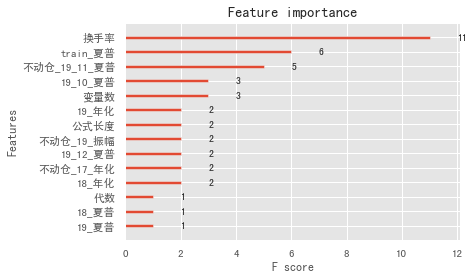

In [92]:
#8.6 xgboost重要特征筛选
from sklearn.feature_selection import SelectFromModel
# model = xgb.XGBClassifier()
# model.fit(X_train, y_train)
#plot_importance；利用plot_importance画出各个特征的重要性排序
from xgboost import plot_importance
plot_importance(xgb1)
plt.show()


In [93]:
for importance_type in ('weight', 'gain', 'cover', 'total_gain', 'total_cover'):
    print('%s: ' % importance_type, xgb1.get_booster().get_score(importance_type= importance_type))



weight:  {'18_年化': 2, '变量数': 3, '不动仓_17_年化': 2, '19_12_夏普': 2, '换手率': 11, '19_夏普': 1, '19_10_夏普': 3, '不动仓_19_振幅': 2, '公式长度': 2, 'train_夏普': 6, '不动仓_19_11_夏普': 5, '18_夏普': 1, '代数': 1, '19_年化': 2}
gain:  {'18_年化': 3.63124454, '变量数': 5.075663723333333, '不动仓_17_年化': 4.935245515, '19_12_夏普': 1.7930827100000002, '换手率': 4.000202786363635, '19_夏普': 0.25917992, '19_10_夏普': 1.14293011, '不动仓_19_振幅': 3.6722337, '公式长度': 1.4833537350000001, 'train_夏普': 1.5215461833333332, '不动仓_19_11_夏普': 1.5650948759999999, '18_夏普': 3.33266211, '代数': 3.67664433, '19_年化': 0.850880027}
cover:  {'18_年化': 33.2499943, '变量数': 28.49995233333333, '不动仓_17_年化': 24.499994299999997, '19_12_夏普': 21.249994299999997, '换手率': 33.249881745454545, '19_夏普': 18.7499981, '19_10_夏普': 13.6666501, '不动仓_19_振幅': 33.2499638, '公式长度': 15.99997375, 'train_夏普': 18.74998188333333, '不动仓_19_11_夏普': 12.24998874, '18_夏普': 33.2498589, '代数': 23.749876, '19_年化': 18.7499666}
total_gain:  {'18_年化': 7.26248908, '变量数': 15.22699117, '不动仓_17_年化': 9.87049103, '1